# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = './Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = './eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = './hybrid_graphs_output/graph_hybrid.pkl'
    NODE_MAPPING_PATH: str = './hybrid_graphs_output/node_mapping_hybrid.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    if "sorted_index_to_article_id" in node_map:
        node_map = node_map["sorted_index_to_article_id"]

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]

## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)


edges = []
weights = []
with open(config.GRAPH_PATH, 'rb') as f:
    graw = pickle.load(f)

for u, v, w in graw["edge_list"]:
    edges.append((int(u), int(v)))
    weights.append(float(w))

g_ig = ig.Graph(n=len(idx_to_aid), edges=edges)

plt.hist(weights, bins=50)
plt.title("Hybrid Graph Edge Weight Distribution")
plt.savefig("graph_edge_weight_distribution.png", dpi=150)
plt.close()

num_components = len(g_ig.components())
largest_comp = g_ig.components().giant()
avg_path = largest_comp.average_path_length()

print("Graph Connectivity (igraph):")
print("Components:", num_components)
print("Avg shortest path (largest component):", avg_path)


Graph Connectivity (igraph):
Components: 44
Avg shortest path (largest component): 6.665956898056829


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [01:54<00:00, 114.70s/it]

100%|██████████| 1/1 [01:54<00:00, 114.70s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:04<01:41,  4.81s/it]

  9%|▉         | 2/22 [00:07<01:09,  3.48s/it]

 14%|█▎        | 3/22 [00:12<01:20,  4.25s/it]

 18%|█▊        | 4/22 [00:13<00:54,  3.01s/it]

 23%|██▎       | 5/22 [00:14<00:41,  2.42s/it]

 27%|██▋       | 6/22 [00:21<00:59,  3.74s/it]

 32%|███▏      | 7/22 [00:27<01:07,  4.50s/it]

 36%|███▋      | 8/22 [00:34<01:13,  5.22s/it]

 41%|████      | 9/22 [00:35<00:53,  4.09s/it]

 45%|████▌     | 10/22 [00:36<00:37,  3.12s/it]

 50%|█████     | 11/22 [00:41<00:39,  3.59s/it]

 55%|█████▍    | 12/22 [00:43<00:30,  3.05s/it]

 59%|█████▉    | 13/22 [00:47<00:30,  3.40s/it]

 64%|██████▎   | 14/22 [00:50<00:26,  3.25s/it]

 68%|██████▊   | 15/22 [00:57<00:30,  4.43s/it]

 73%|███████▎  | 16/22 [00:59<00:23,  3.85s/it]

 77%|███████▋  | 17/22 [01:02<00:17,  3.56s/it]

 82%|████████▏ | 18/22 [01:04<00:11,  2.87s/it]

 86%|████████▋ | 19/22 [01:05<00:07,  2.38s/it]

 91%|█████████ | 20/22 [01:06<00:03,  1.99s/it]

 95%|█████████▌| 21/22 [01:10<00:02,  2.64s/it]

100%|██████████| 22/22 [01:12<00:00,  2.55s/it]

100%|██████████| 22/22 [01:12<00:00,  3.31s/it]


Article Retrieval Metrics:
mAP: 0.5701
MRR: 0.5701
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.7727
Recall@50: 0.7727

Image Retrieval Metrics:
mAP: 0.4068
MRR: 0.4068
Recall@1: 0.2727
Recall@5: 0.6364
Recall@10: 0.6818
Recall@20: 0.6818
Recall@50: 0.6818


# VISUALIZATION

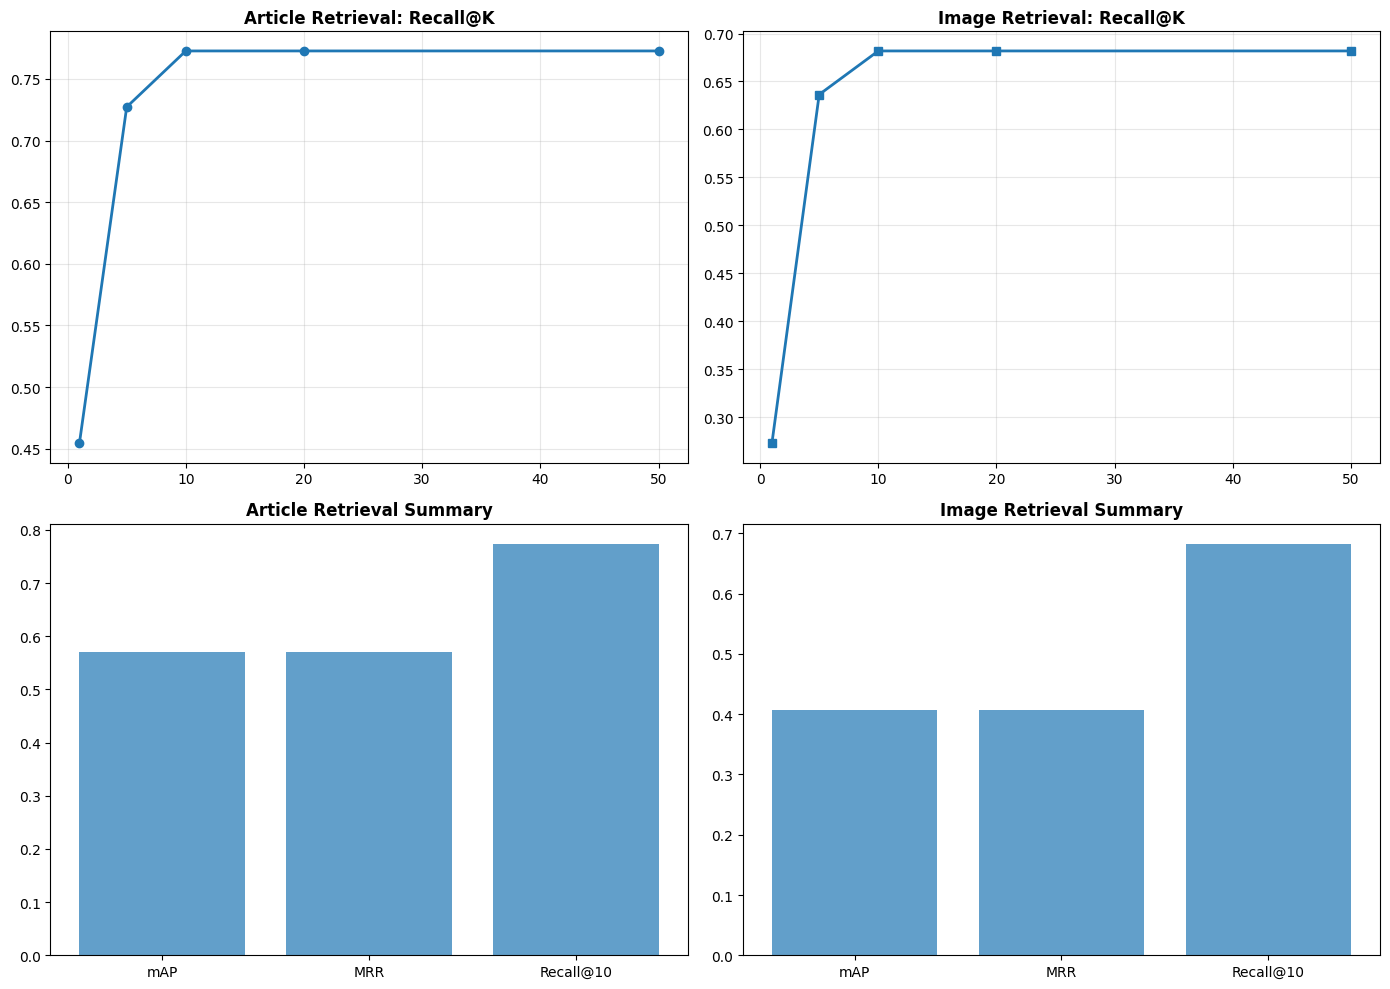

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:17,  2.58it/s]

  4%|▍         | 2/47 [00:00<00:17,  2.59it/s]

  6%|▋         | 3/47 [00:01<00:17,  2.50it/s]

  9%|▊         | 4/47 [00:01<00:17,  2.41it/s]

 11%|█         | 5/47 [00:02<00:16,  2.50it/s]

 13%|█▎        | 6/47 [00:02<00:16,  2.42it/s]

 15%|█▍        | 7/47 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/47 [00:03<00:15,  2.59it/s]

 19%|█▉        | 9/47 [00:03<00:14,  2.61it/s]

 21%|██▏       | 10/47 [00:04<00:14,  2.47it/s]

 23%|██▎       | 11/47 [00:04<00:14,  2.52it/s]

 26%|██▌       | 12/47 [00:04<00:13,  2.51it/s]

 28%|██▊       | 13/47 [00:05<00:13,  2.48it/s]

 30%|██▉       | 14/47 [00:05<00:12,  2.56it/s]

 32%|███▏      | 15/47 [00:05<00:12,  2.61it/s]

 34%|███▍      | 16/47 [00:06<00:11,  2.70it/s]

 36%|███▌      | 17/47 [00:06<00:11,  2.70it/s]

 38%|███▊      | 18/47 [00:07<00:10,  2.70it/s]

 40%|████      | 19/47 [00:07<00:10,  2.64it/s]

 43%|████▎     | 20/47 [00:07<00:10,  2.65it/s]

 45%|████▍     | 21/47 [00:08<00:10,  2.56it/s]

 47%|████▋     | 22/47 [00:08<00:09,  2.56it/s]

 49%|████▉     | 23/47 [00:08<00:09,  2.53it/s]

 51%|█████     | 24/47 [00:09<00:09,  2.38it/s]

 53%|█████▎    | 25/47 [00:09<00:08,  2.46it/s]

 55%|█████▌    | 26/47 [00:10<00:08,  2.51it/s]

 57%|█████▋    | 27/47 [00:10<00:07,  2.59it/s]

 60%|█████▉    | 28/47 [00:10<00:07,  2.62it/s]

 62%|██████▏   | 29/47 [00:11<00:06,  2.60it/s]

 64%|██████▍   | 30/47 [00:11<00:06,  2.56it/s]

 66%|██████▌   | 31/47 [00:12<00:06,  2.66it/s]

 68%|██████▊   | 32/47 [00:12<00:05,  2.88it/s]

 70%|███████   | 33/47 [00:12<00:04,  2.87it/s]

 72%|███████▏  | 34/47 [00:13<00:04,  2.93it/s]

 74%|███████▍  | 35/47 [00:13<00:03,  3.03it/s]

 77%|███████▋  | 36/47 [00:13<00:03,  2.91it/s]

 79%|███████▊  | 37/47 [00:14<00:03,  2.80it/s]

 81%|████████  | 38/47 [00:14<00:03,  2.68it/s]

 83%|████████▎ | 39/47 [00:14<00:03,  2.57it/s]

 85%|████████▌ | 40/47 [00:15<00:02,  2.46it/s]

 87%|████████▋ | 41/47 [00:15<00:02,  2.43it/s]

 89%|████████▉ | 42/47 [00:16<00:02,  2.32it/s]

 91%|█████████▏| 43/47 [00:16<00:01,  2.30it/s]

 94%|█████████▎| 44/47 [00:17<00:01,  2.10it/s]

 96%|█████████▌| 45/47 [00:17<00:00,  2.14it/s]

 98%|█████████▊| 46/47 [00:18<00:00,  2.28it/s]

100%|██████████| 47/47 [00:18<00:00,  2.36it/s]

100%|██████████| 47/47 [00:18<00:00,  2.54it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [05:29<4:12:49, 329.77s/it]

  4%|▍         | 2/47 [11:06<4:10:36, 334.14s/it]

  6%|▋         | 3/47 [16:41<4:05:18, 334.51s/it]

  9%|▊         | 4/47 [22:27<4:02:56, 339.00s/it]

 11%|█         | 5/47 [28:05<3:56:59, 338.55s/it]

 13%|█▎        | 6/47 [33:37<3:49:50, 336.34s/it]

 15%|█▍        | 7/47 [39:18<3:45:17, 337.95s/it]

 17%|█▋        | 8/47 [44:53<3:39:03, 337.02s/it]

 19%|█▉        | 9/47 [50:34<3:34:06, 338.05s/it]

 21%|██▏       | 10/47 [56:14<3:28:57, 338.86s/it]

 23%|██▎       | 11/47 [1:02:01<3:24:47, 341.33s/it]

 26%|██▌       | 12/47 [1:07:44<3:19:24, 341.86s/it]

 28%|██▊       | 13/47 [1:13:29<3:14:15, 342.80s/it]

 30%|██▉       | 14/47 [1:19:08<3:07:49, 341.51s/it]

 32%|███▏      | 15/47 [1:24:50<3:02:14, 341.71s/it]

 34%|███▍      | 16/47 [1:30:21<2:54:54, 338.53s/it]

 36%|███▌      | 17/47 [1:35:59<2:49:10, 338.36s/it]

 38%|███▊      | 18/47 [1:41:32<2:42:46, 336.76s/it]

 40%|████      | 19/47 [1:47:08<2:36:59, 336.40s/it]

 43%|████▎     | 20/47 [1:52:48<2:31:55, 337.60s/it]

 45%|████▍     | 21/47 [1:58:25<2:26:08, 337.25s/it]

 47%|████▋     | 22/47 [2:04:03<2:20:39, 337.57s/it]

 49%|████▉     | 23/47 [2:09:38<2:14:43, 336.81s/it]

 51%|█████     | 24/47 [2:15:21<2:09:49, 338.65s/it]

 53%|█████▎    | 25/47 [2:20:47<2:02:48, 334.92s/it]

 55%|█████▌    | 26/47 [2:26:16<1:56:34, 333.05s/it]

 57%|█████▋    | 27/47 [2:31:48<1:50:58, 332.94s/it]

 60%|█████▉    | 28/47 [2:37:19<1:45:12, 332.25s/it]

 62%|██████▏   | 29/47 [2:42:47<1:39:19, 331.06s/it]

 64%|██████▍   | 30/47 [2:48:14<1:33:26, 329.80s/it]

 66%|██████▌   | 31/47 [2:53:42<1:27:46, 329.15s/it]

 68%|██████▊   | 32/47 [2:59:10<1:22:12, 328.83s/it]

 70%|███████   | 33/47 [3:04:38<1:16:38, 328.48s/it]

 72%|███████▏  | 34/47 [3:10:06<1:11:08, 328.32s/it]

 74%|███████▍  | 35/47 [3:15:38<1:05:53, 329.44s/it]

 77%|███████▋  | 36/47 [3:21:10<1:00:35, 330.45s/it]

 79%|███████▊  | 37/47 [3:26:45<55:17, 331.78s/it]  

 81%|████████  | 38/47 [3:32:17<49:46, 331.84s/it]

 83%|████████▎ | 39/47 [3:37:53<44:23, 332.89s/it]

 85%|████████▌ | 40/47 [3:43:35<39:08, 335.57s/it]

 87%|████████▋ | 41/47 [3:49:06<33:26, 334.35s/it]

 89%|████████▉ | 42/47 [3:54:50<28:06, 337.29s/it]

 91%|█████████▏| 43/47 [4:00:32<22:34, 338.54s/it]

 94%|█████████▎| 44/47 [4:06:15<16:59, 339.95s/it]

 96%|█████████▌| 45/47 [4:11:57<11:21, 340.73s/it]

 98%|█████████▊| 46/47 [4:17:36<05:40, 340.08s/it]

100%|██████████| 47/47 [4:22:29<00:00, 325.94s/it]

100%|██████████| 47/47 [4:22:29<00:00, 335.09s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:08<6:40:02,  8.00s/it]

  0%|          | 2/3000 [00:14<5:52:53,  7.06s/it]

  0%|          | 3/3000 [00:17<4:18:16,  5.17s/it]

  0%|          | 4/3000 [00:21<3:51:03,  4.63s/it]

  0%|          | 5/3000 [00:24<3:35:40,  4.32s/it]

  0%|          | 6/3000 [00:28<3:17:26,  3.96s/it]

  0%|          | 7/3000 [00:35<4:12:21,  5.06s/it]

  0%|          | 8/3000 [00:41<4:25:31,  5.32s/it]

  0%|          | 9/3000 [00:44<3:56:34,  4.75s/it]

  0%|          | 10/3000 [00:48<3:40:36,  4.43s/it]

  0%|          | 11/3000 [00:50<3:00:41,  3.63s/it]

  0%|          | 12/3000 [00:51<2:28:08,  2.97s/it]

  0%|          | 13/3000 [00:57<3:12:37,  3.87s/it]

  0%|          | 14/3000 [01:01<3:05:39,  3.73s/it]

  0%|          | 15/3000 [01:06<3:28:37,  4.19s/it]

  1%|          | 16/3000 [01:11<3:43:08,  4.49s/it]

  1%|          | 17/3000 [01:13<3:10:31,  3.83s/it]

  1%|          | 18/3000 [01:18<3:24:21,  4.11s/it]

  1%|          | 19/3000 [01:22<3:20:17,  4.03s/it]

  1%|          | 20/3000 [01:26<3:17:14,  3.97s/it]

  1%|          | 21/3000 [01:31<3:37:28,  4.38s/it]

  1%|          | 22/3000 [01:36<3:47:50,  4.59s/it]

  1%|          | 23/3000 [01:46<5:03:50,  6.12s/it]

  1%|          | 24/3000 [01:49<4:11:14,  5.07s/it]

  1%|          | 25/3000 [01:54<4:19:02,  5.22s/it]

  1%|          | 26/3000 [01:59<4:08:26,  5.01s/it]

  1%|          | 27/3000 [02:03<3:57:32,  4.79s/it]

  1%|          | 28/3000 [02:06<3:27:41,  4.19s/it]

  1%|          | 29/3000 [02:07<2:48:13,  3.40s/it]

  1%|          | 30/3000 [02:11<2:54:15,  3.52s/it]

  1%|          | 31/3000 [02:14<2:38:40,  3.21s/it]

  1%|          | 32/3000 [02:23<4:04:51,  4.95s/it]

  1%|          | 33/3000 [02:28<4:15:29,  5.17s/it]

  1%|          | 34/3000 [02:36<4:55:12,  5.97s/it]

  1%|          | 35/3000 [02:41<4:32:19,  5.51s/it]

  1%|          | 36/3000 [02:45<4:15:41,  5.18s/it]

  1%|          | 37/3000 [02:46<3:20:05,  4.05s/it]

  1%|▏         | 38/3000 [02:48<2:47:50,  3.40s/it]

  1%|▏         | 39/3000 [02:52<2:51:59,  3.49s/it]

  1%|▏         | 40/3000 [02:55<2:39:59,  3.24s/it]

  1%|▏         | 41/3000 [02:58<2:39:04,  3.23s/it]

  1%|▏         | 42/3000 [02:59<2:12:28,  2.69s/it]

  1%|▏         | 43/3000 [03:02<2:12:55,  2.70s/it]

  1%|▏         | 44/3000 [03:05<2:17:31,  2.79s/it]

  2%|▏         | 45/3000 [03:09<2:37:33,  3.20s/it]

  2%|▏         | 46/3000 [03:14<2:58:46,  3.63s/it]

  2%|▏         | 47/3000 [03:16<2:38:10,  3.21s/it]

  2%|▏         | 48/3000 [03:20<2:55:15,  3.56s/it]

  2%|▏         | 49/3000 [03:22<2:22:58,  2.91s/it]

  2%|▏         | 50/3000 [03:24<2:19:01,  2.83s/it]

  2%|▏         | 51/3000 [03:33<3:37:21,  4.42s/it]

  2%|▏         | 52/3000 [03:38<3:53:20,  4.75s/it]

  2%|▏         | 53/3000 [03:43<4:02:33,  4.94s/it]

  2%|▏         | 54/3000 [03:52<4:54:13,  5.99s/it]

  2%|▏         | 55/3000 [03:55<4:11:35,  5.13s/it]

  2%|▏         | 56/3000 [04:01<4:22:53,  5.36s/it]

  2%|▏         | 57/3000 [04:03<3:42:06,  4.53s/it]

  2%|▏         | 58/3000 [04:07<3:28:47,  4.26s/it]

  2%|▏         | 59/3000 [04:09<2:51:14,  3.49s/it]

  2%|▏         | 60/3000 [04:13<2:56:39,  3.61s/it]

  2%|▏         | 61/3000 [04:15<2:38:29,  3.24s/it]

  2%|▏         | 62/3000 [04:23<3:49:05,  4.68s/it]

  2%|▏         | 63/3000 [04:27<3:31:14,  4.32s/it]

  2%|▏         | 64/3000 [04:32<3:40:41,  4.51s/it]

  2%|▏         | 65/3000 [04:35<3:27:33,  4.24s/it]

  2%|▏         | 66/3000 [04:39<3:21:42,  4.12s/it]

  2%|▏         | 67/3000 [04:43<3:21:29,  4.12s/it]

  2%|▏         | 68/3000 [04:49<3:42:34,  4.55s/it]

  2%|▏         | 69/3000 [04:53<3:43:32,  4.58s/it]

  2%|▏         | 70/3000 [04:57<3:26:14,  4.22s/it]

  2%|▏         | 71/3000 [05:02<3:35:17,  4.41s/it]

  2%|▏         | 72/3000 [05:04<3:04:13,  3.78s/it]

  2%|▏         | 73/3000 [05:09<3:30:11,  4.31s/it]

  2%|▏         | 74/3000 [05:14<3:41:15,  4.54s/it]

  2%|▎         | 75/3000 [05:25<5:07:03,  6.30s/it]

  3%|▎         | 76/3000 [05:28<4:17:57,  5.29s/it]

  3%|▎         | 77/3000 [05:33<4:10:39,  5.15s/it]

  3%|▎         | 78/3000 [05:38<4:09:53,  5.13s/it]

  3%|▎         | 79/3000 [05:42<4:03:49,  5.01s/it]

  3%|▎         | 80/3000 [05:51<4:48:15,  5.92s/it]

  3%|▎         | 81/3000 [05:55<4:25:50,  5.46s/it]

  3%|▎         | 82/3000 [05:57<3:39:02,  4.50s/it]

  3%|▎         | 83/3000 [06:00<3:16:29,  4.04s/it]

  3%|▎         | 84/3000 [06:06<3:48:46,  4.71s/it]

  3%|▎         | 85/3000 [06:09<3:23:15,  4.18s/it]

  3%|▎         | 86/3000 [06:13<3:09:29,  3.90s/it]

  3%|▎         | 87/3000 [06:17<3:23:19,  4.19s/it]

  3%|▎         | 88/3000 [06:24<3:55:39,  4.86s/it]

  3%|▎         | 89/3000 [06:29<4:02:55,  5.01s/it]

  3%|▎         | 90/3000 [06:35<4:13:17,  5.22s/it]

  3%|▎         | 91/3000 [06:39<3:53:57,  4.83s/it]

  3%|▎         | 92/3000 [06:42<3:27:40,  4.28s/it]

  3%|▎         | 93/3000 [06:45<3:10:01,  3.92s/it]

  3%|▎         | 94/3000 [06:47<2:37:19,  3.25s/it]

  3%|▎         | 95/3000 [06:49<2:19:10,  2.87s/it]

  3%|▎         | 96/3000 [06:50<2:02:24,  2.53s/it]

  3%|▎         | 97/3000 [06:53<1:58:23,  2.45s/it]

  3%|▎         | 98/3000 [06:55<1:57:48,  2.44s/it]

  3%|▎         | 99/3000 [06:57<1:47:16,  2.22s/it]

  3%|▎         | 100/3000 [06:58<1:40:41,  2.08s/it]

  3%|▎         | 101/3000 [07:03<2:17:49,  2.85s/it]

  3%|▎         | 102/3000 [07:06<2:21:04,  2.92s/it]

  3%|▎         | 103/3000 [07:09<2:24:42,  3.00s/it]

  3%|▎         | 104/3000 [07:17<3:32:29,  4.40s/it]

  4%|▎         | 105/3000 [07:18<2:40:39,  3.33s/it]

  4%|▎         | 106/3000 [07:22<2:53:16,  3.59s/it]

  4%|▎         | 107/3000 [07:25<2:40:11,  3.32s/it]

  4%|▎         | 108/3000 [07:32<3:41:00,  4.59s/it]

  4%|▎         | 109/3000 [07:39<4:05:16,  5.09s/it]

  4%|▎         | 110/3000 [07:43<3:49:33,  4.77s/it]

  4%|▎         | 111/3000 [07:47<3:40:24,  4.58s/it]

  4%|▎         | 112/3000 [07:49<2:59:29,  3.73s/it]

  4%|▍         | 113/3000 [07:51<2:34:33,  3.21s/it]

  4%|▍         | 114/3000 [07:57<3:17:21,  4.10s/it]

  4%|▍         | 115/3000 [08:00<3:11:46,  3.99s/it]

  4%|▍         | 116/3000 [08:05<3:15:29,  4.07s/it]

  4%|▍         | 117/3000 [08:09<3:20:58,  4.18s/it]

  4%|▍         | 118/3000 [08:12<2:55:10,  3.65s/it]

  4%|▍         | 119/3000 [08:14<2:43:12,  3.40s/it]

  4%|▍         | 120/3000 [08:17<2:35:41,  3.24s/it]

  4%|▍         | 121/3000 [08:24<3:25:54,  4.29s/it]

  4%|▍         | 122/3000 [08:30<3:44:12,  4.67s/it]

  4%|▍         | 123/3000 [08:33<3:27:29,  4.33s/it]

  4%|▍         | 124/3000 [08:36<3:07:41,  3.92s/it]

  4%|▍         | 125/3000 [08:38<2:43:30,  3.41s/it]

  4%|▍         | 126/3000 [08:42<2:48:58,  3.53s/it]

  4%|▍         | 127/3000 [08:48<3:26:53,  4.32s/it]

  4%|▍         | 128/3000 [08:54<3:48:41,  4.78s/it]

  4%|▍         | 129/3000 [09:00<4:04:38,  5.11s/it]

  4%|▍         | 130/3000 [09:04<3:54:26,  4.90s/it]

  4%|▍         | 131/3000 [09:09<3:49:11,  4.79s/it]

  4%|▍         | 132/3000 [09:18<4:45:45,  5.98s/it]

  4%|▍         | 133/3000 [09:22<4:21:42,  5.48s/it]

  4%|▍         | 134/3000 [09:29<4:42:58,  5.92s/it]

  4%|▍         | 135/3000 [09:33<4:13:19,  5.31s/it]

  5%|▍         | 136/3000 [09:41<4:48:12,  6.04s/it]

  5%|▍         | 137/3000 [09:46<4:34:30,  5.75s/it]

  5%|▍         | 138/3000 [09:49<4:06:01,  5.16s/it]

  5%|▍         | 139/3000 [09:52<3:28:22,  4.37s/it]

  5%|▍         | 140/3000 [09:54<2:51:12,  3.59s/it]

  5%|▍         | 141/3000 [09:55<2:22:37,  2.99s/it]

  5%|▍         | 142/3000 [09:57<2:06:45,  2.66s/it]

  5%|▍         | 143/3000 [09:59<1:59:12,  2.50s/it]

  5%|▍         | 144/3000 [10:05<2:40:43,  3.38s/it]

  5%|▍         | 145/3000 [10:08<2:35:19,  3.26s/it]

  5%|▍         | 146/3000 [10:09<2:03:52,  2.60s/it]

  5%|▍         | 147/3000 [10:10<1:43:23,  2.17s/it]

  5%|▍         | 148/3000 [10:11<1:30:30,  1.90s/it]

  5%|▍         | 149/3000 [10:15<1:57:28,  2.47s/it]

  5%|▌         | 150/3000 [10:17<1:43:44,  2.18s/it]

  5%|▌         | 151/3000 [10:18<1:40:09,  2.11s/it]

  5%|▌         | 152/3000 [10:26<2:57:04,  3.73s/it]

  5%|▌         | 153/3000 [10:33<3:38:51,  4.61s/it]

  5%|▌         | 154/3000 [10:42<4:39:16,  5.89s/it]

  5%|▌         | 155/3000 [10:46<4:16:09,  5.40s/it]

  5%|▌         | 156/3000 [10:51<4:16:58,  5.42s/it]

  5%|▌         | 157/3000 [10:54<3:42:45,  4.70s/it]

  5%|▌         | 158/3000 [10:59<3:47:28,  4.80s/it]

  5%|▌         | 159/3000 [11:01<2:57:00,  3.74s/it]

  5%|▌         | 160/3000 [11:03<2:37:15,  3.32s/it]

  5%|▌         | 161/3000 [11:06<2:38:21,  3.35s/it]

  5%|▌         | 162/3000 [11:12<3:08:56,  3.99s/it]

  5%|▌         | 163/3000 [11:15<2:56:23,  3.73s/it]

  5%|▌         | 164/3000 [11:19<2:59:08,  3.79s/it]

  6%|▌         | 165/3000 [11:21<2:38:37,  3.36s/it]

  6%|▌         | 166/3000 [11:23<2:11:26,  2.78s/it]

  6%|▌         | 167/3000 [11:25<2:08:16,  2.72s/it]

  6%|▌         | 168/3000 [11:29<2:18:41,  2.94s/it]

  6%|▌         | 169/3000 [11:30<1:59:59,  2.54s/it]

  6%|▌         | 170/3000 [11:32<1:41:47,  2.16s/it]

  6%|▌         | 171/3000 [11:35<2:04:45,  2.65s/it]

  6%|▌         | 172/3000 [11:36<1:42:32,  2.18s/it]

  6%|▌         | 173/3000 [11:42<2:32:48,  3.24s/it]

  6%|▌         | 174/3000 [11:47<3:01:43,  3.86s/it]

  6%|▌         | 175/3000 [11:51<2:57:09,  3.76s/it]

  6%|▌         | 176/3000 [11:54<2:48:35,  3.58s/it]

  6%|▌         | 177/3000 [11:57<2:32:09,  3.23s/it]

  6%|▌         | 178/3000 [12:00<2:37:21,  3.35s/it]

  6%|▌         | 179/3000 [12:03<2:31:20,  3.22s/it]

  6%|▌         | 180/3000 [12:06<2:28:30,  3.16s/it]

  6%|▌         | 181/3000 [12:10<2:35:16,  3.30s/it]

  6%|▌         | 182/3000 [12:13<2:38:54,  3.38s/it]

  6%|▌         | 183/3000 [12:18<2:53:27,  3.69s/it]

  6%|▌         | 184/3000 [12:23<3:17:07,  4.20s/it]

  6%|▌         | 185/3000 [12:25<2:45:20,  3.52s/it]

  6%|▌         | 186/3000 [12:31<3:16:36,  4.19s/it]

  6%|▌         | 187/3000 [12:33<2:49:26,  3.61s/it]

  6%|▋         | 188/3000 [12:37<2:59:04,  3.82s/it]

  6%|▋         | 189/3000 [12:42<3:12:29,  4.11s/it]

  6%|▋         | 190/3000 [12:44<2:46:16,  3.55s/it]

  6%|▋         | 191/3000 [12:47<2:33:25,  3.28s/it]

  6%|▋         | 192/3000 [12:51<2:39:17,  3.40s/it]

  6%|▋         | 193/3000 [13:00<3:59:20,  5.12s/it]

  6%|▋         | 194/3000 [13:03<3:27:41,  4.44s/it]

  6%|▋         | 195/3000 [13:10<4:08:59,  5.33s/it]

  7%|▋         | 196/3000 [13:14<3:55:17,  5.03s/it]

  7%|▋         | 197/3000 [13:19<3:45:02,  4.82s/it]

  7%|▋         | 198/3000 [13:22<3:23:38,  4.36s/it]

  7%|▋         | 199/3000 [13:27<3:30:48,  4.52s/it]

  7%|▋         | 200/3000 [13:30<3:14:57,  4.18s/it]

  7%|▋         | 201/3000 [13:34<3:04:41,  3.96s/it]

  7%|▋         | 202/3000 [13:39<3:17:05,  4.23s/it]

  7%|▋         | 203/3000 [13:43<3:12:39,  4.13s/it]

  7%|▋         | 204/3000 [13:46<2:58:38,  3.83s/it]

  7%|▋         | 205/3000 [13:48<2:43:01,  3.50s/it]

  7%|▋         | 206/3000 [13:55<3:29:04,  4.49s/it]

  7%|▋         | 207/3000 [14:01<3:49:04,  4.92s/it]

  7%|▋         | 208/3000 [14:04<3:24:27,  4.39s/it]

  7%|▋         | 209/3000 [14:14<4:41:26,  6.05s/it]

  7%|▋         | 210/3000 [14:23<5:17:04,  6.82s/it]

  7%|▋         | 211/3000 [14:31<5:38:53,  7.29s/it]

  7%|▋         | 212/3000 [14:34<4:29:24,  5.80s/it]

  7%|▋         | 213/3000 [14:36<3:45:03,  4.85s/it]

  7%|▋         | 214/3000 [14:42<3:56:57,  5.10s/it]

  7%|▋         | 215/3000 [14:46<3:38:04,  4.70s/it]

  7%|▋         | 216/3000 [14:49<3:21:48,  4.35s/it]

  7%|▋         | 217/3000 [14:52<3:04:39,  3.98s/it]

  7%|▋         | 218/3000 [14:56<3:02:00,  3.93s/it]

  7%|▋         | 219/3000 [15:00<3:02:24,  3.94s/it]

  7%|▋         | 220/3000 [15:06<3:23:33,  4.39s/it]

  7%|▋         | 221/3000 [15:14<4:20:30,  5.62s/it]

  7%|▋         | 222/3000 [15:19<4:07:47,  5.35s/it]

  7%|▋         | 223/3000 [15:23<3:57:33,  5.13s/it]

  7%|▋         | 224/3000 [15:27<3:41:33,  4.79s/it]

  8%|▊         | 225/3000 [15:30<3:08:15,  4.07s/it]

  8%|▊         | 226/3000 [15:37<3:53:04,  5.04s/it]

  8%|▊         | 227/3000 [15:44<4:18:10,  5.59s/it]

  8%|▊         | 228/3000 [15:49<4:10:58,  5.43s/it]

  8%|▊         | 229/3000 [15:52<3:43:31,  4.84s/it]

  8%|▊         | 230/3000 [15:56<3:30:08,  4.55s/it]

  8%|▊         | 231/3000 [15:58<2:50:24,  3.69s/it]

  8%|▊         | 232/3000 [16:03<3:13:50,  4.20s/it]

  8%|▊         | 233/3000 [16:06<2:50:28,  3.70s/it]

  8%|▊         | 234/3000 [16:11<3:08:24,  4.09s/it]

  8%|▊         | 235/3000 [16:16<3:16:13,  4.26s/it]

  8%|▊         | 236/3000 [16:18<2:57:10,  3.85s/it]

  8%|▊         | 237/3000 [16:21<2:42:00,  3.52s/it]

  8%|▊         | 238/3000 [16:32<4:25:59,  5.78s/it]

  8%|▊         | 239/3000 [16:35<3:42:18,  4.83s/it]

  8%|▊         | 240/3000 [16:40<3:53:11,  5.07s/it]

  8%|▊         | 241/3000 [16:47<4:09:33,  5.43s/it]

  8%|▊         | 242/3000 [16:50<3:46:02,  4.92s/it]

  8%|▊         | 243/3000 [16:53<3:15:22,  4.25s/it]

  8%|▊         | 244/3000 [17:00<3:45:54,  4.92s/it]

  8%|▊         | 245/3000 [17:02<3:14:39,  4.24s/it]

  8%|▊         | 246/3000 [17:06<3:09:57,  4.14s/it]

  8%|▊         | 247/3000 [17:10<3:00:44,  3.94s/it]

  8%|▊         | 248/3000 [17:13<2:56:42,  3.85s/it]

  8%|▊         | 249/3000 [17:18<3:10:08,  4.15s/it]

  8%|▊         | 250/3000 [17:21<2:52:08,  3.76s/it]

  8%|▊         | 251/3000 [17:27<3:22:29,  4.42s/it]

  8%|▊         | 252/3000 [17:28<2:36:26,  3.42s/it]

  8%|▊         | 253/3000 [17:31<2:24:10,  3.15s/it]

  8%|▊         | 254/3000 [17:35<2:36:01,  3.41s/it]

  8%|▊         | 255/3000 [17:38<2:40:52,  3.52s/it]

  9%|▊         | 256/3000 [17:42<2:41:30,  3.53s/it]

  9%|▊         | 257/3000 [17:43<2:05:07,  2.74s/it]

  9%|▊         | 258/3000 [17:49<2:45:49,  3.63s/it]

  9%|▊         | 259/3000 [17:51<2:32:10,  3.33s/it]

  9%|▊         | 260/3000 [17:55<2:40:34,  3.52s/it]

  9%|▊         | 261/3000 [17:58<2:30:27,  3.30s/it]

  9%|▊         | 262/3000 [18:01<2:24:02,  3.16s/it]

  9%|▉         | 263/3000 [18:03<2:11:36,  2.89s/it]

  9%|▉         | 264/3000 [18:06<2:15:27,  2.97s/it]

  9%|▉         | 265/3000 [18:10<2:32:01,  3.34s/it]

  9%|▉         | 266/3000 [18:17<3:21:13,  4.42s/it]

  9%|▉         | 267/3000 [18:19<2:45:41,  3.64s/it]

  9%|▉         | 268/3000 [18:32<4:51:28,  6.40s/it]

  9%|▉         | 269/3000 [18:34<3:58:59,  5.25s/it]

  9%|▉         | 270/3000 [18:40<4:08:53,  5.47s/it]

  9%|▉         | 271/3000 [18:44<3:38:36,  4.81s/it]

  9%|▉         | 272/3000 [18:54<4:54:12,  6.47s/it]

  9%|▉         | 273/3000 [18:58<4:24:50,  5.83s/it]

  9%|▉         | 274/3000 [19:02<3:59:09,  5.26s/it]

  9%|▉         | 275/3000 [19:05<3:25:37,  4.53s/it]

  9%|▉         | 276/3000 [19:08<3:03:46,  4.05s/it]

  9%|▉         | 277/3000 [19:10<2:39:32,  3.52s/it]

  9%|▉         | 278/3000 [19:14<2:45:44,  3.65s/it]

  9%|▉         | 279/3000 [19:20<3:14:27,  4.29s/it]

  9%|▉         | 280/3000 [19:24<3:11:18,  4.22s/it]

  9%|▉         | 281/3000 [19:31<3:42:28,  4.91s/it]

  9%|▉         | 282/3000 [19:33<3:00:29,  3.98s/it]

  9%|▉         | 283/3000 [19:36<2:52:24,  3.81s/it]

  9%|▉         | 284/3000 [19:38<2:31:56,  3.36s/it]

 10%|▉         | 285/3000 [19:41<2:20:12,  3.10s/it]

 10%|▉         | 286/3000 [19:44<2:22:28,  3.15s/it]

 10%|▉         | 287/3000 [19:47<2:19:17,  3.08s/it]

 10%|▉         | 288/3000 [19:50<2:14:48,  2.98s/it]

 10%|▉         | 289/3000 [19:53<2:20:37,  3.11s/it]

 10%|▉         | 290/3000 [19:57<2:29:42,  3.31s/it]

 10%|▉         | 291/3000 [20:03<3:04:43,  4.09s/it]

 10%|▉         | 292/3000 [20:13<4:25:01,  5.87s/it]

 10%|▉         | 293/3000 [20:18<4:14:42,  5.65s/it]

 10%|▉         | 294/3000 [20:23<4:07:34,  5.49s/it]

 10%|▉         | 295/3000 [20:29<4:12:18,  5.60s/it]

 10%|▉         | 296/3000 [20:36<4:31:07,  6.02s/it]

 10%|▉         | 297/3000 [20:44<4:55:46,  6.57s/it]

 10%|▉         | 298/3000 [20:50<4:56:43,  6.59s/it]

 10%|▉         | 299/3000 [20:56<4:47:18,  6.38s/it]

 10%|█         | 300/3000 [21:03<4:54:26,  6.54s/it]

 10%|█         | 301/3000 [21:09<4:39:40,  6.22s/it]

 10%|█         | 302/3000 [21:11<3:54:00,  5.20s/it]

 10%|█         | 303/3000 [21:15<3:34:26,  4.77s/it]

 10%|█         | 304/3000 [21:18<3:05:01,  4.12s/it]

 10%|█         | 305/3000 [21:21<2:45:23,  3.68s/it]

 10%|█         | 306/3000 [21:24<2:47:12,  3.72s/it]

 10%|█         | 307/3000 [21:28<2:41:23,  3.60s/it]

 10%|█         | 308/3000 [21:33<3:07:59,  4.19s/it]

 10%|█         | 309/3000 [21:36<2:47:02,  3.72s/it]

 10%|█         | 310/3000 [21:39<2:36:07,  3.48s/it]

 10%|█         | 311/3000 [21:51<4:30:49,  6.04s/it]

 10%|█         | 312/3000 [21:59<5:00:31,  6.71s/it]

 10%|█         | 313/3000 [22:12<6:29:32,  8.70s/it]

 10%|█         | 314/3000 [22:23<6:57:52,  9.33s/it]

 10%|█         | 315/3000 [22:32<6:47:54,  9.12s/it]

 11%|█         | 316/3000 [22:44<7:32:22, 10.11s/it]

 11%|█         | 317/3000 [22:48<6:09:24,  8.26s/it]

 11%|█         | 318/3000 [22:50<4:47:15,  6.43s/it]

 11%|█         | 319/3000 [22:56<4:36:17,  6.18s/it]

 11%|█         | 320/3000 [22:58<3:40:34,  4.94s/it]

 11%|█         | 321/3000 [23:01<3:18:09,  4.44s/it]

 11%|█         | 322/3000 [23:05<3:13:57,  4.35s/it]

 11%|█         | 323/3000 [23:10<3:13:51,  4.34s/it]

 11%|█         | 324/3000 [23:17<3:48:52,  5.13s/it]

 11%|█         | 325/3000 [23:19<3:05:35,  4.16s/it]

 11%|█         | 326/3000 [23:21<2:37:55,  3.54s/it]

 11%|█         | 327/3000 [23:25<2:45:01,  3.70s/it]

 11%|█         | 328/3000 [23:29<2:51:49,  3.86s/it]

 11%|█         | 329/3000 [23:34<3:13:33,  4.35s/it]

 11%|█         | 330/3000 [23:37<2:44:11,  3.69s/it]

 11%|█         | 331/3000 [23:40<2:33:23,  3.45s/it]

 11%|█         | 332/3000 [23:41<2:06:53,  2.85s/it]

 11%|█         | 333/3000 [23:44<2:13:04,  2.99s/it]

 11%|█         | 334/3000 [23:46<2:00:32,  2.71s/it]

 11%|█         | 335/3000 [23:52<2:36:47,  3.53s/it]

 11%|█         | 336/3000 [23:55<2:29:02,  3.36s/it]

 11%|█         | 337/3000 [23:58<2:28:56,  3.36s/it]

 11%|█▏        | 338/3000 [24:01<2:25:36,  3.28s/it]

 11%|█▏        | 339/3000 [24:03<2:09:46,  2.93s/it]

 11%|█▏        | 340/3000 [24:08<2:39:45,  3.60s/it]

 11%|█▏        | 341/3000 [24:13<2:54:32,  3.94s/it]

 11%|█▏        | 342/3000 [24:19<3:21:15,  4.54s/it]

 11%|█▏        | 343/3000 [24:24<3:19:29,  4.51s/it]

 11%|█▏        | 344/3000 [24:26<2:57:14,  4.00s/it]

 12%|█▏        | 345/3000 [24:28<2:31:19,  3.42s/it]

 12%|█▏        | 346/3000 [24:33<2:47:54,  3.80s/it]

 12%|█▏        | 347/3000 [24:35<2:26:34,  3.32s/it]

 12%|█▏        | 348/3000 [24:39<2:26:46,  3.32s/it]

 12%|█▏        | 349/3000 [24:45<3:01:31,  4.11s/it]

 12%|█▏        | 350/3000 [24:47<2:33:08,  3.47s/it]

 12%|█▏        | 351/3000 [24:53<3:08:15,  4.26s/it]

 12%|█▏        | 352/3000 [24:55<2:45:24,  3.75s/it]

 12%|█▏        | 353/3000 [25:02<3:30:32,  4.77s/it]

 12%|█▏        | 354/3000 [25:04<2:54:43,  3.96s/it]

 12%|█▏        | 355/3000 [25:10<3:16:37,  4.46s/it]

 12%|█▏        | 356/3000 [25:14<3:10:32,  4.32s/it]

 12%|█▏        | 357/3000 [25:18<3:06:49,  4.24s/it]

 12%|█▏        | 358/3000 [25:20<2:38:24,  3.60s/it]

 12%|█▏        | 359/3000 [25:24<2:39:03,  3.61s/it]

 12%|█▏        | 360/3000 [25:30<3:07:13,  4.26s/it]

 12%|█▏        | 361/3000 [25:34<3:03:11,  4.16s/it]

 12%|█▏        | 362/3000 [25:40<3:34:13,  4.87s/it]

 12%|█▏        | 363/3000 [25:42<2:57:47,  4.05s/it]

 12%|█▏        | 364/3000 [25:44<2:21:32,  3.22s/it]

 12%|█▏        | 365/3000 [25:45<1:54:50,  2.61s/it]

 12%|█▏        | 366/3000 [25:48<1:59:29,  2.72s/it]

 12%|█▏        | 367/3000 [25:49<1:45:01,  2.39s/it]

 12%|█▏        | 368/3000 [25:54<2:10:36,  2.98s/it]

 12%|█▏        | 369/3000 [25:57<2:09:33,  2.95s/it]

 12%|█▏        | 370/3000 [26:01<2:28:48,  3.39s/it]

 12%|█▏        | 371/3000 [26:04<2:18:55,  3.17s/it]

 12%|█▏        | 372/3000 [26:06<2:12:05,  3.02s/it]

 12%|█▏        | 373/3000 [26:09<2:11:46,  3.01s/it]

 12%|█▏        | 374/3000 [26:12<2:09:24,  2.96s/it]

 12%|█▎        | 375/3000 [26:15<2:08:29,  2.94s/it]

 13%|█▎        | 376/3000 [26:17<1:59:44,  2.74s/it]

 13%|█▎        | 377/3000 [26:20<2:00:55,  2.77s/it]

 13%|█▎        | 378/3000 [26:23<2:00:23,  2.75s/it]

 13%|█▎        | 379/3000 [26:25<1:55:41,  2.65s/it]

 13%|█▎        | 380/3000 [26:28<1:57:05,  2.68s/it]

 13%|█▎        | 381/3000 [26:33<2:25:04,  3.32s/it]

 13%|█▎        | 382/3000 [26:38<2:47:52,  3.85s/it]

 13%|█▎        | 383/3000 [26:41<2:32:40,  3.50s/it]

 13%|█▎        | 384/3000 [26:43<2:23:16,  3.29s/it]

 13%|█▎        | 385/3000 [26:47<2:23:31,  3.29s/it]

 13%|█▎        | 386/3000 [26:49<2:11:30,  3.02s/it]

 13%|█▎        | 387/3000 [26:53<2:27:58,  3.40s/it]

 13%|█▎        | 388/3000 [26:58<2:47:08,  3.84s/it]

 13%|█▎        | 389/3000 [27:01<2:38:29,  3.64s/it]

 13%|█▎        | 390/3000 [27:04<2:18:50,  3.19s/it]

 13%|█▎        | 391/3000 [27:06<2:10:06,  2.99s/it]

 13%|█▎        | 392/3000 [27:09<2:02:32,  2.82s/it]

 13%|█▎        | 393/3000 [27:14<2:34:05,  3.55s/it]

 13%|█▎        | 394/3000 [27:18<2:41:34,  3.72s/it]

 13%|█▎        | 395/3000 [27:21<2:32:16,  3.51s/it]

 13%|█▎        | 396/3000 [27:22<2:02:57,  2.83s/it]

 13%|█▎        | 397/3000 [27:24<1:51:14,  2.56s/it]

 13%|█▎        | 398/3000 [27:25<1:32:21,  2.13s/it]

 13%|█▎        | 399/3000 [27:29<1:50:38,  2.55s/it]

 13%|█▎        | 400/3000 [27:31<1:47:45,  2.49s/it]

 13%|█▎        | 401/3000 [27:33<1:38:28,  2.27s/it]

 13%|█▎        | 402/3000 [27:35<1:39:19,  2.29s/it]

 13%|█▎        | 403/3000 [27:39<1:54:04,  2.64s/it]

 13%|█▎        | 404/3000 [27:43<2:12:17,  3.06s/it]

 14%|█▎        | 405/3000 [27:45<2:03:02,  2.84s/it]

 14%|█▎        | 406/3000 [27:49<2:16:05,  3.15s/it]

 14%|█▎        | 407/3000 [27:54<2:38:59,  3.68s/it]

 14%|█▎        | 408/3000 [27:59<2:55:00,  4.05s/it]

 14%|█▎        | 409/3000 [28:01<2:28:42,  3.44s/it]

 14%|█▎        | 410/3000 [28:03<2:09:35,  3.00s/it]

 14%|█▎        | 411/3000 [28:05<2:01:13,  2.81s/it]

 14%|█▎        | 412/3000 [28:08<2:06:55,  2.94s/it]

 14%|█▍        | 413/3000 [28:11<2:09:00,  2.99s/it]

 14%|█▍        | 414/3000 [28:15<2:18:50,  3.22s/it]

 14%|█▍        | 415/3000 [28:16<1:51:14,  2.58s/it]

 14%|█▍        | 416/3000 [28:19<1:50:22,  2.56s/it]

 14%|█▍        | 417/3000 [28:20<1:34:31,  2.20s/it]

 14%|█▍        | 418/3000 [28:22<1:35:52,  2.23s/it]

 14%|█▍        | 419/3000 [28:24<1:33:25,  2.17s/it]

 14%|█▍        | 420/3000 [28:27<1:36:17,  2.24s/it]

 14%|█▍        | 421/3000 [28:29<1:34:04,  2.19s/it]

 14%|█▍        | 422/3000 [28:31<1:32:28,  2.15s/it]

 14%|█▍        | 423/3000 [28:32<1:23:05,  1.93s/it]

 14%|█▍        | 424/3000 [28:39<2:19:27,  3.25s/it]

 14%|█▍        | 425/3000 [28:42<2:17:33,  3.21s/it]

 14%|█▍        | 426/3000 [28:44<2:00:45,  2.81s/it]

 14%|█▍        | 427/3000 [28:48<2:13:15,  3.11s/it]

 14%|█▍        | 428/3000 [28:49<1:48:36,  2.53s/it]

 14%|█▍        | 429/3000 [28:52<2:01:31,  2.84s/it]

 14%|█▍        | 430/3000 [28:55<1:56:55,  2.73s/it]

 14%|█▍        | 431/3000 [28:58<2:00:42,  2.82s/it]

 14%|█▍        | 432/3000 [29:00<1:52:25,  2.63s/it]

 14%|█▍        | 433/3000 [29:04<2:08:58,  3.01s/it]

 14%|█▍        | 434/3000 [29:07<2:06:20,  2.95s/it]

 14%|█▍        | 435/3000 [29:10<2:07:42,  2.99s/it]

 15%|█▍        | 436/3000 [29:13<2:08:59,  3.02s/it]

 15%|█▍        | 437/3000 [29:15<1:54:34,  2.68s/it]

 15%|█▍        | 438/3000 [29:17<1:43:23,  2.42s/it]

 15%|█▍        | 439/3000 [29:18<1:33:53,  2.20s/it]

 15%|█▍        | 440/3000 [29:26<2:49:43,  3.98s/it]

 15%|█▍        | 441/3000 [29:32<3:07:45,  4.40s/it]

 15%|█▍        | 442/3000 [29:37<3:13:05,  4.53s/it]

 15%|█▍        | 443/3000 [29:39<2:48:56,  3.96s/it]

 15%|█▍        | 444/3000 [29:44<2:58:35,  4.19s/it]

 15%|█▍        | 445/3000 [29:53<3:59:34,  5.63s/it]

 15%|█▍        | 446/3000 [29:56<3:31:53,  4.98s/it]

 15%|█▍        | 447/3000 [29:59<2:56:08,  4.14s/it]

 15%|█▍        | 448/3000 [30:01<2:39:45,  3.76s/it]

 15%|█▍        | 449/3000 [30:05<2:34:05,  3.62s/it]

 15%|█▌        | 450/3000 [30:10<2:53:04,  4.07s/it]

 15%|█▌        | 451/3000 [30:14<2:48:58,  3.98s/it]

 15%|█▌        | 452/3000 [30:16<2:32:43,  3.60s/it]

 15%|█▌        | 453/3000 [30:19<2:16:17,  3.21s/it]

 15%|█▌        | 454/3000 [30:20<1:54:16,  2.69s/it]

 15%|█▌        | 455/3000 [30:24<2:02:55,  2.90s/it]

 15%|█▌        | 456/3000 [30:28<2:18:27,  3.27s/it]

 15%|█▌        | 457/3000 [30:30<2:05:56,  2.97s/it]

 15%|█▌        | 458/3000 [30:33<2:04:22,  2.94s/it]

 15%|█▌        | 459/3000 [30:37<2:21:17,  3.34s/it]

 15%|█▌        | 460/3000 [30:41<2:28:11,  3.50s/it]

 15%|█▌        | 461/3000 [30:45<2:38:23,  3.74s/it]

 15%|█▌        | 462/3000 [30:49<2:41:50,  3.83s/it]

 15%|█▌        | 463/3000 [30:52<2:31:47,  3.59s/it]

 15%|█▌        | 464/3000 [31:00<3:25:46,  4.87s/it]

 16%|█▌        | 465/3000 [31:04<3:14:28,  4.60s/it]

 16%|█▌        | 466/3000 [31:10<3:29:34,  4.96s/it]

 16%|█▌        | 467/3000 [31:19<4:15:47,  6.06s/it]

 16%|█▌        | 468/3000 [31:23<3:52:38,  5.51s/it]

 16%|█▌        | 469/3000 [31:25<3:14:44,  4.62s/it]

 16%|█▌        | 470/3000 [31:29<3:00:55,  4.29s/it]

 16%|█▌        | 471/3000 [31:32<2:41:20,  3.83s/it]

 16%|█▌        | 472/3000 [31:37<3:00:02,  4.27s/it]

 16%|█▌        | 473/3000 [31:42<3:07:48,  4.46s/it]

 16%|█▌        | 474/3000 [31:46<3:10:45,  4.53s/it]

 16%|█▌        | 475/3000 [31:51<3:15:54,  4.66s/it]

 16%|█▌        | 476/3000 [31:57<3:21:26,  4.79s/it]

 16%|█▌        | 477/3000 [32:05<4:03:59,  5.80s/it]

 16%|█▌        | 478/3000 [32:14<4:43:02,  6.73s/it]

 16%|█▌        | 479/3000 [32:21<4:50:46,  6.92s/it]

 16%|█▌        | 480/3000 [32:27<4:41:46,  6.71s/it]

 16%|█▌        | 481/3000 [32:31<4:10:03,  5.96s/it]

 16%|█▌        | 482/3000 [32:36<3:56:50,  5.64s/it]

 16%|█▌        | 483/3000 [32:40<3:38:08,  5.20s/it]

 16%|█▌        | 484/3000 [32:46<3:41:21,  5.28s/it]

 16%|█▌        | 485/3000 [32:49<3:16:47,  4.70s/it]

 16%|█▌        | 486/3000 [32:57<3:55:12,  5.61s/it]

 16%|█▌        | 487/3000 [32:58<3:02:14,  4.35s/it]

 16%|█▋        | 488/3000 [33:06<3:40:48,  5.27s/it]

 16%|█▋        | 489/3000 [33:10<3:24:41,  4.89s/it]

 16%|█▋        | 490/3000 [33:17<3:58:21,  5.70s/it]

 16%|█▋        | 491/3000 [33:19<3:09:56,  4.54s/it]

 16%|█▋        | 492/3000 [33:28<4:05:25,  5.87s/it]

 16%|█▋        | 493/3000 [33:37<4:39:48,  6.70s/it]

 16%|█▋        | 494/3000 [33:43<4:27:43,  6.41s/it]

 16%|█▋        | 495/3000 [33:51<4:46:11,  6.85s/it]

 17%|█▋        | 496/3000 [33:58<4:55:26,  7.08s/it]

 17%|█▋        | 497/3000 [34:08<5:28:52,  7.88s/it]

 17%|█▋        | 498/3000 [34:15<5:13:13,  7.51s/it]

 17%|█▋        | 499/3000 [34:16<3:59:37,  5.75s/it]

 17%|█▋        | 500/3000 [34:19<3:17:27,  4.74s/it]

 17%|█▋        | 501/3000 [34:21<2:45:58,  3.98s/it]

 17%|█▋        | 502/3000 [34:23<2:18:15,  3.32s/it]

 17%|█▋        | 503/3000 [34:24<1:58:06,  2.84s/it]

 17%|█▋        | 504/3000 [34:28<2:08:20,  3.09s/it]

 17%|█▋        | 505/3000 [34:31<2:13:09,  3.20s/it]

 17%|█▋        | 506/3000 [34:37<2:38:43,  3.82s/it]

 17%|█▋        | 507/3000 [34:41<2:40:06,  3.85s/it]

 17%|█▋        | 508/3000 [34:42<2:09:00,  3.11s/it]

 17%|█▋        | 509/3000 [34:47<2:29:27,  3.60s/it]

 17%|█▋        | 510/3000 [34:50<2:20:30,  3.39s/it]

 17%|█▋        | 511/3000 [34:52<2:07:12,  3.07s/it]

 17%|█▋        | 512/3000 [34:56<2:19:00,  3.35s/it]

 17%|█▋        | 513/3000 [34:59<2:17:04,  3.31s/it]

 17%|█▋        | 514/3000 [35:05<2:51:04,  4.13s/it]

 17%|█▋        | 515/3000 [35:08<2:32:32,  3.68s/it]

 17%|█▋        | 516/3000 [35:09<2:03:26,  2.98s/it]

 17%|█▋        | 517/3000 [35:13<2:13:34,  3.23s/it]

 17%|█▋        | 518/3000 [35:16<2:05:29,  3.03s/it]

 17%|█▋        | 519/3000 [35:18<1:55:03,  2.78s/it]

 17%|█▋        | 520/3000 [35:20<1:46:06,  2.57s/it]

 17%|█▋        | 521/3000 [35:23<1:59:16,  2.89s/it]

 17%|█▋        | 522/3000 [35:25<1:48:42,  2.63s/it]

 17%|█▋        | 523/3000 [35:30<2:08:12,  3.11s/it]

 17%|█▋        | 524/3000 [35:31<1:51:25,  2.70s/it]

 18%|█▊        | 525/3000 [35:36<2:14:01,  3.25s/it]

 18%|█▊        | 526/3000 [35:40<2:26:44,  3.56s/it]

 18%|█▊        | 527/3000 [35:46<2:54:24,  4.23s/it]

 18%|█▊        | 528/3000 [35:49<2:33:39,  3.73s/it]

 18%|█▊        | 529/3000 [35:52<2:24:35,  3.51s/it]

 18%|█▊        | 530/3000 [35:57<2:44:24,  3.99s/it]

 18%|█▊        | 531/3000 [35:58<2:12:17,  3.21s/it]

 18%|█▊        | 532/3000 [36:03<2:32:01,  3.70s/it]

 18%|█▊        | 533/3000 [36:08<2:51:13,  4.16s/it]

 18%|█▊        | 534/3000 [36:11<2:28:53,  3.62s/it]

 18%|█▊        | 535/3000 [36:15<2:32:58,  3.72s/it]

 18%|█▊        | 536/3000 [36:17<2:18:03,  3.36s/it]

 18%|█▊        | 537/3000 [36:21<2:20:38,  3.43s/it]

 18%|█▊        | 538/3000 [36:24<2:21:59,  3.46s/it]

 18%|█▊        | 539/3000 [36:26<2:01:42,  2.97s/it]

 18%|█▊        | 540/3000 [36:30<2:14:05,  3.27s/it]

 18%|█▊        | 541/3000 [36:38<3:10:55,  4.66s/it]

 18%|█▊        | 542/3000 [36:40<2:42:59,  3.98s/it]

 18%|█▊        | 543/3000 [36:42<2:20:30,  3.43s/it]

 18%|█▊        | 544/3000 [36:45<2:09:52,  3.17s/it]

 18%|█▊        | 545/3000 [36:47<1:59:14,  2.91s/it]

 18%|█▊        | 546/3000 [36:50<1:53:08,  2.77s/it]

 18%|█▊        | 547/3000 [36:52<1:51:39,  2.73s/it]

 18%|█▊        | 548/3000 [36:56<2:02:50,  3.01s/it]

 18%|█▊        | 549/3000 [37:01<2:23:25,  3.51s/it]

 18%|█▊        | 550/3000 [37:02<2:01:25,  2.97s/it]

 18%|█▊        | 551/3000 [37:08<2:33:42,  3.77s/it]

 18%|█▊        | 552/3000 [37:11<2:20:06,  3.43s/it]

 18%|█▊        | 553/3000 [37:13<2:02:20,  3.00s/it]

 18%|█▊        | 554/3000 [37:16<2:06:59,  3.11s/it]

 18%|█▊        | 555/3000 [37:19<2:06:42,  3.11s/it]

 19%|█▊        | 556/3000 [37:21<1:54:58,  2.82s/it]

 19%|█▊        | 557/3000 [37:23<1:36:46,  2.38s/it]

 19%|█▊        | 558/3000 [37:26<1:47:26,  2.64s/it]

 19%|█▊        | 559/3000 [37:28<1:35:50,  2.36s/it]

 19%|█▊        | 560/3000 [37:30<1:42:11,  2.51s/it]

 19%|█▊        | 561/3000 [37:33<1:42:48,  2.53s/it]

 19%|█▊        | 562/3000 [37:35<1:41:20,  2.49s/it]

 19%|█▉        | 563/3000 [37:38<1:36:41,  2.38s/it]

 19%|█▉        | 564/3000 [37:39<1:28:35,  2.18s/it]

 19%|█▉        | 565/3000 [37:48<2:50:02,  4.19s/it]

 19%|█▉        | 566/3000 [37:51<2:33:13,  3.78s/it]

 19%|█▉        | 567/3000 [37:54<2:26:34,  3.61s/it]

 19%|█▉        | 568/3000 [37:58<2:33:39,  3.79s/it]

 19%|█▉        | 569/3000 [38:02<2:34:40,  3.82s/it]

 19%|█▉        | 570/3000 [38:06<2:27:56,  3.65s/it]

 19%|█▉        | 571/3000 [38:08<2:12:17,  3.27s/it]

 19%|█▉        | 572/3000 [38:10<2:00:00,  2.97s/it]

 19%|█▉        | 573/3000 [38:12<1:41:13,  2.50s/it]

 19%|█▉        | 574/3000 [38:16<2:07:24,  3.15s/it]

 19%|█▉        | 575/3000 [38:21<2:27:14,  3.64s/it]

 19%|█▉        | 576/3000 [38:25<2:25:31,  3.60s/it]

 19%|█▉        | 577/3000 [38:26<1:57:49,  2.92s/it]

 19%|█▉        | 578/3000 [38:28<1:48:04,  2.68s/it]

 19%|█▉        | 579/3000 [38:29<1:29:26,  2.22s/it]

 19%|█▉        | 580/3000 [38:30<1:13:47,  1.83s/it]

 19%|█▉        | 581/3000 [38:33<1:27:50,  2.18s/it]

 19%|█▉        | 582/3000 [38:36<1:37:13,  2.41s/it]

 19%|█▉        | 583/3000 [38:39<1:49:46,  2.73s/it]

 19%|█▉        | 584/3000 [38:43<1:56:34,  2.90s/it]

 20%|█▉        | 585/3000 [38:46<2:06:46,  3.15s/it]

 20%|█▉        | 586/3000 [38:49<1:54:32,  2.85s/it]

 20%|█▉        | 587/3000 [38:51<1:42:56,  2.56s/it]

 20%|█▉        | 588/3000 [38:53<1:37:06,  2.42s/it]

 20%|█▉        | 589/3000 [38:56<1:50:42,  2.76s/it]

 20%|█▉        | 590/3000 [38:58<1:36:10,  2.39s/it]

 20%|█▉        | 591/3000 [39:00<1:33:22,  2.33s/it]

 20%|█▉        | 592/3000 [39:03<1:42:35,  2.56s/it]

 20%|█▉        | 593/3000 [39:05<1:40:32,  2.51s/it]

 20%|█▉        | 594/3000 [39:08<1:47:54,  2.69s/it]

 20%|█▉        | 595/3000 [39:12<1:53:17,  2.83s/it]

 20%|█▉        | 596/3000 [39:14<1:49:37,  2.74s/it]

 20%|█▉        | 597/3000 [39:21<2:33:34,  3.83s/it]

 20%|█▉        | 598/3000 [39:24<2:25:32,  3.64s/it]

 20%|█▉        | 599/3000 [39:26<2:13:40,  3.34s/it]

 20%|██        | 600/3000 [39:29<2:03:27,  3.09s/it]

 20%|██        | 601/3000 [39:32<2:08:02,  3.20s/it]

 20%|██        | 602/3000 [39:35<2:00:02,  3.00s/it]

 20%|██        | 603/3000 [39:38<1:56:33,  2.92s/it]

 20%|██        | 604/3000 [39:46<2:57:33,  4.45s/it]

 20%|██        | 605/3000 [39:49<2:45:16,  4.14s/it]

 20%|██        | 606/3000 [39:51<2:22:47,  3.58s/it]

 20%|██        | 607/3000 [39:56<2:37:05,  3.94s/it]

 20%|██        | 608/3000 [39:59<2:22:42,  3.58s/it]

 20%|██        | 609/3000 [40:03<2:26:18,  3.67s/it]

 20%|██        | 610/3000 [40:07<2:30:03,  3.77s/it]

 20%|██        | 611/3000 [40:11<2:34:07,  3.87s/it]

 20%|██        | 612/3000 [40:14<2:29:03,  3.75s/it]

 20%|██        | 613/3000 [40:16<2:05:39,  3.16s/it]

 20%|██        | 614/3000 [40:19<1:59:21,  3.00s/it]

 20%|██        | 615/3000 [40:28<3:09:47,  4.77s/it]

 21%|██        | 616/3000 [40:32<3:00:23,  4.54s/it]

 21%|██        | 617/3000 [40:36<3:00:03,  4.53s/it]

 21%|██        | 618/3000 [40:41<3:07:22,  4.72s/it]

 21%|██        | 619/3000 [40:45<2:54:41,  4.40s/it]

 21%|██        | 620/3000 [40:48<2:42:44,  4.10s/it]

 21%|██        | 621/3000 [40:51<2:27:38,  3.72s/it]

 21%|██        | 622/3000 [40:54<2:11:37,  3.32s/it]

 21%|██        | 623/3000 [40:56<2:05:33,  3.17s/it]

 21%|██        | 624/3000 [41:01<2:24:31,  3.65s/it]

 21%|██        | 625/3000 [41:04<2:10:02,  3.29s/it]

 21%|██        | 626/3000 [41:07<2:09:47,  3.28s/it]

 21%|██        | 627/3000 [41:11<2:15:39,  3.43s/it]

 21%|██        | 628/3000 [41:17<2:49:30,  4.29s/it]

 21%|██        | 629/3000 [41:26<3:50:43,  5.84s/it]

 21%|██        | 630/3000 [41:29<3:07:49,  4.76s/it]

 21%|██        | 631/3000 [41:32<2:55:42,  4.45s/it]

 21%|██        | 632/3000 [41:36<2:45:17,  4.19s/it]

 21%|██        | 633/3000 [41:41<2:52:40,  4.38s/it]

 21%|██        | 634/3000 [41:46<3:05:02,  4.69s/it]

 21%|██        | 635/3000 [41:50<2:52:41,  4.38s/it]

 21%|██        | 636/3000 [41:57<3:28:59,  5.30s/it]

 21%|██        | 637/3000 [42:01<3:14:39,  4.94s/it]

 21%|██▏       | 638/3000 [42:08<3:30:47,  5.35s/it]

 21%|██▏       | 639/3000 [42:10<2:58:41,  4.54s/it]

 21%|██▏       | 640/3000 [42:13<2:42:21,  4.13s/it]

 21%|██▏       | 641/3000 [42:16<2:25:48,  3.71s/it]

 21%|██▏       | 642/3000 [42:20<2:31:18,  3.85s/it]

 21%|██▏       | 643/3000 [42:26<2:48:14,  4.28s/it]

 21%|██▏       | 644/3000 [42:31<2:54:52,  4.45s/it]

 22%|██▏       | 645/3000 [42:35<2:54:46,  4.45s/it]

 22%|██▏       | 646/3000 [42:44<3:48:05,  5.81s/it]

 22%|██▏       | 647/3000 [42:47<3:21:04,  5.13s/it]

 22%|██▏       | 648/3000 [42:52<3:17:15,  5.03s/it]

 22%|██▏       | 649/3000 [42:56<3:02:14,  4.65s/it]

 22%|██▏       | 650/3000 [43:01<3:03:53,  4.70s/it]

 22%|██▏       | 651/3000 [43:03<2:34:14,  3.94s/it]

 22%|██▏       | 652/3000 [43:06<2:20:01,  3.58s/it]

 22%|██▏       | 653/3000 [43:11<2:37:39,  4.03s/it]

 22%|██▏       | 654/3000 [43:15<2:36:57,  4.01s/it]

 22%|██▏       | 655/3000 [43:23<3:22:43,  5.19s/it]

 22%|██▏       | 656/3000 [43:27<3:09:23,  4.85s/it]

 22%|██▏       | 657/3000 [43:32<3:16:53,  5.04s/it]

 22%|██▏       | 658/3000 [43:36<2:59:54,  4.61s/it]

 22%|██▏       | 659/3000 [43:38<2:35:25,  3.98s/it]

 22%|██▏       | 660/3000 [43:40<2:05:30,  3.22s/it]

 22%|██▏       | 661/3000 [43:42<1:56:19,  2.98s/it]

 22%|██▏       | 662/3000 [43:44<1:39:11,  2.55s/it]

 22%|██▏       | 663/3000 [43:45<1:25:17,  2.19s/it]

 22%|██▏       | 664/3000 [43:50<1:50:34,  2.84s/it]

 22%|██▏       | 665/3000 [43:54<2:06:20,  3.25s/it]

 22%|██▏       | 666/3000 [43:57<2:04:49,  3.21s/it]

 22%|██▏       | 667/3000 [44:01<2:15:22,  3.48s/it]

 22%|██▏       | 668/3000 [44:06<2:34:54,  3.99s/it]

 22%|██▏       | 669/3000 [44:10<2:29:42,  3.85s/it]

 22%|██▏       | 670/3000 [44:11<2:05:16,  3.23s/it]

 22%|██▏       | 671/3000 [44:13<1:45:46,  2.73s/it]

 22%|██▏       | 672/3000 [44:17<1:59:05,  3.07s/it]

 22%|██▏       | 673/3000 [44:22<2:25:54,  3.76s/it]

 22%|██▏       | 674/3000 [44:28<2:45:04,  4.26s/it]

 22%|██▎       | 675/3000 [44:29<2:10:05,  3.36s/it]

 23%|██▎       | 676/3000 [44:32<2:05:28,  3.24s/it]

 23%|██▎       | 677/3000 [44:34<1:56:03,  3.00s/it]

 23%|██▎       | 678/3000 [44:38<2:04:05,  3.21s/it]

 23%|██▎       | 679/3000 [44:40<1:49:30,  2.83s/it]

 23%|██▎       | 680/3000 [44:44<2:02:27,  3.17s/it]

 23%|██▎       | 681/3000 [44:51<2:43:37,  4.23s/it]

 23%|██▎       | 682/3000 [44:53<2:24:13,  3.73s/it]

 23%|██▎       | 683/3000 [44:55<2:05:42,  3.26s/it]

 23%|██▎       | 684/3000 [44:57<1:44:27,  2.71s/it]

 23%|██▎       | 685/3000 [45:00<1:46:55,  2.77s/it]

 23%|██▎       | 686/3000 [45:01<1:33:58,  2.44s/it]

 23%|██▎       | 687/3000 [45:07<2:14:32,  3.49s/it]

 23%|██▎       | 688/3000 [45:14<2:56:41,  4.59s/it]

 23%|██▎       | 689/3000 [45:22<3:33:11,  5.54s/it]

 23%|██▎       | 690/3000 [45:26<3:10:30,  4.95s/it]

 23%|██▎       | 691/3000 [45:29<2:47:53,  4.36s/it]

 23%|██▎       | 692/3000 [45:32<2:38:16,  4.11s/it]

 23%|██▎       | 693/3000 [45:37<2:41:34,  4.20s/it]

 23%|██▎       | 694/3000 [45:40<2:30:49,  3.92s/it]

 23%|██▎       | 695/3000 [45:43<2:17:51,  3.59s/it]

 23%|██▎       | 696/3000 [45:46<2:08:46,  3.35s/it]

 23%|██▎       | 697/3000 [45:49<2:07:51,  3.33s/it]

 23%|██▎       | 698/3000 [45:51<1:56:52,  3.05s/it]

 23%|██▎       | 699/3000 [45:54<1:53:25,  2.96s/it]

 23%|██▎       | 700/3000 [45:57<1:49:39,  2.86s/it]

 23%|██▎       | 701/3000 [46:01<2:08:30,  3.35s/it]

 23%|██▎       | 702/3000 [46:04<2:00:24,  3.14s/it]

 23%|██▎       | 703/3000 [46:07<1:55:38,  3.02s/it]

 23%|██▎       | 704/3000 [46:09<1:47:50,  2.82s/it]

 24%|██▎       | 705/3000 [46:14<2:13:16,  3.48s/it]

 24%|██▎       | 706/3000 [46:18<2:17:59,  3.61s/it]

 24%|██▎       | 707/3000 [46:21<2:07:19,  3.33s/it]

 24%|██▎       | 708/3000 [46:26<2:36:25,  4.10s/it]

 24%|██▎       | 709/3000 [46:32<2:49:13,  4.43s/it]

 24%|██▎       | 710/3000 [46:35<2:34:39,  4.05s/it]

 24%|██▎       | 711/3000 [46:38<2:30:12,  3.94s/it]

 24%|██▎       | 712/3000 [46:40<2:01:26,  3.18s/it]

 24%|██▍       | 713/3000 [46:42<1:44:00,  2.73s/it]

 24%|██▍       | 714/3000 [46:43<1:23:56,  2.20s/it]

 24%|██▍       | 715/3000 [46:45<1:24:07,  2.21s/it]

 24%|██▍       | 716/3000 [46:50<1:59:40,  3.14s/it]

 24%|██▍       | 717/3000 [46:53<1:57:54,  3.10s/it]

 24%|██▍       | 718/3000 [46:54<1:33:57,  2.47s/it]

 24%|██▍       | 719/3000 [46:57<1:35:41,  2.52s/it]

 24%|██▍       | 720/3000 [46:59<1:29:54,  2.37s/it]

 24%|██▍       | 721/3000 [47:01<1:27:27,  2.30s/it]

 24%|██▍       | 722/3000 [47:02<1:14:01,  1.95s/it]

 24%|██▍       | 723/3000 [47:08<1:56:36,  3.07s/it]

 24%|██▍       | 724/3000 [47:11<2:01:15,  3.20s/it]

 24%|██▍       | 725/3000 [47:16<2:14:38,  3.55s/it]

 24%|██▍       | 726/3000 [47:20<2:22:55,  3.77s/it]

 24%|██▍       | 727/3000 [47:24<2:25:51,  3.85s/it]

 24%|██▍       | 728/3000 [47:29<2:35:33,  4.11s/it]

 24%|██▍       | 729/3000 [47:30<2:05:56,  3.33s/it]

 24%|██▍       | 730/3000 [47:32<1:55:43,  3.06s/it]

 24%|██▍       | 731/3000 [47:38<2:21:27,  3.74s/it]

 24%|██▍       | 732/3000 [47:43<2:35:01,  4.10s/it]

 24%|██▍       | 733/3000 [47:47<2:33:14,  4.06s/it]

 24%|██▍       | 734/3000 [47:53<2:58:59,  4.74s/it]

 24%|██▍       | 735/3000 [47:59<3:17:13,  5.22s/it]

 25%|██▍       | 736/3000 [48:04<3:06:49,  4.95s/it]

 25%|██▍       | 737/3000 [48:06<2:38:18,  4.20s/it]

 25%|██▍       | 738/3000 [48:09<2:17:31,  3.65s/it]

 25%|██▍       | 739/3000 [48:13<2:26:21,  3.88s/it]

 25%|██▍       | 740/3000 [48:17<2:28:43,  3.95s/it]

 25%|██▍       | 741/3000 [48:19<2:11:19,  3.49s/it]

 25%|██▍       | 742/3000 [48:21<1:52:33,  2.99s/it]

 25%|██▍       | 743/3000 [48:25<2:02:01,  3.24s/it]

 25%|██▍       | 744/3000 [48:28<2:01:33,  3.23s/it]

 25%|██▍       | 745/3000 [48:34<2:33:50,  4.09s/it]

 25%|██▍       | 746/3000 [48:39<2:41:51,  4.31s/it]

 25%|██▍       | 747/3000 [48:42<2:19:41,  3.72s/it]

 25%|██▍       | 748/3000 [48:44<2:03:55,  3.30s/it]

 25%|██▍       | 749/3000 [48:53<3:13:18,  5.15s/it]

 25%|██▌       | 750/3000 [48:59<3:13:22,  5.16s/it]

 25%|██▌       | 751/3000 [49:01<2:43:40,  4.37s/it]

 25%|██▌       | 752/3000 [49:04<2:24:02,  3.84s/it]

 25%|██▌       | 753/3000 [49:07<2:14:30,  3.59s/it]

 25%|██▌       | 754/3000 [49:10<2:16:24,  3.64s/it]

 25%|██▌       | 755/3000 [49:16<2:36:47,  4.19s/it]

 25%|██▌       | 756/3000 [49:22<2:56:42,  4.72s/it]

 25%|██▌       | 757/3000 [49:26<2:47:51,  4.49s/it]

 25%|██▌       | 758/3000 [49:29<2:32:05,  4.07s/it]

 25%|██▌       | 759/3000 [49:33<2:30:11,  4.02s/it]

 25%|██▌       | 760/3000 [49:36<2:22:12,  3.81s/it]

 25%|██▌       | 761/3000 [49:39<2:12:33,  3.55s/it]

 25%|██▌       | 762/3000 [49:45<2:35:40,  4.17s/it]

 25%|██▌       | 763/3000 [49:49<2:32:56,  4.10s/it]

 25%|██▌       | 764/3000 [49:55<3:03:02,  4.91s/it]

 26%|██▌       | 765/3000 [49:58<2:38:34,  4.26s/it]

 26%|██▌       | 766/3000 [50:03<2:47:29,  4.50s/it]

 26%|██▌       | 767/3000 [50:08<2:45:18,  4.44s/it]

 26%|██▌       | 768/3000 [50:12<2:47:08,  4.49s/it]

 26%|██▌       | 769/3000 [50:14<2:14:42,  3.62s/it]

 26%|██▌       | 770/3000 [50:16<1:56:02,  3.12s/it]

 26%|██▌       | 771/3000 [50:23<2:40:13,  4.31s/it]

 26%|██▌       | 772/3000 [50:30<3:13:57,  5.22s/it]

 26%|██▌       | 773/3000 [50:37<3:29:02,  5.63s/it]

 26%|██▌       | 774/3000 [50:40<3:02:15,  4.91s/it]

 26%|██▌       | 775/3000 [50:42<2:33:04,  4.13s/it]

 26%|██▌       | 776/3000 [50:48<2:50:39,  4.60s/it]

 26%|██▌       | 777/3000 [50:52<2:42:41,  4.39s/it]

 26%|██▌       | 778/3000 [50:56<2:38:52,  4.29s/it]

 26%|██▌       | 779/3000 [51:00<2:32:53,  4.13s/it]

 26%|██▌       | 780/3000 [51:04<2:34:02,  4.16s/it]

 26%|██▌       | 781/3000 [51:12<3:14:55,  5.27s/it]

 26%|██▌       | 782/3000 [51:17<3:12:16,  5.20s/it]

 26%|██▌       | 783/3000 [51:19<2:33:37,  4.16s/it]

 26%|██▌       | 784/3000 [51:20<2:07:33,  3.45s/it]

 26%|██▌       | 785/3000 [51:23<1:52:38,  3.05s/it]

 26%|██▌       | 786/3000 [51:30<2:44:14,  4.45s/it]

 26%|██▌       | 787/3000 [51:38<3:19:24,  5.41s/it]

 26%|██▋       | 788/3000 [51:44<3:32:26,  5.76s/it]

 26%|██▋       | 789/3000 [51:51<3:36:31,  5.88s/it]

 26%|██▋       | 790/3000 [51:56<3:31:42,  5.75s/it]

 26%|██▋       | 791/3000 [52:01<3:23:07,  5.52s/it]

 26%|██▋       | 792/3000 [52:08<3:44:28,  6.10s/it]

 26%|██▋       | 793/3000 [52:13<3:27:39,  5.65s/it]

 26%|██▋       | 794/3000 [52:19<3:33:28,  5.81s/it]

 26%|██▋       | 795/3000 [52:24<3:24:04,  5.55s/it]

 27%|██▋       | 796/3000 [52:25<2:35:47,  4.24s/it]

 27%|██▋       | 797/3000 [52:31<2:52:25,  4.70s/it]

 27%|██▋       | 798/3000 [52:38<3:20:46,  5.47s/it]

 27%|██▋       | 799/3000 [52:45<3:28:47,  5.69s/it]

 27%|██▋       | 800/3000 [52:49<3:16:12,  5.35s/it]

 27%|██▋       | 801/3000 [52:56<3:35:55,  5.89s/it]

 27%|██▋       | 802/3000 [53:03<3:49:34,  6.27s/it]

 27%|██▋       | 803/3000 [53:10<3:49:05,  6.26s/it]

 27%|██▋       | 804/3000 [53:17<4:01:42,  6.60s/it]

 27%|██▋       | 805/3000 [53:30<5:06:07,  8.37s/it]

 27%|██▋       | 806/3000 [53:35<4:28:55,  7.35s/it]

 27%|██▋       | 807/3000 [53:37<3:37:04,  5.94s/it]

 27%|██▋       | 808/3000 [53:42<3:19:55,  5.47s/it]

 27%|██▋       | 809/3000 [53:49<3:39:27,  6.01s/it]

 27%|██▋       | 810/3000 [53:53<3:17:30,  5.41s/it]

 27%|██▋       | 811/3000 [53:57<3:07:21,  5.14s/it]

 27%|██▋       | 812/3000 [54:04<3:23:30,  5.58s/it]

 27%|██▋       | 813/3000 [54:13<4:01:47,  6.63s/it]

 27%|██▋       | 814/3000 [54:18<3:46:56,  6.23s/it]

 27%|██▋       | 815/3000 [54:22<3:20:20,  5.50s/it]

 27%|██▋       | 816/3000 [54:30<3:49:22,  6.30s/it]

 27%|██▋       | 817/3000 [54:35<3:35:02,  5.91s/it]

 27%|██▋       | 818/3000 [54:39<3:14:49,  5.36s/it]

 27%|██▋       | 819/3000 [54:47<3:37:09,  5.97s/it]

 27%|██▋       | 820/3000 [54:54<3:53:08,  6.42s/it]

 27%|██▋       | 821/3000 [54:58<3:27:25,  5.71s/it]

 27%|██▋       | 822/3000 [55:02<3:00:03,  4.96s/it]

 27%|██▋       | 823/3000 [55:09<3:26:33,  5.69s/it]

 27%|██▋       | 824/3000 [55:15<3:27:41,  5.73s/it]

 28%|██▊       | 825/3000 [55:18<2:55:14,  4.83s/it]

 28%|██▊       | 826/3000 [55:21<2:36:03,  4.31s/it]

 28%|██▊       | 827/3000 [55:23<2:16:26,  3.77s/it]

 28%|██▊       | 828/3000 [55:33<3:27:05,  5.72s/it]

 28%|██▊       | 829/3000 [55:36<2:51:27,  4.74s/it]

 28%|██▊       | 830/3000 [55:45<3:34:05,  5.92s/it]

 28%|██▊       | 831/3000 [55:48<3:08:52,  5.22s/it]

 28%|██▊       | 832/3000 [55:55<3:28:35,  5.77s/it]

 28%|██▊       | 833/3000 [55:58<2:55:07,  4.85s/it]

 28%|██▊       | 834/3000 [56:00<2:22:05,  3.94s/it]

 28%|██▊       | 835/3000 [56:06<2:47:09,  4.63s/it]

 28%|██▊       | 836/3000 [56:10<2:38:43,  4.40s/it]

 28%|██▊       | 837/3000 [56:12<2:15:12,  3.75s/it]

 28%|██▊       | 838/3000 [56:15<2:10:19,  3.62s/it]

 28%|██▊       | 839/3000 [56:18<1:59:24,  3.32s/it]

 28%|██▊       | 840/3000 [56:20<1:48:18,  3.01s/it]

 28%|██▊       | 841/3000 [56:28<2:34:23,  4.29s/it]

 28%|██▊       | 842/3000 [56:30<2:12:30,  3.68s/it]

 28%|██▊       | 843/3000 [56:43<3:54:55,  6.53s/it]

 28%|██▊       | 844/3000 [56:51<4:08:58,  6.93s/it]

 28%|██▊       | 845/3000 [56:52<3:06:58,  5.21s/it]

 28%|██▊       | 846/3000 [57:03<4:08:58,  6.94s/it]

 28%|██▊       | 847/3000 [57:10<4:11:26,  7.01s/it]

 28%|██▊       | 848/3000 [57:15<3:47:41,  6.35s/it]

 28%|██▊       | 849/3000 [57:22<3:51:32,  6.46s/it]

 28%|██▊       | 850/3000 [57:27<3:43:11,  6.23s/it]

 28%|██▊       | 851/3000 [57:33<3:41:21,  6.18s/it]

 28%|██▊       | 852/3000 [57:38<3:25:36,  5.74s/it]

 28%|██▊       | 853/3000 [57:43<3:12:33,  5.38s/it]

 28%|██▊       | 854/3000 [57:46<2:52:33,  4.82s/it]

 28%|██▊       | 855/3000 [57:53<3:09:52,  5.31s/it]

 29%|██▊       | 856/3000 [57:56<2:48:22,  4.71s/it]

 29%|██▊       | 857/3000 [58:03<3:12:25,  5.39s/it]

 29%|██▊       | 858/3000 [58:11<3:46:03,  6.33s/it]

 29%|██▊       | 859/3000 [58:21<4:17:36,  7.22s/it]

 29%|██▊       | 860/3000 [58:24<3:33:14,  5.98s/it]

 29%|██▊       | 861/3000 [58:27<3:00:10,  5.05s/it]

 29%|██▊       | 862/3000 [58:28<2:23:17,  4.02s/it]

 29%|██▉       | 863/3000 [58:30<1:59:17,  3.35s/it]

 29%|██▉       | 864/3000 [58:33<1:50:13,  3.10s/it]

 29%|██▉       | 865/3000 [58:33<1:25:49,  2.41s/it]

 29%|██▉       | 866/3000 [58:36<1:25:33,  2.41s/it]

 29%|██▉       | 867/3000 [58:44<2:30:05,  4.22s/it]

 29%|██▉       | 868/3000 [58:48<2:21:42,  3.99s/it]

 29%|██▉       | 869/3000 [58:52<2:26:34,  4.13s/it]

 29%|██▉       | 870/3000 [58:57<2:35:44,  4.39s/it]

 29%|██▉       | 871/3000 [59:04<3:01:57,  5.13s/it]

 29%|██▉       | 872/3000 [59:10<3:11:52,  5.41s/it]

 29%|██▉       | 873/3000 [59:17<3:28:42,  5.89s/it]

 29%|██▉       | 874/3000 [59:20<2:52:35,  4.87s/it]

 29%|██▉       | 875/3000 [59:23<2:33:14,  4.33s/it]

 29%|██▉       | 876/3000 [59:30<3:02:07,  5.14s/it]

 29%|██▉       | 877/3000 [59:33<2:36:50,  4.43s/it]

 29%|██▉       | 878/3000 [59:35<2:17:43,  3.89s/it]

 29%|██▉       | 879/3000 [59:39<2:12:22,  3.74s/it]

 29%|██▉       | 880/3000 [59:42<2:11:25,  3.72s/it]

 29%|██▉       | 881/3000 [59:49<2:44:01,  4.64s/it]

 29%|██▉       | 882/3000 [59:58<3:28:35,  5.91s/it]

 29%|██▉       | 883/3000 [1:00:06<3:55:36,  6.68s/it]

 29%|██▉       | 884/3000 [1:00:14<4:07:39,  7.02s/it]

 30%|██▉       | 885/3000 [1:00:19<3:46:13,  6.42s/it]

 30%|██▉       | 886/3000 [1:00:25<3:35:18,  6.11s/it]

 30%|██▉       | 887/3000 [1:00:28<3:03:11,  5.20s/it]

 30%|██▉       | 888/3000 [1:00:31<2:40:32,  4.56s/it]

 30%|██▉       | 889/3000 [1:00:34<2:27:43,  4.20s/it]

 30%|██▉       | 890/3000 [1:00:38<2:20:57,  4.01s/it]

 30%|██▉       | 891/3000 [1:00:41<2:13:05,  3.79s/it]

 30%|██▉       | 892/3000 [1:00:46<2:30:26,  4.28s/it]

 30%|██▉       | 893/3000 [1:00:48<1:59:17,  3.40s/it]

 30%|██▉       | 894/3000 [1:00:58<3:15:53,  5.58s/it]

 30%|██▉       | 895/3000 [1:01:02<2:57:55,  5.07s/it]

 30%|██▉       | 896/3000 [1:01:10<3:29:37,  5.98s/it]

 30%|██▉       | 897/3000 [1:01:23<4:43:35,  8.09s/it]

 30%|██▉       | 898/3000 [1:01:27<3:57:19,  6.77s/it]

 30%|██▉       | 899/3000 [1:01:30<3:17:17,  5.63s/it]

 30%|███       | 900/3000 [1:01:36<3:15:53,  5.60s/it]

 30%|███       | 901/3000 [1:01:41<3:10:03,  5.43s/it]

 30%|███       | 902/3000 [1:01:49<3:37:01,  6.21s/it]

 30%|███       | 903/3000 [1:01:52<3:08:07,  5.38s/it]

 30%|███       | 904/3000 [1:02:01<3:47:13,  6.50s/it]

 30%|███       | 905/3000 [1:02:07<3:39:56,  6.30s/it]

 30%|███       | 906/3000 [1:02:13<3:34:11,  6.14s/it]

 30%|███       | 907/3000 [1:02:14<2:40:32,  4.60s/it]

 30%|███       | 908/3000 [1:02:15<2:04:11,  3.56s/it]

 30%|███       | 909/3000 [1:02:18<2:00:02,  3.44s/it]

 30%|███       | 910/3000 [1:02:23<2:12:51,  3.81s/it]

 30%|███       | 911/3000 [1:02:26<2:06:39,  3.64s/it]

 30%|███       | 912/3000 [1:02:29<1:58:51,  3.42s/it]

 30%|███       | 913/3000 [1:02:33<2:06:24,  3.63s/it]

 30%|███       | 914/3000 [1:02:35<1:50:41,  3.18s/it]

 30%|███       | 915/3000 [1:02:41<2:15:37,  3.90s/it]

 31%|███       | 916/3000 [1:02:44<2:13:42,  3.85s/it]

 31%|███       | 917/3000 [1:02:51<2:39:29,  4.59s/it]

 31%|███       | 918/3000 [1:02:52<2:08:27,  3.70s/it]

 31%|███       | 919/3000 [1:02:56<2:02:25,  3.53s/it]

 31%|███       | 920/3000 [1:02:59<2:04:35,  3.59s/it]

 31%|███       | 921/3000 [1:03:05<2:29:54,  4.33s/it]

 31%|███       | 922/3000 [1:03:11<2:46:46,  4.82s/it]

 31%|███       | 923/3000 [1:03:14<2:23:14,  4.14s/it]

 31%|███       | 924/3000 [1:03:15<1:49:30,  3.17s/it]

 31%|███       | 925/3000 [1:03:17<1:36:00,  2.78s/it]

 31%|███       | 926/3000 [1:03:20<1:39:35,  2.88s/it]

 31%|███       | 927/3000 [1:03:23<1:44:31,  3.03s/it]

 31%|███       | 928/3000 [1:03:27<1:55:44,  3.35s/it]

 31%|███       | 929/3000 [1:03:34<2:30:54,  4.37s/it]

 31%|███       | 930/3000 [1:03:35<2:00:40,  3.50s/it]

 31%|███       | 931/3000 [1:03:38<1:51:01,  3.22s/it]

 31%|███       | 932/3000 [1:03:40<1:40:43,  2.92s/it]

 31%|███       | 933/3000 [1:03:42<1:24:58,  2.47s/it]

 31%|███       | 934/3000 [1:03:43<1:13:32,  2.14s/it]

 31%|███       | 935/3000 [1:03:46<1:24:14,  2.45s/it]

 31%|███       | 936/3000 [1:03:53<2:12:52,  3.86s/it]

 31%|███       | 937/3000 [1:04:02<3:03:55,  5.35s/it]

 31%|███▏      | 938/3000 [1:04:05<2:39:43,  4.65s/it]

 31%|███▏      | 939/3000 [1:04:09<2:34:21,  4.49s/it]

 31%|███▏      | 940/3000 [1:04:12<2:13:28,  3.89s/it]

 31%|███▏      | 941/3000 [1:04:17<2:24:48,  4.22s/it]

 31%|███▏      | 942/3000 [1:04:21<2:22:48,  4.16s/it]

 31%|███▏      | 943/3000 [1:04:22<1:56:28,  3.40s/it]

 31%|███▏      | 944/3000 [1:04:28<2:14:15,  3.92s/it]

 32%|███▏      | 945/3000 [1:04:29<1:53:24,  3.31s/it]

 32%|███▏      | 946/3000 [1:04:31<1:39:29,  2.91s/it]

 32%|███▏      | 947/3000 [1:04:35<1:41:53,  2.98s/it]

 32%|███▏      | 948/3000 [1:04:36<1:27:34,  2.56s/it]

 32%|███▏      | 949/3000 [1:04:39<1:34:37,  2.77s/it]

 32%|███▏      | 950/3000 [1:04:45<2:03:48,  3.62s/it]

 32%|███▏      | 951/3000 [1:04:47<1:44:51,  3.07s/it]

 32%|███▏      | 952/3000 [1:04:48<1:26:29,  2.53s/it]

 32%|███▏      | 953/3000 [1:04:51<1:28:06,  2.58s/it]

 32%|███▏      | 954/3000 [1:04:53<1:27:42,  2.57s/it]

 32%|███▏      | 955/3000 [1:05:00<2:10:00,  3.81s/it]

 32%|███▏      | 956/3000 [1:05:03<2:03:10,  3.62s/it]

 32%|███▏      | 957/3000 [1:05:04<1:34:28,  2.77s/it]

 32%|███▏      | 958/3000 [1:05:05<1:15:15,  2.21s/it]

 32%|███▏      | 959/3000 [1:05:09<1:30:28,  2.66s/it]

 32%|███▏      | 960/3000 [1:05:09<1:10:49,  2.08s/it]

 32%|███▏      | 961/3000 [1:05:11<1:02:22,  1.84s/it]

 32%|███▏      | 962/3000 [1:05:12<58:02,  1.71s/it]  

 32%|███▏      | 963/3000 [1:05:13<51:11,  1.51s/it]

 32%|███▏      | 964/3000 [1:05:17<1:16:41,  2.26s/it]

 32%|███▏      | 965/3000 [1:05:19<1:12:35,  2.14s/it]

 32%|███▏      | 966/3000 [1:05:24<1:43:44,  3.06s/it]

 32%|███▏      | 967/3000 [1:05:29<2:00:45,  3.56s/it]

 32%|███▏      | 968/3000 [1:05:36<2:39:00,  4.70s/it]

 32%|███▏      | 969/3000 [1:05:38<2:11:44,  3.89s/it]

 32%|███▏      | 970/3000 [1:05:40<1:50:50,  3.28s/it]

 32%|███▏      | 971/3000 [1:05:48<2:40:12,  4.74s/it]

 32%|███▏      | 972/3000 [1:05:53<2:40:04,  4.74s/it]

 32%|███▏      | 973/3000 [1:05:54<2:06:03,  3.73s/it]

 32%|███▏      | 974/3000 [1:05:56<1:46:20,  3.15s/it]

 32%|███▎      | 975/3000 [1:06:00<1:58:45,  3.52s/it]

 33%|███▎      | 976/3000 [1:06:05<2:11:44,  3.91s/it]

 33%|███▎      | 977/3000 [1:06:07<1:46:22,  3.15s/it]

 33%|███▎      | 978/3000 [1:06:09<1:36:11,  2.85s/it]

 33%|███▎      | 979/3000 [1:06:15<2:08:32,  3.82s/it]

 33%|███▎      | 980/3000 [1:06:17<1:53:09,  3.36s/it]

 33%|███▎      | 981/3000 [1:06:19<1:36:52,  2.88s/it]

 33%|███▎      | 982/3000 [1:06:24<1:58:55,  3.54s/it]

 33%|███▎      | 983/3000 [1:06:27<1:56:44,  3.47s/it]

 33%|███▎      | 984/3000 [1:06:32<2:05:25,  3.73s/it]

 33%|███▎      | 985/3000 [1:06:34<1:48:47,  3.24s/it]

 33%|███▎      | 986/3000 [1:06:35<1:33:01,  2.77s/it]

 33%|███▎      | 987/3000 [1:06:40<1:53:56,  3.40s/it]

 33%|███▎      | 988/3000 [1:06:43<1:50:20,  3.29s/it]

 33%|███▎      | 989/3000 [1:06:47<1:50:50,  3.31s/it]

 33%|███▎      | 990/3000 [1:06:49<1:44:19,  3.11s/it]

 33%|███▎      | 991/3000 [1:06:52<1:40:18,  3.00s/it]

 33%|███▎      | 992/3000 [1:06:55<1:43:31,  3.09s/it]

 33%|███▎      | 993/3000 [1:07:00<1:54:03,  3.41s/it]

 33%|███▎      | 994/3000 [1:07:05<2:14:18,  4.02s/it]

 33%|███▎      | 995/3000 [1:07:07<1:49:23,  3.27s/it]

 33%|███▎      | 996/3000 [1:07:10<1:47:42,  3.22s/it]

 33%|███▎      | 997/3000 [1:07:14<1:58:21,  3.55s/it]

 33%|███▎      | 998/3000 [1:07:15<1:36:08,  2.88s/it]

 33%|███▎      | 999/3000 [1:07:19<1:45:37,  3.17s/it]

 33%|███▎      | 1000/3000 [1:07:22<1:42:54,  3.09s/it]

 33%|███▎      | 1001/3000 [1:07:25<1:37:24,  2.92s/it]

 33%|███▎      | 1002/3000 [1:07:28<1:46:41,  3.20s/it]

 33%|███▎      | 1003/3000 [1:07:31<1:42:45,  3.09s/it]

 33%|███▎      | 1004/3000 [1:07:37<2:06:14,  3.80s/it]

 34%|███▎      | 1005/3000 [1:07:42<2:25:13,  4.37s/it]

 34%|███▎      | 1006/3000 [1:07:50<2:52:54,  5.20s/it]

 34%|███▎      | 1007/3000 [1:07:52<2:30:06,  4.52s/it]

 34%|███▎      | 1008/3000 [1:07:57<2:25:55,  4.40s/it]

 34%|███▎      | 1009/3000 [1:08:00<2:13:23,  4.02s/it]

 34%|███▎      | 1010/3000 [1:08:02<2:00:37,  3.64s/it]

 34%|███▎      | 1011/3000 [1:08:03<1:31:56,  2.77s/it]

 34%|███▎      | 1012/3000 [1:08:05<1:26:03,  2.60s/it]

 34%|███▍      | 1013/3000 [1:08:07<1:21:20,  2.46s/it]

 34%|███▍      | 1014/3000 [1:08:11<1:29:49,  2.71s/it]

 34%|███▍      | 1015/3000 [1:08:15<1:44:55,  3.17s/it]

 34%|███▍      | 1016/3000 [1:08:21<2:14:51,  4.08s/it]

 34%|███▍      | 1017/3000 [1:08:23<1:51:37,  3.38s/it]

 34%|███▍      | 1018/3000 [1:08:27<1:57:30,  3.56s/it]

 34%|███▍      | 1019/3000 [1:08:32<2:14:09,  4.06s/it]

 34%|███▍      | 1020/3000 [1:08:34<1:52:14,  3.40s/it]

 34%|███▍      | 1021/3000 [1:08:38<1:56:04,  3.52s/it]

 34%|███▍      | 1022/3000 [1:08:42<2:06:13,  3.83s/it]

 34%|███▍      | 1023/3000 [1:08:49<2:34:44,  4.70s/it]

 34%|███▍      | 1024/3000 [1:08:51<2:05:55,  3.82s/it]

 34%|███▍      | 1025/3000 [1:08:52<1:39:20,  3.02s/it]

 34%|███▍      | 1026/3000 [1:08:54<1:25:43,  2.61s/it]

 34%|███▍      | 1027/3000 [1:08:55<1:15:39,  2.30s/it]

 34%|███▍      | 1028/3000 [1:08:57<1:11:25,  2.17s/it]

 34%|███▍      | 1029/3000 [1:09:01<1:24:01,  2.56s/it]

 34%|███▍      | 1030/3000 [1:09:03<1:24:55,  2.59s/it]

 34%|███▍      | 1031/3000 [1:09:07<1:33:05,  2.84s/it]

 34%|███▍      | 1032/3000 [1:09:10<1:38:48,  3.01s/it]

 34%|███▍      | 1033/3000 [1:09:12<1:29:43,  2.74s/it]

 34%|███▍      | 1034/3000 [1:09:15<1:25:20,  2.60s/it]

 34%|███▍      | 1035/3000 [1:09:17<1:20:20,  2.45s/it]

 35%|███▍      | 1036/3000 [1:09:20<1:28:14,  2.70s/it]

 35%|███▍      | 1037/3000 [1:09:21<1:09:50,  2.13s/it]

 35%|███▍      | 1038/3000 [1:09:25<1:33:23,  2.86s/it]

 35%|███▍      | 1039/3000 [1:09:28<1:36:08,  2.94s/it]

 35%|███▍      | 1040/3000 [1:09:33<1:54:49,  3.51s/it]

 35%|███▍      | 1041/3000 [1:09:43<2:53:02,  5.30s/it]

 35%|███▍      | 1042/3000 [1:09:49<2:58:47,  5.48s/it]

 35%|███▍      | 1043/3000 [1:09:55<3:10:46,  5.85s/it]

 35%|███▍      | 1044/3000 [1:10:05<3:47:10,  6.97s/it]

 35%|███▍      | 1045/3000 [1:10:10<3:33:20,  6.55s/it]

 35%|███▍      | 1046/3000 [1:10:13<2:56:04,  5.41s/it]

 35%|███▍      | 1047/3000 [1:10:17<2:43:41,  5.03s/it]

 35%|███▍      | 1048/3000 [1:10:19<2:10:18,  4.01s/it]

 35%|███▍      | 1049/3000 [1:10:24<2:17:13,  4.22s/it]

 35%|███▌      | 1050/3000 [1:10:31<2:49:23,  5.21s/it]

 35%|███▌      | 1051/3000 [1:10:40<3:24:13,  6.29s/it]

 35%|███▌      | 1052/3000 [1:10:44<3:06:03,  5.73s/it]

 35%|███▌      | 1053/3000 [1:10:50<3:06:07,  5.74s/it]

 35%|███▌      | 1054/3000 [1:10:54<2:50:16,  5.25s/it]

 35%|███▌      | 1055/3000 [1:10:57<2:28:20,  4.58s/it]

 35%|███▌      | 1056/3000 [1:11:03<2:38:15,  4.88s/it]

 35%|███▌      | 1057/3000 [1:11:09<2:46:01,  5.13s/it]

 35%|███▌      | 1058/3000 [1:11:11<2:16:52,  4.23s/it]

 35%|███▌      | 1059/3000 [1:11:16<2:30:23,  4.65s/it]

 35%|███▌      | 1060/3000 [1:11:19<2:08:51,  3.99s/it]

 35%|███▌      | 1061/3000 [1:11:25<2:30:33,  4.66s/it]

 35%|███▌      | 1062/3000 [1:11:31<2:44:36,  5.10s/it]

 35%|███▌      | 1063/3000 [1:11:35<2:32:26,  4.72s/it]

 35%|███▌      | 1064/3000 [1:11:41<2:40:28,  4.97s/it]

 36%|███▌      | 1065/3000 [1:11:47<2:59:05,  5.55s/it]

 36%|███▌      | 1066/3000 [1:11:52<2:47:49,  5.21s/it]

 36%|███▌      | 1067/3000 [1:11:58<3:01:01,  5.62s/it]

 36%|███▌      | 1068/3000 [1:12:03<2:53:33,  5.39s/it]

 36%|███▌      | 1069/3000 [1:12:07<2:41:28,  5.02s/it]

 36%|███▌      | 1070/3000 [1:12:12<2:32:14,  4.73s/it]

 36%|███▌      | 1071/3000 [1:12:17<2:35:11,  4.83s/it]

 36%|███▌      | 1072/3000 [1:12:24<2:57:27,  5.52s/it]

 36%|███▌      | 1073/3000 [1:12:29<2:56:06,  5.48s/it]

 36%|███▌      | 1074/3000 [1:12:33<2:40:51,  5.01s/it]

 36%|███▌      | 1075/3000 [1:12:38<2:39:37,  4.98s/it]

 36%|███▌      | 1076/3000 [1:12:44<2:51:28,  5.35s/it]

 36%|███▌      | 1077/3000 [1:12:50<2:56:43,  5.51s/it]

 36%|███▌      | 1078/3000 [1:12:55<2:47:07,  5.22s/it]

 36%|███▌      | 1079/3000 [1:13:01<3:02:03,  5.69s/it]

 36%|███▌      | 1080/3000 [1:13:03<2:20:42,  4.40s/it]

 36%|███▌      | 1081/3000 [1:13:04<1:50:23,  3.45s/it]

 36%|███▌      | 1082/3000 [1:13:07<1:47:30,  3.36s/it]

 36%|███▌      | 1083/3000 [1:13:12<2:06:48,  3.97s/it]

 36%|███▌      | 1084/3000 [1:13:19<2:26:48,  4.60s/it]

 36%|███▌      | 1085/3000 [1:13:25<2:44:13,  5.15s/it]

 36%|███▌      | 1086/3000 [1:13:28<2:19:48,  4.38s/it]

 36%|███▌      | 1087/3000 [1:13:31<2:10:07,  4.08s/it]

 36%|███▋      | 1088/3000 [1:13:37<2:32:34,  4.79s/it]

 36%|███▋      | 1089/3000 [1:13:42<2:35:02,  4.87s/it]

 36%|███▋      | 1090/3000 [1:13:44<2:06:56,  3.99s/it]

 36%|███▋      | 1091/3000 [1:13:49<2:16:28,  4.29s/it]

 36%|███▋      | 1092/3000 [1:13:53<2:12:03,  4.15s/it]

 36%|███▋      | 1093/3000 [1:13:57<2:05:13,  3.94s/it]

 36%|███▋      | 1094/3000 [1:14:01<2:05:48,  3.96s/it]

 36%|███▋      | 1095/3000 [1:14:05<2:06:56,  4.00s/it]

 37%|███▋      | 1096/3000 [1:14:06<1:42:07,  3.22s/it]

 37%|███▋      | 1097/3000 [1:14:09<1:37:38,  3.08s/it]

 37%|███▋      | 1098/3000 [1:14:12<1:35:10,  3.00s/it]

 37%|███▋      | 1099/3000 [1:14:13<1:22:41,  2.61s/it]

 37%|███▋      | 1100/3000 [1:14:16<1:17:44,  2.45s/it]

 37%|███▋      | 1101/3000 [1:14:18<1:16:22,  2.41s/it]

 37%|███▋      | 1102/3000 [1:14:23<1:46:55,  3.38s/it]

 37%|███▋      | 1103/3000 [1:14:25<1:27:16,  2.76s/it]

 37%|███▋      | 1104/3000 [1:14:30<1:50:32,  3.50s/it]

 37%|███▋      | 1105/3000 [1:14:38<2:31:33,  4.80s/it]

 37%|███▋      | 1106/3000 [1:14:42<2:24:18,  4.57s/it]

 37%|███▋      | 1107/3000 [1:14:51<3:05:53,  5.89s/it]

 37%|███▋      | 1108/3000 [1:14:54<2:39:29,  5.06s/it]

 37%|███▋      | 1109/3000 [1:14:56<2:10:36,  4.14s/it]

 37%|███▋      | 1110/3000 [1:14:58<1:48:39,  3.45s/it]

 37%|███▋      | 1111/3000 [1:14:59<1:22:43,  2.63s/it]

 37%|███▋      | 1112/3000 [1:15:00<1:10:13,  2.23s/it]

 37%|███▋      | 1113/3000 [1:15:05<1:37:07,  3.09s/it]

 37%|███▋      | 1114/3000 [1:15:07<1:27:19,  2.78s/it]

 37%|███▋      | 1115/3000 [1:15:14<2:11:12,  4.18s/it]

 37%|███▋      | 1116/3000 [1:15:19<2:13:10,  4.24s/it]

 37%|███▋      | 1117/3000 [1:15:23<2:11:57,  4.20s/it]

 37%|███▋      | 1118/3000 [1:15:29<2:33:54,  4.91s/it]

 37%|███▋      | 1119/3000 [1:15:34<2:25:57,  4.66s/it]

 37%|███▋      | 1120/3000 [1:15:38<2:25:06,  4.63s/it]

 37%|███▋      | 1121/3000 [1:15:46<2:57:16,  5.66s/it]

 37%|███▋      | 1122/3000 [1:15:53<3:05:00,  5.91s/it]

 37%|███▋      | 1123/3000 [1:15:54<2:19:29,  4.46s/it]

 37%|███▋      | 1124/3000 [1:16:02<2:56:13,  5.64s/it]

 38%|███▊      | 1125/3000 [1:16:06<2:42:38,  5.20s/it]

 38%|███▊      | 1126/3000 [1:16:14<3:01:32,  5.81s/it]

 38%|███▊      | 1127/3000 [1:16:23<3:32:26,  6.81s/it]

 38%|███▊      | 1128/3000 [1:16:31<3:45:12,  7.22s/it]

 38%|███▊      | 1129/3000 [1:16:34<3:07:22,  6.01s/it]

 38%|███▊      | 1130/3000 [1:16:39<2:57:17,  5.69s/it]

 38%|███▊      | 1131/3000 [1:16:43<2:41:02,  5.17s/it]

 38%|███▊      | 1132/3000 [1:16:48<2:43:07,  5.24s/it]

 38%|███▊      | 1133/3000 [1:16:51<2:20:28,  4.51s/it]

 38%|███▊      | 1134/3000 [1:16:58<2:38:17,  5.09s/it]

 38%|███▊      | 1135/3000 [1:17:01<2:25:12,  4.67s/it]

 38%|███▊      | 1136/3000 [1:17:05<2:20:50,  4.53s/it]

 38%|███▊      | 1137/3000 [1:17:10<2:18:00,  4.44s/it]

 38%|███▊      | 1138/3000 [1:17:13<2:07:45,  4.12s/it]

 38%|███▊      | 1139/3000 [1:17:16<1:56:50,  3.77s/it]

 38%|███▊      | 1140/3000 [1:17:19<1:52:01,  3.61s/it]

 38%|███▊      | 1141/3000 [1:17:22<1:39:47,  3.22s/it]

 38%|███▊      | 1142/3000 [1:17:25<1:44:52,  3.39s/it]

 38%|███▊      | 1143/3000 [1:17:28<1:33:24,  3.02s/it]

 38%|███▊      | 1144/3000 [1:17:28<1:12:23,  2.34s/it]

 38%|███▊      | 1145/3000 [1:17:33<1:38:03,  3.17s/it]

 38%|███▊      | 1146/3000 [1:17:37<1:41:44,  3.29s/it]

 38%|███▊      | 1147/3000 [1:17:41<1:51:34,  3.61s/it]

 38%|███▊      | 1148/3000 [1:17:47<2:09:27,  4.19s/it]

 38%|███▊      | 1149/3000 [1:17:50<1:55:58,  3.76s/it]

 38%|███▊      | 1150/3000 [1:17:56<2:20:20,  4.55s/it]

 38%|███▊      | 1151/3000 [1:17:59<2:01:55,  3.96s/it]

 38%|███▊      | 1152/3000 [1:18:02<1:56:25,  3.78s/it]

 38%|███▊      | 1153/3000 [1:18:06<1:56:24,  3.78s/it]

 38%|███▊      | 1154/3000 [1:18:12<2:22:12,  4.62s/it]

 38%|███▊      | 1155/3000 [1:18:17<2:20:30,  4.57s/it]

 39%|███▊      | 1156/3000 [1:18:21<2:19:57,  4.55s/it]

 39%|███▊      | 1157/3000 [1:18:23<1:49:29,  3.56s/it]

 39%|███▊      | 1158/3000 [1:18:26<1:46:47,  3.48s/it]

 39%|███▊      | 1159/3000 [1:18:30<1:49:42,  3.58s/it]

 39%|███▊      | 1160/3000 [1:18:31<1:28:34,  2.89s/it]

 39%|███▊      | 1161/3000 [1:18:35<1:35:23,  3.11s/it]

 39%|███▊      | 1162/3000 [1:18:36<1:19:45,  2.60s/it]

 39%|███▉      | 1163/3000 [1:18:40<1:28:48,  2.90s/it]

 39%|███▉      | 1164/3000 [1:18:46<2:00:26,  3.94s/it]

 39%|███▉      | 1165/3000 [1:18:47<1:35:55,  3.14s/it]

 39%|███▉      | 1166/3000 [1:18:55<2:19:18,  4.56s/it]

 39%|███▉      | 1167/3000 [1:19:02<2:41:30,  5.29s/it]

 39%|███▉      | 1168/3000 [1:19:11<3:14:50,  6.38s/it]

 39%|███▉      | 1169/3000 [1:19:19<3:25:55,  6.75s/it]

 39%|███▉      | 1170/3000 [1:19:20<2:33:16,  5.03s/it]

 39%|███▉      | 1171/3000 [1:19:21<2:00:55,  3.97s/it]

 39%|███▉      | 1172/3000 [1:19:23<1:39:17,  3.26s/it]

 39%|███▉      | 1173/3000 [1:19:25<1:32:09,  3.03s/it]

 39%|███▉      | 1174/3000 [1:19:28<1:26:37,  2.85s/it]

 39%|███▉      | 1175/3000 [1:19:33<1:54:23,  3.76s/it]

 39%|███▉      | 1176/3000 [1:19:43<2:42:54,  5.36s/it]

 39%|███▉      | 1177/3000 [1:19:47<2:33:43,  5.06s/it]

 39%|███▉      | 1178/3000 [1:19:53<2:39:26,  5.25s/it]

 39%|███▉      | 1179/3000 [1:19:59<2:53:50,  5.73s/it]

 39%|███▉      | 1180/3000 [1:20:04<2:39:55,  5.27s/it]

 39%|███▉      | 1181/3000 [1:20:08<2:31:05,  4.98s/it]

 39%|███▉      | 1182/3000 [1:20:17<3:08:18,  6.21s/it]

 39%|███▉      | 1183/3000 [1:20:20<2:35:24,  5.13s/it]

 39%|███▉      | 1184/3000 [1:20:22<2:13:05,  4.40s/it]

 40%|███▉      | 1185/3000 [1:20:27<2:18:31,  4.58s/it]

 40%|███▉      | 1186/3000 [1:20:28<1:46:49,  3.53s/it]

 40%|███▉      | 1187/3000 [1:20:32<1:42:16,  3.38s/it]

 40%|███▉      | 1188/3000 [1:20:35<1:42:11,  3.38s/it]

 40%|███▉      | 1189/3000 [1:20:36<1:25:29,  2.83s/it]

 40%|███▉      | 1190/3000 [1:20:40<1:32:47,  3.08s/it]

 40%|███▉      | 1191/3000 [1:20:41<1:13:20,  2.43s/it]

 40%|███▉      | 1192/3000 [1:20:42<58:13,  1.93s/it]  

 40%|███▉      | 1193/3000 [1:20:44<1:03:28,  2.11s/it]

 40%|███▉      | 1194/3000 [1:20:47<1:06:30,  2.21s/it]

 40%|███▉      | 1195/3000 [1:20:50<1:17:29,  2.58s/it]

 40%|███▉      | 1196/3000 [1:20:52<1:09:46,  2.32s/it]

 40%|███▉      | 1197/3000 [1:20:53<1:02:57,  2.09s/it]

 40%|███▉      | 1198/3000 [1:20:57<1:12:23,  2.41s/it]

 40%|███▉      | 1199/3000 [1:21:00<1:23:41,  2.79s/it]

 40%|████      | 1200/3000 [1:21:03<1:20:26,  2.68s/it]

 40%|████      | 1201/3000 [1:21:06<1:25:19,  2.85s/it]

 40%|████      | 1202/3000 [1:21:11<1:47:17,  3.58s/it]

 40%|████      | 1203/3000 [1:21:14<1:36:17,  3.22s/it]

 40%|████      | 1204/3000 [1:21:15<1:23:05,  2.78s/it]

 40%|████      | 1205/3000 [1:21:19<1:33:59,  3.14s/it]

 40%|████      | 1206/3000 [1:21:25<1:55:32,  3.86s/it]

 40%|████      | 1207/3000 [1:21:31<2:11:21,  4.40s/it]

 40%|████      | 1208/3000 [1:21:35<2:15:16,  4.53s/it]

 40%|████      | 1209/3000 [1:21:40<2:19:12,  4.66s/it]

 40%|████      | 1210/3000 [1:21:43<2:04:02,  4.16s/it]

 40%|████      | 1211/3000 [1:21:46<1:52:51,  3.78s/it]

 40%|████      | 1212/3000 [1:21:49<1:47:00,  3.59s/it]

 40%|████      | 1213/3000 [1:21:54<1:53:00,  3.79s/it]

 40%|████      | 1214/3000 [1:21:59<2:04:02,  4.17s/it]

 40%|████      | 1215/3000 [1:22:01<1:45:47,  3.56s/it]

 41%|████      | 1216/3000 [1:22:02<1:21:24,  2.74s/it]

 41%|████      | 1217/3000 [1:22:04<1:13:50,  2.49s/it]

 41%|████      | 1218/3000 [1:22:09<1:41:21,  3.41s/it]

 41%|████      | 1219/3000 [1:22:12<1:32:25,  3.11s/it]

 41%|████      | 1220/3000 [1:22:14<1:25:05,  2.87s/it]

 41%|████      | 1221/3000 [1:22:16<1:19:22,  2.68s/it]

 41%|████      | 1222/3000 [1:22:19<1:25:40,  2.89s/it]

 41%|████      | 1223/3000 [1:22:22<1:22:04,  2.77s/it]

 41%|████      | 1224/3000 [1:22:24<1:13:26,  2.48s/it]

 41%|████      | 1225/3000 [1:22:27<1:21:13,  2.75s/it]

 41%|████      | 1226/3000 [1:22:31<1:28:12,  2.98s/it]

 41%|████      | 1227/3000 [1:22:33<1:18:34,  2.66s/it]

 41%|████      | 1228/3000 [1:22:35<1:18:49,  2.67s/it]

 41%|████      | 1229/3000 [1:22:37<1:11:01,  2.41s/it]

 41%|████      | 1230/3000 [1:22:39<1:03:37,  2.16s/it]

 41%|████      | 1231/3000 [1:22:41<1:02:17,  2.11s/it]

 41%|████      | 1232/3000 [1:22:45<1:22:59,  2.82s/it]

 41%|████      | 1233/3000 [1:22:48<1:25:29,  2.90s/it]

 41%|████      | 1234/3000 [1:22:51<1:26:50,  2.95s/it]

 41%|████      | 1235/3000 [1:22:54<1:26:02,  2.93s/it]

 41%|████      | 1236/3000 [1:22:56<1:17:38,  2.64s/it]

 41%|████      | 1237/3000 [1:22:57<1:06:27,  2.26s/it]

 41%|████▏     | 1238/3000 [1:23:00<1:09:28,  2.37s/it]

 41%|████▏     | 1239/3000 [1:23:03<1:16:25,  2.60s/it]

 41%|████▏     | 1240/3000 [1:23:05<1:07:43,  2.31s/it]

 41%|████▏     | 1241/3000 [1:23:12<1:49:22,  3.73s/it]

 41%|████▏     | 1242/3000 [1:23:16<1:49:12,  3.73s/it]

 41%|████▏     | 1243/3000 [1:23:19<1:50:09,  3.76s/it]

 41%|████▏     | 1244/3000 [1:23:23<1:50:52,  3.79s/it]

 42%|████▏     | 1245/3000 [1:23:25<1:30:22,  3.09s/it]

 42%|████▏     | 1246/3000 [1:23:29<1:35:54,  3.28s/it]

 42%|████▏     | 1247/3000 [1:23:30<1:22:53,  2.84s/it]

 42%|████▏     | 1248/3000 [1:23:33<1:19:38,  2.73s/it]

 42%|████▏     | 1249/3000 [1:23:41<2:04:38,  4.27s/it]

 42%|████▏     | 1250/3000 [1:23:46<2:11:26,  4.51s/it]

 42%|████▏     | 1251/3000 [1:23:49<1:57:11,  4.02s/it]

 42%|████▏     | 1252/3000 [1:23:54<2:11:31,  4.51s/it]

 42%|████▏     | 1253/3000 [1:23:58<2:07:40,  4.38s/it]

 42%|████▏     | 1254/3000 [1:24:03<2:08:08,  4.40s/it]

 42%|████▏     | 1255/3000 [1:24:05<1:45:18,  3.62s/it]

 42%|████▏     | 1256/3000 [1:24:09<1:50:39,  3.81s/it]

 42%|████▏     | 1257/3000 [1:24:10<1:31:41,  3.16s/it]

 42%|████▏     | 1258/3000 [1:24:14<1:32:23,  3.18s/it]

 42%|████▏     | 1259/3000 [1:24:15<1:18:17,  2.70s/it]

 42%|████▏     | 1260/3000 [1:24:18<1:21:27,  2.81s/it]

 42%|████▏     | 1261/3000 [1:24:22<1:24:58,  2.93s/it]

 42%|████▏     | 1262/3000 [1:24:25<1:27:52,  3.03s/it]

 42%|████▏     | 1263/3000 [1:24:31<1:51:10,  3.84s/it]

 42%|████▏     | 1264/3000 [1:24:35<1:59:08,  4.12s/it]

 42%|████▏     | 1265/3000 [1:24:36<1:29:44,  3.10s/it]

 42%|████▏     | 1266/3000 [1:24:45<2:21:40,  4.90s/it]

 42%|████▏     | 1267/3000 [1:24:48<2:05:55,  4.36s/it]

 42%|████▏     | 1268/3000 [1:24:51<1:49:11,  3.78s/it]

 42%|████▏     | 1269/3000 [1:24:57<2:11:38,  4.56s/it]

 42%|████▏     | 1270/3000 [1:25:01<2:09:40,  4.50s/it]

 42%|████▏     | 1271/3000 [1:25:03<1:43:49,  3.60s/it]

 42%|████▏     | 1272/3000 [1:25:07<1:43:39,  3.60s/it]

 42%|████▏     | 1273/3000 [1:25:09<1:34:56,  3.30s/it]

 42%|████▏     | 1274/3000 [1:25:18<2:18:55,  4.83s/it]

 42%|████▎     | 1275/3000 [1:25:24<2:33:04,  5.32s/it]

 43%|████▎     | 1276/3000 [1:25:31<2:47:04,  5.81s/it]

 43%|████▎     | 1277/3000 [1:25:36<2:43:57,  5.71s/it]

 43%|████▎     | 1278/3000 [1:25:41<2:35:59,  5.44s/it]

 43%|████▎     | 1279/3000 [1:25:45<2:18:33,  4.83s/it]

 43%|████▎     | 1280/3000 [1:25:48<2:05:34,  4.38s/it]

 43%|████▎     | 1281/3000 [1:25:51<1:54:53,  4.01s/it]

 43%|████▎     | 1282/3000 [1:25:58<2:18:54,  4.85s/it]

 43%|████▎     | 1283/3000 [1:26:03<2:16:59,  4.79s/it]

 43%|████▎     | 1284/3000 [1:26:09<2:27:33,  5.16s/it]

 43%|████▎     | 1285/3000 [1:26:12<2:10:50,  4.58s/it]

 43%|████▎     | 1286/3000 [1:26:15<1:54:46,  4.02s/it]

 43%|████▎     | 1287/3000 [1:26:19<2:02:07,  4.28s/it]

 43%|████▎     | 1288/3000 [1:26:26<2:24:51,  5.08s/it]

 43%|████▎     | 1289/3000 [1:26:31<2:20:15,  4.92s/it]

 43%|████▎     | 1290/3000 [1:26:33<1:54:10,  4.01s/it]

 43%|████▎     | 1291/3000 [1:26:34<1:32:59,  3.26s/it]

 43%|████▎     | 1292/3000 [1:26:36<1:15:23,  2.65s/it]

 43%|████▎     | 1293/3000 [1:26:37<1:05:38,  2.31s/it]

 43%|████▎     | 1294/3000 [1:26:39<58:58,  2.07s/it]  

 43%|████▎     | 1295/3000 [1:26:42<1:10:22,  2.48s/it]

 43%|████▎     | 1296/3000 [1:26:47<1:31:41,  3.23s/it]

 43%|████▎     | 1297/3000 [1:26:50<1:33:40,  3.30s/it]

 43%|████▎     | 1298/3000 [1:26:55<1:45:57,  3.74s/it]

 43%|████▎     | 1299/3000 [1:26:59<1:50:49,  3.91s/it]

 43%|████▎     | 1300/3000 [1:27:02<1:39:17,  3.50s/it]

 43%|████▎     | 1301/3000 [1:27:05<1:31:53,  3.24s/it]

 43%|████▎     | 1302/3000 [1:27:09<1:40:41,  3.56s/it]

 43%|████▎     | 1303/3000 [1:27:10<1:21:03,  2.87s/it]

 43%|████▎     | 1304/3000 [1:27:15<1:38:27,  3.48s/it]

 44%|████▎     | 1305/3000 [1:27:19<1:37:55,  3.47s/it]

 44%|████▎     | 1306/3000 [1:27:23<1:44:37,  3.71s/it]

 44%|████▎     | 1307/3000 [1:27:28<2:00:10,  4.26s/it]

 44%|████▎     | 1308/3000 [1:27:30<1:36:07,  3.41s/it]

 44%|████▎     | 1309/3000 [1:27:32<1:22:12,  2.92s/it]

 44%|████▎     | 1310/3000 [1:27:37<1:41:26,  3.60s/it]

 44%|████▎     | 1311/3000 [1:27:38<1:17:51,  2.77s/it]

 44%|████▎     | 1312/3000 [1:27:40<1:17:38,  2.76s/it]

 44%|████▍     | 1313/3000 [1:27:44<1:28:53,  3.16s/it]

 44%|████▍     | 1314/3000 [1:27:47<1:23:46,  2.98s/it]

 44%|████▍     | 1315/3000 [1:27:50<1:27:51,  3.13s/it]

 44%|████▍     | 1316/3000 [1:27:52<1:15:12,  2.68s/it]

 44%|████▍     | 1317/3000 [1:27:57<1:35:09,  3.39s/it]

 44%|████▍     | 1318/3000 [1:28:05<2:10:44,  4.66s/it]

 44%|████▍     | 1319/3000 [1:28:08<1:57:11,  4.18s/it]

 44%|████▍     | 1320/3000 [1:28:10<1:39:12,  3.54s/it]

 44%|████▍     | 1321/3000 [1:28:12<1:30:20,  3.23s/it]

 44%|████▍     | 1322/3000 [1:28:17<1:44:17,  3.73s/it]

 44%|████▍     | 1323/3000 [1:28:19<1:29:02,  3.19s/it]

 44%|████▍     | 1324/3000 [1:28:23<1:37:27,  3.49s/it]

 44%|████▍     | 1325/3000 [1:28:27<1:34:18,  3.38s/it]

 44%|████▍     | 1326/3000 [1:28:30<1:35:59,  3.44s/it]

 44%|████▍     | 1327/3000 [1:28:32<1:25:37,  3.07s/it]

 44%|████▍     | 1328/3000 [1:28:34<1:16:49,  2.76s/it]

 44%|████▍     | 1329/3000 [1:28:39<1:31:21,  3.28s/it]

 44%|████▍     | 1330/3000 [1:28:42<1:26:50,  3.12s/it]

 44%|████▍     | 1331/3000 [1:28:45<1:30:23,  3.25s/it]

 44%|████▍     | 1332/3000 [1:28:47<1:20:31,  2.90s/it]

 44%|████▍     | 1333/3000 [1:28:49<1:14:01,  2.66s/it]

 44%|████▍     | 1334/3000 [1:28:53<1:18:31,  2.83s/it]

 44%|████▍     | 1335/3000 [1:28:54<1:10:59,  2.56s/it]

 45%|████▍     | 1336/3000 [1:28:57<1:10:07,  2.53s/it]

 45%|████▍     | 1337/3000 [1:28:59<1:05:32,  2.36s/it]

 45%|████▍     | 1338/3000 [1:29:05<1:38:18,  3.55s/it]

 45%|████▍     | 1339/3000 [1:29:14<2:17:49,  4.98s/it]

 45%|████▍     | 1340/3000 [1:29:16<1:55:13,  4.16s/it]

 45%|████▍     | 1341/3000 [1:29:19<1:48:31,  3.92s/it]

 45%|████▍     | 1342/3000 [1:29:21<1:34:38,  3.42s/it]

 45%|████▍     | 1343/3000 [1:29:27<1:51:24,  4.03s/it]

 45%|████▍     | 1344/3000 [1:29:34<2:17:03,  4.97s/it]

 45%|████▍     | 1345/3000 [1:29:38<2:12:08,  4.79s/it]

 45%|████▍     | 1346/3000 [1:29:42<2:03:17,  4.47s/it]

 45%|████▍     | 1347/3000 [1:29:44<1:40:14,  3.64s/it]

 45%|████▍     | 1348/3000 [1:29:48<1:46:09,  3.86s/it]

 45%|████▍     | 1349/3000 [1:29:51<1:36:00,  3.49s/it]

 45%|████▌     | 1350/3000 [1:29:53<1:22:49,  3.01s/it]

 45%|████▌     | 1351/3000 [1:29:58<1:40:27,  3.66s/it]

 45%|████▌     | 1352/3000 [1:30:02<1:47:19,  3.91s/it]

 45%|████▌     | 1353/3000 [1:30:05<1:34:40,  3.45s/it]

 45%|████▌     | 1354/3000 [1:30:07<1:26:23,  3.15s/it]

 45%|████▌     | 1355/3000 [1:30:10<1:20:17,  2.93s/it]

 45%|████▌     | 1356/3000 [1:30:14<1:35:58,  3.50s/it]

 45%|████▌     | 1357/3000 [1:30:20<1:54:51,  4.19s/it]

 45%|████▌     | 1358/3000 [1:30:22<1:36:47,  3.54s/it]

 45%|████▌     | 1359/3000 [1:30:25<1:28:28,  3.24s/it]

 45%|████▌     | 1360/3000 [1:30:28<1:26:55,  3.18s/it]

 45%|████▌     | 1361/3000 [1:30:30<1:20:18,  2.94s/it]

 45%|████▌     | 1362/3000 [1:30:34<1:27:14,  3.20s/it]

 45%|████▌     | 1363/3000 [1:30:39<1:41:53,  3.73s/it]

 45%|████▌     | 1364/3000 [1:30:41<1:24:43,  3.11s/it]

 46%|████▌     | 1365/3000 [1:30:44<1:30:06,  3.31s/it]

 46%|████▌     | 1366/3000 [1:30:47<1:27:53,  3.23s/it]

 46%|████▌     | 1367/3000 [1:30:53<1:43:31,  3.80s/it]

 46%|████▌     | 1368/3000 [1:30:55<1:29:47,  3.30s/it]

 46%|████▌     | 1369/3000 [1:30:59<1:40:55,  3.71s/it]

 46%|████▌     | 1370/3000 [1:31:05<1:54:45,  4.22s/it]

 46%|████▌     | 1371/3000 [1:31:10<2:03:49,  4.56s/it]

 46%|████▌     | 1372/3000 [1:31:15<2:03:41,  4.56s/it]

 46%|████▌     | 1373/3000 [1:31:17<1:43:34,  3.82s/it]

 46%|████▌     | 1374/3000 [1:31:19<1:30:15,  3.33s/it]

 46%|████▌     | 1375/3000 [1:31:21<1:20:22,  2.97s/it]

 46%|████▌     | 1376/3000 [1:31:23<1:10:12,  2.59s/it]

 46%|████▌     | 1377/3000 [1:31:26<1:12:06,  2.67s/it]

 46%|████▌     | 1378/3000 [1:31:30<1:25:05,  3.15s/it]

 46%|████▌     | 1379/3000 [1:31:34<1:33:24,  3.46s/it]

 46%|████▌     | 1380/3000 [1:31:38<1:39:38,  3.69s/it]

 46%|████▌     | 1381/3000 [1:31:44<1:55:46,  4.29s/it]

 46%|████▌     | 1382/3000 [1:31:49<2:01:43,  4.51s/it]

 46%|████▌     | 1383/3000 [1:31:56<2:23:26,  5.32s/it]

 46%|████▌     | 1384/3000 [1:32:00<2:07:33,  4.74s/it]

 46%|████▌     | 1385/3000 [1:32:04<2:01:54,  4.53s/it]

 46%|████▌     | 1386/3000 [1:32:08<2:02:57,  4.57s/it]

 46%|████▌     | 1387/3000 [1:32:11<1:49:01,  4.06s/it]

 46%|████▋     | 1388/3000 [1:32:15<1:50:11,  4.10s/it]

 46%|████▋     | 1389/3000 [1:32:19<1:44:46,  3.90s/it]

 46%|████▋     | 1390/3000 [1:32:21<1:27:49,  3.27s/it]

 46%|████▋     | 1391/3000 [1:32:24<1:27:35,  3.27s/it]

 46%|████▋     | 1392/3000 [1:32:26<1:15:07,  2.80s/it]

 46%|████▋     | 1393/3000 [1:32:31<1:38:30,  3.68s/it]

 46%|████▋     | 1394/3000 [1:32:33<1:23:42,  3.13s/it]

 46%|████▋     | 1395/3000 [1:32:36<1:24:07,  3.14s/it]

 47%|████▋     | 1396/3000 [1:32:39<1:18:28,  2.94s/it]

 47%|████▋     | 1397/3000 [1:32:44<1:35:56,  3.59s/it]

 47%|████▋     | 1398/3000 [1:32:46<1:20:45,  3.02s/it]

 47%|████▋     | 1399/3000 [1:32:48<1:16:36,  2.87s/it]

 47%|████▋     | 1400/3000 [1:32:57<2:04:25,  4.67s/it]

 47%|████▋     | 1401/3000 [1:33:00<1:49:28,  4.11s/it]

 47%|████▋     | 1402/3000 [1:33:07<2:14:19,  5.04s/it]

 47%|████▋     | 1403/3000 [1:33:13<2:19:30,  5.24s/it]

 47%|████▋     | 1404/3000 [1:33:19<2:29:55,  5.64s/it]

 47%|████▋     | 1405/3000 [1:33:26<2:36:08,  5.87s/it]

 47%|████▋     | 1406/3000 [1:33:28<2:09:42,  4.88s/it]

 47%|████▋     | 1407/3000 [1:33:31<1:51:15,  4.19s/it]

 47%|████▋     | 1408/3000 [1:33:34<1:39:42,  3.76s/it]

 47%|████▋     | 1409/3000 [1:33:35<1:19:54,  3.01s/it]

 47%|████▋     | 1410/3000 [1:33:37<1:08:00,  2.57s/it]

 47%|████▋     | 1411/3000 [1:33:39<1:04:59,  2.45s/it]

 47%|████▋     | 1412/3000 [1:33:40<56:15,  2.13s/it]  

 47%|████▋     | 1413/3000 [1:33:42<57:51,  2.19s/it]

 47%|████▋     | 1414/3000 [1:33:44<53:22,  2.02s/it]

 47%|████▋     | 1415/3000 [1:33:46<53:29,  2.02s/it]

 47%|████▋     | 1416/3000 [1:33:51<1:18:20,  2.97s/it]

 47%|████▋     | 1417/3000 [1:33:59<1:53:35,  4.31s/it]

 47%|████▋     | 1418/3000 [1:34:04<1:59:55,  4.55s/it]

 47%|████▋     | 1419/3000 [1:34:10<2:09:57,  4.93s/it]

 47%|████▋     | 1420/3000 [1:34:14<2:07:13,  4.83s/it]

 47%|████▋     | 1421/3000 [1:34:18<2:01:43,  4.63s/it]

 47%|████▋     | 1422/3000 [1:34:22<1:56:08,  4.42s/it]

 47%|████▋     | 1423/3000 [1:34:31<2:27:25,  5.61s/it]

 47%|████▋     | 1424/3000 [1:34:36<2:23:18,  5.46s/it]

 48%|████▊     | 1425/3000 [1:34:38<1:55:33,  4.40s/it]

 48%|████▊     | 1426/3000 [1:34:42<1:52:33,  4.29s/it]

 48%|████▊     | 1427/3000 [1:34:43<1:31:10,  3.48s/it]

 48%|████▊     | 1428/3000 [1:34:46<1:23:53,  3.20s/it]

 48%|████▊     | 1429/3000 [1:34:49<1:20:07,  3.06s/it]

 48%|████▊     | 1430/3000 [1:34:53<1:28:52,  3.40s/it]

 48%|████▊     | 1431/3000 [1:34:56<1:29:33,  3.42s/it]

 48%|████▊     | 1432/3000 [1:35:00<1:33:45,  3.59s/it]

 48%|████▊     | 1433/3000 [1:35:04<1:38:44,  3.78s/it]

 48%|████▊     | 1434/3000 [1:35:07<1:25:41,  3.28s/it]

 48%|████▊     | 1435/3000 [1:35:08<1:10:05,  2.69s/it]

 48%|████▊     | 1436/3000 [1:35:11<1:14:34,  2.86s/it]

 48%|████▊     | 1437/3000 [1:35:14<1:17:08,  2.96s/it]

 48%|████▊     | 1438/3000 [1:35:17<1:11:55,  2.76s/it]

 48%|████▊     | 1439/3000 [1:35:19<1:09:08,  2.66s/it]

 48%|████▊     | 1440/3000 [1:35:21<1:02:53,  2.42s/it]

 48%|████▊     | 1441/3000 [1:35:23<56:52,  2.19s/it]  

 48%|████▊     | 1442/3000 [1:35:25<55:08,  2.12s/it]

 48%|████▊     | 1443/3000 [1:35:27<58:29,  2.25s/it]

 48%|████▊     | 1444/3000 [1:35:29<58:10,  2.24s/it]

 48%|████▊     | 1445/3000 [1:35:32<59:13,  2.28s/it]

 48%|████▊     | 1446/3000 [1:35:36<1:11:56,  2.78s/it]

 48%|████▊     | 1447/3000 [1:35:38<1:08:30,  2.65s/it]

 48%|████▊     | 1448/3000 [1:35:39<58:58,  2.28s/it]  

 48%|████▊     | 1449/3000 [1:35:40<47:17,  1.83s/it]

 48%|████▊     | 1450/3000 [1:35:44<59:27,  2.30s/it]

 48%|████▊     | 1451/3000 [1:35:47<1:06:24,  2.57s/it]

 48%|████▊     | 1452/3000 [1:35:50<1:10:59,  2.75s/it]

 48%|████▊     | 1453/3000 [1:35:52<1:05:40,  2.55s/it]

 48%|████▊     | 1454/3000 [1:35:53<55:25,  2.15s/it]  

 48%|████▊     | 1455/3000 [1:35:57<1:08:24,  2.66s/it]

 49%|████▊     | 1456/3000 [1:35:59<1:04:14,  2.50s/it]

 49%|████▊     | 1457/3000 [1:36:01<57:19,  2.23s/it]  

 49%|████▊     | 1458/3000 [1:36:03<54:52,  2.13s/it]

 49%|████▊     | 1459/3000 [1:36:05<52:42,  2.05s/it]

 49%|████▊     | 1460/3000 [1:36:06<49:26,  1.93s/it]

 49%|████▊     | 1461/3000 [1:36:08<51:32,  2.01s/it]

 49%|████▊     | 1462/3000 [1:36:12<1:05:55,  2.57s/it]

 49%|████▉     | 1463/3000 [1:36:16<1:17:09,  3.01s/it]

 49%|████▉     | 1464/3000 [1:36:22<1:34:18,  3.68s/it]

 49%|████▉     | 1465/3000 [1:36:25<1:34:23,  3.69s/it]

 49%|████▉     | 1466/3000 [1:36:31<1:47:21,  4.20s/it]

 49%|████▉     | 1467/3000 [1:36:35<1:50:38,  4.33s/it]

 49%|████▉     | 1468/3000 [1:36:40<1:52:33,  4.41s/it]

 49%|████▉     | 1469/3000 [1:36:46<2:06:21,  4.95s/it]

 49%|████▉     | 1470/3000 [1:36:49<1:48:32,  4.26s/it]

 49%|████▉     | 1471/3000 [1:36:51<1:30:49,  3.56s/it]

 49%|████▉     | 1472/3000 [1:36:54<1:25:42,  3.37s/it]

 49%|████▉     | 1473/3000 [1:36:57<1:23:49,  3.29s/it]

 49%|████▉     | 1474/3000 [1:36:59<1:16:27,  3.01s/it]

 49%|████▉     | 1475/3000 [1:37:02<1:17:00,  3.03s/it]

 49%|████▉     | 1476/3000 [1:37:06<1:22:31,  3.25s/it]

 49%|████▉     | 1477/3000 [1:37:07<1:08:08,  2.68s/it]

 49%|████▉     | 1478/3000 [1:37:14<1:36:04,  3.79s/it]

 49%|████▉     | 1479/3000 [1:37:20<1:58:47,  4.69s/it]

 49%|████▉     | 1480/3000 [1:37:25<1:57:28,  4.64s/it]

 49%|████▉     | 1481/3000 [1:37:26<1:33:37,  3.70s/it]

 49%|████▉     | 1482/3000 [1:37:28<1:15:29,  2.98s/it]

 49%|████▉     | 1483/3000 [1:37:32<1:24:34,  3.34s/it]

 49%|████▉     | 1484/3000 [1:37:37<1:34:04,  3.72s/it]

 50%|████▉     | 1485/3000 [1:37:41<1:40:01,  3.96s/it]

 50%|████▉     | 1486/3000 [1:37:44<1:28:29,  3.51s/it]

 50%|████▉     | 1487/3000 [1:37:46<1:21:26,  3.23s/it]

 50%|████▉     | 1488/3000 [1:37:48<1:08:06,  2.70s/it]

 50%|████▉     | 1489/3000 [1:37:50<1:08:41,  2.73s/it]

 50%|████▉     | 1490/3000 [1:37:54<1:14:15,  2.95s/it]

 50%|████▉     | 1491/3000 [1:37:56<1:10:00,  2.78s/it]

 50%|████▉     | 1492/3000 [1:37:58<1:04:28,  2.57s/it]

 50%|████▉     | 1493/3000 [1:38:01<1:04:59,  2.59s/it]

 50%|████▉     | 1494/3000 [1:38:04<1:06:43,  2.66s/it]

 50%|████▉     | 1495/3000 [1:38:06<1:01:56,  2.47s/it]

 50%|████▉     | 1496/3000 [1:38:09<1:04:02,  2.55s/it]

 50%|████▉     | 1497/3000 [1:38:13<1:20:57,  3.23s/it]

 50%|████▉     | 1498/3000 [1:38:16<1:18:50,  3.15s/it]

 50%|████▉     | 1499/3000 [1:38:18<1:10:53,  2.83s/it]

 50%|█████     | 1500/3000 [1:38:19<56:53,  2.28s/it]  

 50%|█████     | 1501/3000 [1:38:22<57:09,  2.29s/it]

 50%|█████     | 1502/3000 [1:38:26<1:09:15,  2.77s/it]

 50%|█████     | 1503/3000 [1:38:30<1:20:35,  3.23s/it]

 50%|█████     | 1504/3000 [1:38:35<1:32:28,  3.71s/it]

 50%|█████     | 1505/3000 [1:38:38<1:29:01,  3.57s/it]

 50%|█████     | 1506/3000 [1:38:42<1:33:01,  3.74s/it]

 50%|█████     | 1507/3000 [1:38:49<1:56:56,  4.70s/it]

 50%|█████     | 1508/3000 [1:38:54<1:59:47,  4.82s/it]

 50%|█████     | 1509/3000 [1:38:57<1:42:52,  4.14s/it]

 50%|█████     | 1510/3000 [1:39:01<1:45:37,  4.25s/it]

 50%|█████     | 1511/3000 [1:39:03<1:26:44,  3.50s/it]

 50%|█████     | 1512/3000 [1:39:07<1:32:05,  3.71s/it]

 50%|█████     | 1513/3000 [1:39:11<1:30:53,  3.67s/it]

 50%|█████     | 1514/3000 [1:39:15<1:37:06,  3.92s/it]

 50%|█████     | 1515/3000 [1:39:19<1:37:10,  3.93s/it]

 51%|█████     | 1516/3000 [1:39:23<1:37:48,  3.95s/it]

 51%|█████     | 1517/3000 [1:39:25<1:20:16,  3.25s/it]

 51%|█████     | 1518/3000 [1:39:29<1:27:00,  3.52s/it]

 51%|█████     | 1519/3000 [1:39:30<1:10:17,  2.85s/it]

 51%|█████     | 1520/3000 [1:39:34<1:15:50,  3.07s/it]

 51%|█████     | 1521/3000 [1:39:35<1:00:29,  2.45s/it]

 51%|█████     | 1522/3000 [1:39:36<49:07,  1.99s/it]  

 51%|█████     | 1523/3000 [1:39:37<39:54,  1.62s/it]

 51%|█████     | 1524/3000 [1:39:42<1:04:52,  2.64s/it]

 51%|█████     | 1525/3000 [1:39:45<1:12:26,  2.95s/it]

 51%|█████     | 1526/3000 [1:39:49<1:20:06,  3.26s/it]

 51%|█████     | 1527/3000 [1:39:53<1:24:28,  3.44s/it]

 51%|█████     | 1528/3000 [1:39:58<1:35:07,  3.88s/it]

 51%|█████     | 1529/3000 [1:40:04<1:49:54,  4.48s/it]

 51%|█████     | 1530/3000 [1:40:07<1:41:00,  4.12s/it]

 51%|█████     | 1531/3000 [1:40:09<1:27:42,  3.58s/it]

 51%|█████     | 1532/3000 [1:40:14<1:36:31,  3.94s/it]

 51%|█████     | 1533/3000 [1:40:18<1:37:20,  3.98s/it]

 51%|█████     | 1534/3000 [1:40:22<1:38:38,  4.04s/it]

 51%|█████     | 1535/3000 [1:40:29<1:57:49,  4.83s/it]

 51%|█████     | 1536/3000 [1:40:32<1:42:13,  4.19s/it]

 51%|█████     | 1537/3000 [1:40:34<1:27:25,  3.59s/it]

 51%|█████▏    | 1538/3000 [1:40:38<1:29:18,  3.66s/it]

 51%|█████▏    | 1539/3000 [1:40:39<1:12:04,  2.96s/it]

 51%|█████▏    | 1540/3000 [1:40:41<1:02:28,  2.57s/it]

 51%|█████▏    | 1541/3000 [1:40:43<57:34,  2.37s/it]  

 51%|█████▏    | 1542/3000 [1:40:47<1:09:48,  2.87s/it]

 51%|█████▏    | 1543/3000 [1:40:49<1:07:34,  2.78s/it]

 51%|█████▏    | 1544/3000 [1:40:55<1:30:32,  3.73s/it]

 52%|█████▏    | 1545/3000 [1:40:59<1:31:11,  3.76s/it]

 52%|█████▏    | 1546/3000 [1:41:04<1:38:44,  4.07s/it]

 52%|█████▏    | 1547/3000 [1:41:07<1:29:05,  3.68s/it]

 52%|█████▏    | 1548/3000 [1:41:07<1:06:02,  2.73s/it]

 52%|█████▏    | 1549/3000 [1:41:12<1:17:50,  3.22s/it]

 52%|█████▏    | 1550/3000 [1:41:14<1:08:56,  2.85s/it]

 52%|█████▏    | 1551/3000 [1:41:16<1:03:10,  2.62s/it]

 52%|█████▏    | 1552/3000 [1:41:19<1:05:25,  2.71s/it]

 52%|█████▏    | 1553/3000 [1:41:23<1:14:26,  3.09s/it]

 52%|█████▏    | 1554/3000 [1:41:25<1:09:29,  2.88s/it]

 52%|█████▏    | 1555/3000 [1:41:30<1:24:35,  3.51s/it]

 52%|█████▏    | 1556/3000 [1:41:32<1:16:28,  3.18s/it]

 52%|█████▏    | 1557/3000 [1:41:39<1:40:06,  4.16s/it]

 52%|█████▏    | 1558/3000 [1:41:41<1:26:32,  3.60s/it]

 52%|█████▏    | 1559/3000 [1:41:47<1:41:27,  4.22s/it]

 52%|█████▏    | 1560/3000 [1:41:52<1:45:49,  4.41s/it]

 52%|█████▏    | 1561/3000 [1:41:54<1:34:50,  3.95s/it]

 52%|█████▏    | 1562/3000 [1:41:56<1:18:21,  3.27s/it]

 52%|█████▏    | 1563/3000 [1:41:58<1:08:35,  2.86s/it]

 52%|█████▏    | 1564/3000 [1:42:02<1:18:15,  3.27s/it]

 52%|█████▏    | 1565/3000 [1:42:07<1:29:39,  3.75s/it]

 52%|█████▏    | 1566/3000 [1:42:11<1:28:39,  3.71s/it]

 52%|█████▏    | 1567/3000 [1:42:14<1:26:34,  3.63s/it]

 52%|█████▏    | 1568/3000 [1:42:17<1:19:03,  3.31s/it]

 52%|█████▏    | 1569/3000 [1:42:19<1:11:31,  3.00s/it]

 52%|█████▏    | 1570/3000 [1:42:20<58:29,  2.45s/it]  

 52%|█████▏    | 1571/3000 [1:42:24<1:04:43,  2.72s/it]

 52%|█████▏    | 1572/3000 [1:42:29<1:25:43,  3.60s/it]

 52%|█████▏    | 1573/3000 [1:42:34<1:31:15,  3.84s/it]

 52%|█████▏    | 1574/3000 [1:42:43<2:09:31,  5.45s/it]

 52%|█████▎    | 1575/3000 [1:42:46<1:56:28,  4.90s/it]

 53%|█████▎    | 1576/3000 [1:42:50<1:47:25,  4.53s/it]

 53%|█████▎    | 1577/3000 [1:42:54<1:41:14,  4.27s/it]

 53%|█████▎    | 1578/3000 [1:43:00<1:54:01,  4.81s/it]

 53%|█████▎    | 1579/3000 [1:43:04<1:48:45,  4.59s/it]

 53%|█████▎    | 1580/3000 [1:43:07<1:36:32,  4.08s/it]

 53%|█████▎    | 1581/3000 [1:43:12<1:41:28,  4.29s/it]

 53%|█████▎    | 1582/3000 [1:43:15<1:35:46,  4.05s/it]

 53%|█████▎    | 1583/3000 [1:43:17<1:22:57,  3.51s/it]

 53%|█████▎    | 1584/3000 [1:43:19<1:09:18,  2.94s/it]

 53%|█████▎    | 1585/3000 [1:43:26<1:37:36,  4.14s/it]

 53%|█████▎    | 1586/3000 [1:43:42<3:04:22,  7.82s/it]

 53%|█████▎    | 1587/3000 [1:43:46<2:33:22,  6.51s/it]

 53%|█████▎    | 1588/3000 [1:43:51<2:22:39,  6.06s/it]

 53%|█████▎    | 1589/3000 [1:43:53<1:56:31,  4.96s/it]

 53%|█████▎    | 1590/3000 [1:44:00<2:06:30,  5.38s/it]

 53%|█████▎    | 1591/3000 [1:44:05<2:03:52,  5.28s/it]

 53%|█████▎    | 1592/3000 [1:44:13<2:24:21,  6.15s/it]

 53%|█████▎    | 1593/3000 [1:44:18<2:18:59,  5.93s/it]

 53%|█████▎    | 1594/3000 [1:44:22<2:07:07,  5.42s/it]

 53%|█████▎    | 1595/3000 [1:44:25<1:44:25,  4.46s/it]

 53%|█████▎    | 1596/3000 [1:44:27<1:32:28,  3.95s/it]

 53%|█████▎    | 1597/3000 [1:44:33<1:45:15,  4.50s/it]

 53%|█████▎    | 1598/3000 [1:44:38<1:48:11,  4.63s/it]

 53%|█████▎    | 1599/3000 [1:44:41<1:36:29,  4.13s/it]

 53%|█████▎    | 1600/3000 [1:44:43<1:24:22,  3.62s/it]

 53%|█████▎    | 1601/3000 [1:44:47<1:23:00,  3.56s/it]

 53%|█████▎    | 1602/3000 [1:44:50<1:22:14,  3.53s/it]

 53%|█████▎    | 1603/3000 [1:44:54<1:24:19,  3.62s/it]

 53%|█████▎    | 1604/3000 [1:45:01<1:43:29,  4.45s/it]

 54%|█████▎    | 1605/3000 [1:45:04<1:38:47,  4.25s/it]

 54%|█████▎    | 1606/3000 [1:45:08<1:37:19,  4.19s/it]

 54%|█████▎    | 1607/3000 [1:45:09<1:15:16,  3.24s/it]

 54%|█████▎    | 1608/3000 [1:45:13<1:14:47,  3.22s/it]

 54%|█████▎    | 1609/3000 [1:45:15<1:10:24,  3.04s/it]

 54%|█████▎    | 1610/3000 [1:45:23<1:44:23,  4.51s/it]

 54%|█████▎    | 1611/3000 [1:45:26<1:32:13,  3.98s/it]

 54%|█████▎    | 1612/3000 [1:45:28<1:15:40,  3.27s/it]

 54%|█████▍    | 1613/3000 [1:45:29<1:02:42,  2.71s/it]

 54%|█████▍    | 1614/3000 [1:45:32<1:05:55,  2.85s/it]

 54%|█████▍    | 1615/3000 [1:45:34<56:29,  2.45s/it]  

 54%|█████▍    | 1616/3000 [1:45:37<1:00:03,  2.60s/it]

 54%|█████▍    | 1617/3000 [1:45:39<59:08,  2.57s/it]  

 54%|█████▍    | 1618/3000 [1:45:44<1:17:01,  3.34s/it]

 54%|█████▍    | 1619/3000 [1:45:48<1:21:09,  3.53s/it]

 54%|█████▍    | 1620/3000 [1:45:55<1:44:44,  4.55s/it]

 54%|█████▍    | 1621/3000 [1:45:58<1:30:44,  3.95s/it]

 54%|█████▍    | 1622/3000 [1:46:00<1:17:07,  3.36s/it]

 54%|█████▍    | 1623/3000 [1:46:01<1:05:55,  2.87s/it]

 54%|█████▍    | 1624/3000 [1:46:06<1:18:20,  3.42s/it]

 54%|█████▍    | 1625/3000 [1:46:10<1:18:39,  3.43s/it]

 54%|█████▍    | 1626/3000 [1:46:22<2:17:32,  6.01s/it]

 54%|█████▍    | 1627/3000 [1:46:23<1:44:56,  4.59s/it]

 54%|█████▍    | 1628/3000 [1:46:26<1:36:48,  4.23s/it]

 54%|█████▍    | 1629/3000 [1:46:30<1:30:16,  3.95s/it]

 54%|█████▍    | 1630/3000 [1:46:33<1:25:25,  3.74s/it]

 54%|█████▍    | 1631/3000 [1:46:40<1:51:53,  4.90s/it]

 54%|█████▍    | 1632/3000 [1:46:46<1:55:13,  5.05s/it]

 54%|█████▍    | 1633/3000 [1:46:50<1:51:02,  4.87s/it]

 54%|█████▍    | 1634/3000 [1:46:55<1:47:30,  4.72s/it]

 55%|█████▍    | 1635/3000 [1:46:56<1:22:43,  3.64s/it]

 55%|█████▍    | 1636/3000 [1:47:04<1:54:31,  5.04s/it]

 55%|█████▍    | 1637/3000 [1:47:07<1:42:52,  4.53s/it]

 55%|█████▍    | 1638/3000 [1:47:11<1:38:56,  4.36s/it]

 55%|█████▍    | 1639/3000 [1:47:16<1:41:00,  4.45s/it]

 55%|█████▍    | 1640/3000 [1:47:20<1:39:59,  4.41s/it]

 55%|█████▍    | 1641/3000 [1:47:26<1:46:04,  4.68s/it]

 55%|█████▍    | 1642/3000 [1:47:30<1:43:33,  4.58s/it]

 55%|█████▍    | 1643/3000 [1:47:34<1:37:26,  4.31s/it]

 55%|█████▍    | 1644/3000 [1:47:37<1:33:37,  4.14s/it]

 55%|█████▍    | 1645/3000 [1:47:39<1:18:00,  3.45s/it]

 55%|█████▍    | 1646/3000 [1:47:43<1:22:26,  3.65s/it]

 55%|█████▍    | 1647/3000 [1:47:45<1:11:19,  3.16s/it]

 55%|█████▍    | 1648/3000 [1:47:48<1:07:23,  2.99s/it]

 55%|█████▍    | 1649/3000 [1:47:52<1:16:40,  3.41s/it]

 55%|█████▌    | 1650/3000 [1:47:58<1:28:37,  3.94s/it]

 55%|█████▌    | 1651/3000 [1:48:03<1:41:44,  4.53s/it]

 55%|█████▌    | 1652/3000 [1:48:10<1:52:38,  5.01s/it]

 55%|█████▌    | 1653/3000 [1:48:12<1:32:09,  4.10s/it]

 55%|█████▌    | 1654/3000 [1:48:16<1:36:32,  4.30s/it]

 55%|█████▌    | 1655/3000 [1:48:21<1:41:56,  4.55s/it]

 55%|█████▌    | 1656/3000 [1:48:28<1:55:57,  5.18s/it]

 55%|█████▌    | 1657/3000 [1:48:34<1:59:14,  5.33s/it]

 55%|█████▌    | 1658/3000 [1:48:38<1:53:08,  5.06s/it]

 55%|█████▌    | 1659/3000 [1:48:42<1:41:27,  4.54s/it]

 55%|█████▌    | 1660/3000 [1:48:45<1:34:47,  4.24s/it]

 55%|█████▌    | 1661/3000 [1:48:48<1:25:46,  3.84s/it]

 55%|█████▌    | 1662/3000 [1:48:54<1:39:46,  4.47s/it]

 55%|█████▌    | 1663/3000 [1:49:00<1:50:08,  4.94s/it]

 55%|█████▌    | 1664/3000 [1:49:07<2:01:05,  5.44s/it]

 56%|█████▌    | 1665/3000 [1:49:09<1:40:13,  4.50s/it]

 56%|█████▌    | 1666/3000 [1:49:11<1:27:24,  3.93s/it]

 56%|█████▌    | 1667/3000 [1:49:13<1:10:11,  3.16s/it]

 56%|█████▌    | 1668/3000 [1:49:16<1:10:55,  3.19s/it]

 56%|█████▌    | 1669/3000 [1:49:21<1:24:04,  3.79s/it]

 56%|█████▌    | 1670/3000 [1:49:26<1:30:42,  4.09s/it]

 56%|█████▌    | 1671/3000 [1:49:30<1:29:07,  4.02s/it]

 56%|█████▌    | 1672/3000 [1:49:34<1:30:30,  4.09s/it]

 56%|█████▌    | 1673/3000 [1:49:36<1:17:59,  3.53s/it]

 56%|█████▌    | 1674/3000 [1:49:41<1:26:21,  3.91s/it]

 56%|█████▌    | 1675/3000 [1:49:43<1:13:28,  3.33s/it]

 56%|█████▌    | 1676/3000 [1:49:50<1:36:27,  4.37s/it]

 56%|█████▌    | 1677/3000 [1:49:55<1:41:07,  4.59s/it]

 56%|█████▌    | 1678/3000 [1:50:01<1:52:49,  5.12s/it]

 56%|█████▌    | 1679/3000 [1:50:05<1:42:07,  4.64s/it]

 56%|█████▌    | 1680/3000 [1:50:10<1:45:22,  4.79s/it]

 56%|█████▌    | 1681/3000 [1:50:15<1:45:41,  4.81s/it]

 56%|█████▌    | 1682/3000 [1:50:17<1:28:01,  4.01s/it]

 56%|█████▌    | 1683/3000 [1:50:21<1:25:36,  3.90s/it]

 56%|█████▌    | 1684/3000 [1:50:23<1:15:29,  3.44s/it]

 56%|█████▌    | 1685/3000 [1:50:27<1:19:05,  3.61s/it]

 56%|█████▌    | 1686/3000 [1:50:33<1:35:28,  4.36s/it]

 56%|█████▌    | 1687/3000 [1:50:38<1:37:50,  4.47s/it]

 56%|█████▋    | 1688/3000 [1:50:41<1:25:14,  3.90s/it]

 56%|█████▋    | 1689/3000 [1:50:47<1:40:38,  4.61s/it]

 56%|█████▋    | 1690/3000 [1:50:52<1:46:22,  4.87s/it]

 56%|█████▋    | 1691/3000 [1:50:55<1:29:52,  4.12s/it]

 56%|█████▋    | 1692/3000 [1:50:58<1:25:58,  3.94s/it]

 56%|█████▋    | 1693/3000 [1:51:02<1:23:10,  3.82s/it]

 56%|█████▋    | 1694/3000 [1:51:04<1:11:46,  3.30s/it]

 56%|█████▋    | 1695/3000 [1:51:11<1:35:07,  4.37s/it]

 57%|█████▋    | 1696/3000 [1:51:16<1:43:16,  4.75s/it]

 57%|█████▋    | 1697/3000 [1:51:19<1:30:58,  4.19s/it]

 57%|█████▋    | 1698/3000 [1:51:24<1:36:11,  4.43s/it]

 57%|█████▋    | 1699/3000 [1:51:30<1:45:42,  4.88s/it]

 57%|█████▋    | 1700/3000 [1:51:37<1:55:41,  5.34s/it]

 57%|█████▋    | 1701/3000 [1:51:41<1:51:06,  5.13s/it]

 57%|█████▋    | 1702/3000 [1:51:45<1:42:36,  4.74s/it]

 57%|█████▋    | 1703/3000 [1:51:52<1:58:13,  5.47s/it]

 57%|█████▋    | 1704/3000 [1:51:59<2:06:53,  5.87s/it]

 57%|█████▋    | 1705/3000 [1:52:05<2:05:00,  5.79s/it]

 57%|█████▋    | 1706/3000 [1:52:08<1:49:14,  5.07s/it]

 57%|█████▋    | 1707/3000 [1:52:11<1:35:31,  4.43s/it]

 57%|█████▋    | 1708/3000 [1:52:14<1:24:46,  3.94s/it]

 57%|█████▋    | 1709/3000 [1:52:18<1:27:11,  4.05s/it]

 57%|█████▋    | 1710/3000 [1:52:21<1:21:42,  3.80s/it]

 57%|█████▋    | 1711/3000 [1:52:26<1:27:19,  4.06s/it]

 57%|█████▋    | 1712/3000 [1:52:29<1:23:58,  3.91s/it]

 57%|█████▋    | 1713/3000 [1:52:31<1:09:03,  3.22s/it]

 57%|█████▋    | 1714/3000 [1:52:32<55:35,  2.59s/it]  

 57%|█████▋    | 1715/3000 [1:52:36<1:00:31,  2.83s/it]

 57%|█████▋    | 1716/3000 [1:52:42<1:20:43,  3.77s/it]

 57%|█████▋    | 1717/3000 [1:52:47<1:28:33,  4.14s/it]

 57%|█████▋    | 1718/3000 [1:52:51<1:33:01,  4.35s/it]

 57%|█████▋    | 1719/3000 [1:52:55<1:27:09,  4.08s/it]

 57%|█████▋    | 1720/3000 [1:52:56<1:09:37,  3.26s/it]

 57%|█████▋    | 1721/3000 [1:52:59<1:04:35,  3.03s/it]

 57%|█████▋    | 1722/3000 [1:53:00<53:21,  2.50s/it]  

 57%|█████▋    | 1723/3000 [1:53:03<55:03,  2.59s/it]

 57%|█████▋    | 1724/3000 [1:53:04<48:55,  2.30s/it]

 57%|█████▊    | 1725/3000 [1:53:09<1:04:47,  3.05s/it]

 58%|█████▊    | 1726/3000 [1:53:11<56:10,  2.65s/it]  

 58%|█████▊    | 1727/3000 [1:53:15<1:03:16,  2.98s/it]

 58%|█████▊    | 1728/3000 [1:53:16<52:49,  2.49s/it]  

 58%|█████▊    | 1729/3000 [1:53:18<48:18,  2.28s/it]

 58%|█████▊    | 1730/3000 [1:53:20<47:32,  2.25s/it]

 58%|█████▊    | 1731/3000 [1:53:29<1:33:45,  4.43s/it]

 58%|█████▊    | 1732/3000 [1:53:37<1:50:45,  5.24s/it]

 58%|█████▊    | 1733/3000 [1:53:45<2:11:27,  6.23s/it]

 58%|█████▊    | 1734/3000 [1:53:49<1:59:21,  5.66s/it]

 58%|█████▊    | 1735/3000 [1:53:54<1:50:06,  5.22s/it]

 58%|█████▊    | 1736/3000 [1:53:58<1:41:48,  4.83s/it]

 58%|█████▊    | 1737/3000 [1:54:00<1:26:38,  4.12s/it]

 58%|█████▊    | 1738/3000 [1:54:04<1:22:54,  3.94s/it]

 58%|█████▊    | 1739/3000 [1:54:06<1:10:49,  3.37s/it]

 58%|█████▊    | 1740/3000 [1:54:08<1:02:34,  2.98s/it]

 58%|█████▊    | 1741/3000 [1:54:12<1:10:45,  3.37s/it]

 58%|█████▊    | 1742/3000 [1:54:15<1:10:37,  3.37s/it]

 58%|█████▊    | 1743/3000 [1:54:16<56:02,  2.68s/it]  

 58%|█████▊    | 1744/3000 [1:54:22<1:11:32,  3.42s/it]

 58%|█████▊    | 1745/3000 [1:54:25<1:11:02,  3.40s/it]

 58%|█████▊    | 1746/3000 [1:54:28<1:06:32,  3.18s/it]

 58%|█████▊    | 1747/3000 [1:54:39<1:58:29,  5.67s/it]

 58%|█████▊    | 1748/3000 [1:54:42<1:40:41,  4.83s/it]

 58%|█████▊    | 1749/3000 [1:54:43<1:18:08,  3.75s/it]

 58%|█████▊    | 1750/3000 [1:54:45<1:05:14,  3.13s/it]

 58%|█████▊    | 1751/3000 [1:54:46<55:40,  2.67s/it]  

 58%|█████▊    | 1752/3000 [1:54:48<50:09,  2.41s/it]

 58%|█████▊    | 1753/3000 [1:54:52<56:45,  2.73s/it]

 58%|█████▊    | 1754/3000 [1:54:54<54:02,  2.60s/it]

 58%|█████▊    | 1755/3000 [1:54:56<51:57,  2.50s/it]

 59%|█████▊    | 1756/3000 [1:54:59<51:52,  2.50s/it]

 59%|█████▊    | 1757/3000 [1:55:03<1:03:37,  3.07s/it]

 59%|█████▊    | 1758/3000 [1:55:07<1:07:37,  3.27s/it]

 59%|█████▊    | 1759/3000 [1:55:11<1:14:18,  3.59s/it]

 59%|█████▊    | 1760/3000 [1:55:15<1:14:42,  3.61s/it]

 59%|█████▊    | 1761/3000 [1:55:20<1:25:01,  4.12s/it]

 59%|█████▊    | 1762/3000 [1:55:27<1:38:50,  4.79s/it]

 59%|█████▉    | 1763/3000 [1:55:30<1:31:33,  4.44s/it]

 59%|█████▉    | 1764/3000 [1:55:32<1:17:44,  3.77s/it]

 59%|█████▉    | 1765/3000 [1:55:36<1:16:24,  3.71s/it]

 59%|█████▉    | 1766/3000 [1:55:40<1:17:01,  3.75s/it]

 59%|█████▉    | 1767/3000 [1:55:42<1:05:38,  3.19s/it]

 59%|█████▉    | 1768/3000 [1:55:43<54:12,  2.64s/it]  

 59%|█████▉    | 1769/3000 [1:55:44<44:36,  2.17s/it]

 59%|█████▉    | 1770/3000 [1:55:47<49:41,  2.42s/it]

 59%|█████▉    | 1771/3000 [1:55:48<41:05,  2.01s/it]

 59%|█████▉    | 1772/3000 [1:55:54<1:04:01,  3.13s/it]

 59%|█████▉    | 1773/3000 [1:55:58<1:08:40,  3.36s/it]

 59%|█████▉    | 1774/3000 [1:56:02<1:11:28,  3.50s/it]

 59%|█████▉    | 1775/3000 [1:56:08<1:27:29,  4.28s/it]

 59%|█████▉    | 1776/3000 [1:56:10<1:16:39,  3.76s/it]

 59%|█████▉    | 1777/3000 [1:56:13<1:07:14,  3.30s/it]

 59%|█████▉    | 1778/3000 [1:56:16<1:05:43,  3.23s/it]

 59%|█████▉    | 1779/3000 [1:56:19<1:04:33,  3.17s/it]

 59%|█████▉    | 1780/3000 [1:56:21<58:57,  2.90s/it]  

 59%|█████▉    | 1781/3000 [1:56:23<54:40,  2.69s/it]

 59%|█████▉    | 1782/3000 [1:56:26<57:00,  2.81s/it]

 59%|█████▉    | 1783/3000 [1:56:27<47:38,  2.35s/it]

 59%|█████▉    | 1784/3000 [1:56:31<54:33,  2.69s/it]

 60%|█████▉    | 1785/3000 [1:56:34<56:32,  2.79s/it]

 60%|█████▉    | 1786/3000 [1:56:38<1:04:01,  3.16s/it]

 60%|█████▉    | 1787/3000 [1:56:40<59:55,  2.96s/it]  

 60%|█████▉    | 1788/3000 [1:56:43<57:31,  2.85s/it]

 60%|█████▉    | 1789/3000 [1:56:45<52:03,  2.58s/it]

 60%|█████▉    | 1790/3000 [1:56:47<49:45,  2.47s/it]

 60%|█████▉    | 1791/3000 [1:56:51<58:33,  2.91s/it]

 60%|█████▉    | 1792/3000 [1:56:57<1:14:33,  3.70s/it]

 60%|█████▉    | 1793/3000 [1:56:59<1:08:16,  3.39s/it]

 60%|█████▉    | 1794/3000 [1:57:04<1:13:05,  3.64s/it]

 60%|█████▉    | 1795/3000 [1:57:06<1:07:35,  3.37s/it]

 60%|█████▉    | 1796/3000 [1:57:08<56:35,  2.82s/it]  

 60%|█████▉    | 1797/3000 [1:57:10<51:40,  2.58s/it]

 60%|█████▉    | 1798/3000 [1:57:17<1:17:10,  3.85s/it]

 60%|█████▉    | 1799/3000 [1:57:22<1:26:37,  4.33s/it]

 60%|██████    | 1800/3000 [1:57:25<1:15:36,  3.78s/it]

 60%|██████    | 1801/3000 [1:57:34<1:46:13,  5.32s/it]

 60%|██████    | 1802/3000 [1:57:36<1:28:39,  4.44s/it]

 60%|██████    | 1803/3000 [1:57:43<1:46:30,  5.34s/it]

 60%|██████    | 1804/3000 [1:57:46<1:27:42,  4.40s/it]

 60%|██████    | 1805/3000 [1:57:48<1:12:42,  3.65s/it]

 60%|██████    | 1806/3000 [1:57:51<1:14:10,  3.73s/it]

 60%|██████    | 1807/3000 [1:57:54<1:10:11,  3.53s/it]

 60%|██████    | 1808/3000 [1:57:57<1:04:54,  3.27s/it]

 60%|██████    | 1809/3000 [1:57:59<57:55,  2.92s/it]  

 60%|██████    | 1810/3000 [1:58:01<51:01,  2.57s/it]

 60%|██████    | 1811/3000 [1:58:05<1:02:19,  3.15s/it]

 60%|██████    | 1812/3000 [1:58:09<1:04:36,  3.26s/it]

 60%|██████    | 1813/3000 [1:58:11<59:50,  3.02s/it]  

 60%|██████    | 1814/3000 [1:58:12<46:08,  2.33s/it]

 60%|██████    | 1815/3000 [1:58:16<53:39,  2.72s/it]

 61%|██████    | 1816/3000 [1:58:18<49:00,  2.48s/it]

 61%|██████    | 1817/3000 [1:58:22<59:25,  3.01s/it]

 61%|██████    | 1818/3000 [1:58:28<1:19:06,  4.02s/it]

 61%|██████    | 1819/3000 [1:58:36<1:38:22,  5.00s/it]

 61%|██████    | 1820/3000 [1:58:37<1:18:04,  3.97s/it]

 61%|██████    | 1821/3000 [1:58:41<1:17:30,  3.94s/it]

 61%|██████    | 1822/3000 [1:58:44<1:10:51,  3.61s/it]

 61%|██████    | 1823/3000 [1:58:47<1:09:01,  3.52s/it]

 61%|██████    | 1824/3000 [1:58:49<58:14,  2.97s/it]  

 61%|██████    | 1825/3000 [1:58:54<1:07:58,  3.47s/it]

 61%|██████    | 1826/3000 [1:58:59<1:17:39,  3.97s/it]

 61%|██████    | 1827/3000 [1:59:02<1:12:14,  3.70s/it]

 61%|██████    | 1828/3000 [1:59:05<1:10:49,  3.63s/it]

 61%|██████    | 1829/3000 [1:59:07<59:55,  3.07s/it]  

 61%|██████    | 1830/3000 [1:59:10<1:01:07,  3.13s/it]

 61%|██████    | 1831/3000 [1:59:13<58:34,  3.01s/it]  

 61%|██████    | 1832/3000 [1:59:15<51:55,  2.67s/it]

 61%|██████    | 1833/3000 [1:59:17<46:23,  2.38s/it]

 61%|██████    | 1834/3000 [1:59:19<46:09,  2.37s/it]

 61%|██████    | 1835/3000 [1:59:20<36:42,  1.89s/it]

 61%|██████    | 1836/3000 [1:59:22<38:27,  1.98s/it]

 61%|██████    | 1837/3000 [1:59:28<1:02:08,  3.21s/it]

 61%|██████▏   | 1838/3000 [1:59:34<1:17:37,  4.01s/it]

 61%|██████▏   | 1839/3000 [1:59:45<2:00:47,  6.24s/it]

 61%|██████▏   | 1840/3000 [1:59:52<2:04:05,  6.42s/it]

 61%|██████▏   | 1841/3000 [2:00:01<2:15:20,  7.01s/it]

 61%|██████▏   | 1842/3000 [2:00:02<1:45:14,  5.45s/it]

 61%|██████▏   | 1843/3000 [2:00:06<1:34:33,  4.90s/it]

 61%|██████▏   | 1844/3000 [2:00:10<1:28:48,  4.61s/it]

 62%|██████▏   | 1845/3000 [2:00:15<1:33:32,  4.86s/it]

 62%|██████▏   | 1846/3000 [2:00:18<1:22:30,  4.29s/it]

 62%|██████▏   | 1847/3000 [2:00:22<1:20:14,  4.18s/it]

 62%|██████▏   | 1848/3000 [2:00:24<1:08:04,  3.55s/it]

 62%|██████▏   | 1849/3000 [2:00:29<1:16:24,  3.98s/it]

 62%|██████▏   | 1850/3000 [2:00:30<59:23,  3.10s/it]  

 62%|██████▏   | 1851/3000 [2:00:32<49:07,  2.57s/it]

 62%|██████▏   | 1852/3000 [2:00:34<47:24,  2.48s/it]

 62%|██████▏   | 1853/3000 [2:00:36<45:07,  2.36s/it]

 62%|██████▏   | 1854/3000 [2:00:39<46:31,  2.44s/it]

 62%|██████▏   | 1855/3000 [2:00:41<45:43,  2.40s/it]

 62%|██████▏   | 1856/3000 [2:00:43<46:16,  2.43s/it]

 62%|██████▏   | 1857/3000 [2:00:45<44:14,  2.32s/it]

 62%|██████▏   | 1858/3000 [2:00:48<46:44,  2.46s/it]

 62%|██████▏   | 1859/3000 [2:00:50<45:18,  2.38s/it]

 62%|██████▏   | 1860/3000 [2:00:54<51:57,  2.73s/it]

 62%|██████▏   | 1861/3000 [2:00:55<43:28,  2.29s/it]

 62%|██████▏   | 1862/3000 [2:00:57<39:07,  2.06s/it]

 62%|██████▏   | 1863/3000 [2:01:03<1:04:11,  3.39s/it]

 62%|██████▏   | 1864/3000 [2:01:05<53:38,  2.83s/it]  

 62%|██████▏   | 1865/3000 [2:01:08<54:32,  2.88s/it]

 62%|██████▏   | 1866/3000 [2:01:11<54:12,  2.87s/it]

 62%|██████▏   | 1867/3000 [2:01:13<48:43,  2.58s/it]

 62%|██████▏   | 1868/3000 [2:01:16<53:53,  2.86s/it]

 62%|██████▏   | 1869/3000 [2:01:17<44:43,  2.37s/it]

 62%|██████▏   | 1870/3000 [2:01:21<52:11,  2.77s/it]

 62%|██████▏   | 1871/3000 [2:01:23<47:49,  2.54s/it]

 62%|██████▏   | 1872/3000 [2:01:26<47:59,  2.55s/it]

 62%|██████▏   | 1873/3000 [2:01:29<53:47,  2.86s/it]

 62%|██████▏   | 1874/3000 [2:01:35<1:11:24,  3.81s/it]

 62%|██████▎   | 1875/3000 [2:01:40<1:17:29,  4.13s/it]

 63%|██████▎   | 1876/3000 [2:01:43<1:11:18,  3.81s/it]

 63%|██████▎   | 1877/3000 [2:01:45<58:07,  3.11s/it]  

 63%|██████▎   | 1878/3000 [2:01:46<46:29,  2.49s/it]

 63%|██████▎   | 1879/3000 [2:01:48<45:07,  2.42s/it]

 63%|██████▎   | 1880/3000 [2:01:50<40:46,  2.18s/it]

 63%|██████▎   | 1881/3000 [2:01:51<37:27,  2.01s/it]

 63%|██████▎   | 1882/3000 [2:01:53<37:48,  2.03s/it]

 63%|██████▎   | 1883/3000 [2:01:55<36:32,  1.96s/it]

 63%|██████▎   | 1884/3000 [2:01:56<31:52,  1.71s/it]

 63%|██████▎   | 1885/3000 [2:01:57<29:17,  1.58s/it]

 63%|██████▎   | 1886/3000 [2:01:59<28:11,  1.52s/it]

 63%|██████▎   | 1887/3000 [2:02:00<28:02,  1.51s/it]

 63%|██████▎   | 1888/3000 [2:02:03<33:02,  1.78s/it]

 63%|██████▎   | 1889/3000 [2:02:04<29:52,  1.61s/it]

 63%|██████▎   | 1890/3000 [2:02:05<24:20,  1.32s/it]

 63%|██████▎   | 1891/3000 [2:02:07<32:03,  1.73s/it]

 63%|██████▎   | 1892/3000 [2:02:09<33:27,  1.81s/it]

 63%|██████▎   | 1893/3000 [2:02:12<36:59,  2.00s/it]

 63%|██████▎   | 1894/3000 [2:02:16<48:08,  2.61s/it]

 63%|██████▎   | 1895/3000 [2:02:19<52:35,  2.86s/it]

 63%|██████▎   | 1896/3000 [2:02:20<41:46,  2.27s/it]

 63%|██████▎   | 1897/3000 [2:02:22<42:34,  2.32s/it]

 63%|██████▎   | 1898/3000 [2:02:25<45:11,  2.46s/it]

 63%|██████▎   | 1899/3000 [2:02:30<56:03,  3.06s/it]

 63%|██████▎   | 1900/3000 [2:02:32<51:12,  2.79s/it]

 63%|██████▎   | 1901/3000 [2:02:33<43:21,  2.37s/it]

 63%|██████▎   | 1902/3000 [2:02:37<52:53,  2.89s/it]

 63%|██████▎   | 1903/3000 [2:02:43<1:09:05,  3.78s/it]

 63%|██████▎   | 1904/3000 [2:02:45<59:16,  3.25s/it]  

 64%|██████▎   | 1905/3000 [2:02:48<55:55,  3.06s/it]

 64%|██████▎   | 1906/3000 [2:02:52<1:03:41,  3.49s/it]

 64%|██████▎   | 1907/3000 [2:02:54<53:08,  2.92s/it]  

 64%|██████▎   | 1908/3000 [2:02:58<1:00:22,  3.32s/it]

 64%|██████▎   | 1909/3000 [2:03:03<1:06:53,  3.68s/it]

 64%|██████▎   | 1910/3000 [2:03:05<58:43,  3.23s/it]  

 64%|██████▎   | 1911/3000 [2:03:06<49:32,  2.73s/it]

 64%|██████▎   | 1912/3000 [2:03:13<1:10:02,  3.86s/it]

 64%|██████▍   | 1913/3000 [2:03:18<1:13:34,  4.06s/it]

 64%|██████▍   | 1914/3000 [2:03:21<1:09:48,  3.86s/it]

 64%|██████▍   | 1915/3000 [2:03:23<1:01:16,  3.39s/it]

 64%|██████▍   | 1916/3000 [2:03:24<49:13,  2.72s/it]  

 64%|██████▍   | 1917/3000 [2:03:25<40:06,  2.22s/it]

 64%|██████▍   | 1918/3000 [2:03:29<47:18,  2.62s/it]

 64%|██████▍   | 1919/3000 [2:03:30<41:17,  2.29s/it]

 64%|██████▍   | 1920/3000 [2:03:35<50:53,  2.83s/it]

 64%|██████▍   | 1921/3000 [2:03:35<40:04,  2.23s/it]

 64%|██████▍   | 1922/3000 [2:03:40<52:28,  2.92s/it]

 64%|██████▍   | 1923/3000 [2:03:42<48:32,  2.70s/it]

 64%|██████▍   | 1924/3000 [2:03:45<51:50,  2.89s/it]

 64%|██████▍   | 1925/3000 [2:03:48<49:35,  2.77s/it]

 64%|██████▍   | 1926/3000 [2:03:50<43:07,  2.41s/it]

 64%|██████▍   | 1927/3000 [2:03:51<37:34,  2.10s/it]

 64%|██████▍   | 1928/3000 [2:03:55<49:59,  2.80s/it]

 64%|██████▍   | 1929/3000 [2:04:00<1:00:06,  3.37s/it]

 64%|██████▍   | 1930/3000 [2:04:01<49:21,  2.77s/it]  

 64%|██████▍   | 1931/3000 [2:04:05<52:27,  2.94s/it]

 64%|██████▍   | 1932/3000 [2:04:09<59:45,  3.36s/it]

 64%|██████▍   | 1933/3000 [2:04:14<1:07:49,  3.81s/it]

 64%|██████▍   | 1934/3000 [2:04:20<1:20:39,  4.54s/it]

 64%|██████▍   | 1935/3000 [2:04:22<1:04:18,  3.62s/it]

 65%|██████▍   | 1936/3000 [2:04:23<52:58,  2.99s/it]  

 65%|██████▍   | 1937/3000 [2:04:26<50:00,  2.82s/it]

 65%|██████▍   | 1938/3000 [2:04:28<48:13,  2.72s/it]

 65%|██████▍   | 1939/3000 [2:04:30<43:28,  2.46s/it]

 65%|██████▍   | 1940/3000 [2:04:32<39:41,  2.25s/it]

 65%|██████▍   | 1941/3000 [2:04:36<49:06,  2.78s/it]

 65%|██████▍   | 1942/3000 [2:04:39<53:16,  3.02s/it]

 65%|██████▍   | 1943/3000 [2:04:41<44:41,  2.54s/it]

 65%|██████▍   | 1944/3000 [2:04:46<59:37,  3.39s/it]

 65%|██████▍   | 1945/3000 [2:04:49<55:31,  3.16s/it]

 65%|██████▍   | 1946/3000 [2:04:54<1:08:48,  3.92s/it]

 65%|██████▍   | 1947/3000 [2:04:57<1:00:34,  3.45s/it]

 65%|██████▍   | 1948/3000 [2:04:57<45:11,  2.58s/it]  

 65%|██████▍   | 1949/3000 [2:05:01<50:00,  2.85s/it]

 65%|██████▌   | 1950/3000 [2:05:03<47:58,  2.74s/it]

 65%|██████▌   | 1951/3000 [2:05:04<39:42,  2.27s/it]

 65%|██████▌   | 1952/3000 [2:05:06<37:43,  2.16s/it]

 65%|██████▌   | 1953/3000 [2:05:10<42:59,  2.46s/it]

 65%|██████▌   | 1954/3000 [2:05:13<50:48,  2.91s/it]

 65%|██████▌   | 1955/3000 [2:05:15<44:32,  2.56s/it]

 65%|██████▌   | 1956/3000 [2:05:17<40:22,  2.32s/it]

 65%|██████▌   | 1957/3000 [2:05:20<45:56,  2.64s/it]

 65%|██████▌   | 1958/3000 [2:05:22<40:54,  2.36s/it]

 65%|██████▌   | 1959/3000 [2:05:24<37:17,  2.15s/it]

 65%|██████▌   | 1960/3000 [2:05:25<35:07,  2.03s/it]

 65%|██████▌   | 1961/3000 [2:05:28<35:57,  2.08s/it]

 65%|██████▌   | 1962/3000 [2:05:30<39:24,  2.28s/it]

 65%|██████▌   | 1963/3000 [2:05:32<37:23,  2.16s/it]

 65%|██████▌   | 1964/3000 [2:05:34<33:33,  1.94s/it]

 66%|██████▌   | 1965/3000 [2:05:36<34:31,  2.00s/it]

 66%|██████▌   | 1966/3000 [2:05:40<44:00,  2.55s/it]

 66%|██████▌   | 1967/3000 [2:05:42<42:16,  2.46s/it]

 66%|██████▌   | 1968/3000 [2:05:46<51:56,  3.02s/it]

 66%|██████▌   | 1969/3000 [2:05:48<43:58,  2.56s/it]

 66%|██████▌   | 1970/3000 [2:05:52<51:15,  2.99s/it]

 66%|██████▌   | 1971/3000 [2:05:55<52:01,  3.03s/it]

 66%|██████▌   | 1972/3000 [2:05:58<51:52,  3.03s/it]

 66%|██████▌   | 1973/3000 [2:06:00<49:00,  2.86s/it]

 66%|██████▌   | 1974/3000 [2:06:03<47:12,  2.76s/it]

 66%|██████▌   | 1975/3000 [2:06:07<53:35,  3.14s/it]

 66%|██████▌   | 1976/3000 [2:06:09<45:58,  2.69s/it]

 66%|██████▌   | 1977/3000 [2:06:10<38:02,  2.23s/it]

 66%|██████▌   | 1978/3000 [2:06:15<53:42,  3.15s/it]

 66%|██████▌   | 1979/3000 [2:06:18<50:51,  2.99s/it]

 66%|██████▌   | 1980/3000 [2:06:20<49:36,  2.92s/it]

 66%|██████▌   | 1981/3000 [2:06:22<45:07,  2.66s/it]

 66%|██████▌   | 1982/3000 [2:06:24<39:27,  2.33s/it]

 66%|██████▌   | 1983/3000 [2:06:27<41:40,  2.46s/it]

 66%|██████▌   | 1984/3000 [2:06:32<53:41,  3.17s/it]

 66%|██████▌   | 1985/3000 [2:06:33<44:09,  2.61s/it]

 66%|██████▌   | 1986/3000 [2:06:34<36:05,  2.14s/it]

 66%|██████▌   | 1987/3000 [2:06:36<35:20,  2.09s/it]

 66%|██████▋   | 1988/3000 [2:06:40<46:00,  2.73s/it]

 66%|██████▋   | 1989/3000 [2:06:43<45:26,  2.70s/it]

 66%|██████▋   | 1990/3000 [2:06:47<53:29,  3.18s/it]

 66%|██████▋   | 1991/3000 [2:06:52<1:02:13,  3.70s/it]

 66%|██████▋   | 1992/3000 [2:06:55<59:02,  3.51s/it]  

 66%|██████▋   | 1993/3000 [2:06:59<1:01:07,  3.64s/it]

 66%|██████▋   | 1994/3000 [2:07:01<50:42,  3.02s/it]  

 66%|██████▋   | 1995/3000 [2:07:03<47:06,  2.81s/it]

 67%|██████▋   | 1996/3000 [2:07:05<42:26,  2.54s/it]

 67%|██████▋   | 1997/3000 [2:07:08<43:40,  2.61s/it]

 67%|██████▋   | 1998/3000 [2:07:10<42:02,  2.52s/it]

 67%|██████▋   | 1999/3000 [2:07:12<39:28,  2.37s/it]

 67%|██████▋   | 2000/3000 [2:07:14<38:40,  2.32s/it]

 67%|██████▋   | 2001/3000 [2:07:16<36:47,  2.21s/it]

 67%|██████▋   | 2002/3000 [2:07:18<34:19,  2.06s/it]

 67%|██████▋   | 2003/3000 [2:07:20<35:40,  2.15s/it]

 67%|██████▋   | 2004/3000 [2:07:22<34:25,  2.07s/it]

 67%|██████▋   | 2005/3000 [2:07:24<36:06,  2.18s/it]

 67%|██████▋   | 2006/3000 [2:07:28<41:02,  2.48s/it]

 67%|██████▋   | 2007/3000 [2:07:35<1:03:45,  3.85s/it]

 67%|██████▋   | 2008/3000 [2:07:36<49:15,  2.98s/it]  

 67%|██████▋   | 2009/3000 [2:07:38<48:15,  2.92s/it]

 67%|██████▋   | 2010/3000 [2:07:41<45:10,  2.74s/it]

 67%|██████▋   | 2011/3000 [2:07:42<38:48,  2.35s/it]

 67%|██████▋   | 2012/3000 [2:07:45<43:24,  2.64s/it]

 67%|██████▋   | 2013/3000 [2:07:49<48:37,  2.96s/it]

 67%|██████▋   | 2014/3000 [2:07:51<44:20,  2.70s/it]

 67%|██████▋   | 2015/3000 [2:07:54<45:05,  2.75s/it]

 67%|██████▋   | 2016/3000 [2:07:58<51:19,  3.13s/it]

 67%|██████▋   | 2017/3000 [2:08:00<46:33,  2.84s/it]

 67%|██████▋   | 2018/3000 [2:08:04<49:24,  3.02s/it]

 67%|██████▋   | 2019/3000 [2:08:06<44:44,  2.74s/it]

 67%|██████▋   | 2020/3000 [2:08:08<39:45,  2.43s/it]

 67%|██████▋   | 2021/3000 [2:08:09<36:32,  2.24s/it]

 67%|██████▋   | 2022/3000 [2:08:11<33:42,  2.07s/it]

 67%|██████▋   | 2023/3000 [2:08:16<45:49,  2.81s/it]

 67%|██████▋   | 2024/3000 [2:08:18<42:39,  2.62s/it]

 68%|██████▊   | 2025/3000 [2:08:20<40:43,  2.51s/it]

 68%|██████▊   | 2026/3000 [2:08:22<37:28,  2.31s/it]

 68%|██████▊   | 2027/3000 [2:08:23<32:05,  1.98s/it]

 68%|██████▊   | 2028/3000 [2:08:29<52:27,  3.24s/it]

 68%|██████▊   | 2029/3000 [2:08:34<59:20,  3.67s/it]

 68%|██████▊   | 2030/3000 [2:08:35<45:10,  2.79s/it]

 68%|██████▊   | 2031/3000 [2:08:38<49:46,  3.08s/it]

 68%|██████▊   | 2032/3000 [2:08:42<52:46,  3.27s/it]

 68%|██████▊   | 2033/3000 [2:08:44<47:08,  2.93s/it]

 68%|██████▊   | 2034/3000 [2:08:46<43:24,  2.70s/it]

 68%|██████▊   | 2035/3000 [2:08:48<39:56,  2.48s/it]

 68%|██████▊   | 2036/3000 [2:08:49<33:24,  2.08s/it]

 68%|██████▊   | 2037/3000 [2:08:51<31:34,  1.97s/it]

 68%|██████▊   | 2038/3000 [2:08:52<27:21,  1.71s/it]

 68%|██████▊   | 2039/3000 [2:08:54<27:45,  1.73s/it]

 68%|██████▊   | 2040/3000 [2:08:58<36:00,  2.25s/it]

 68%|██████▊   | 2041/3000 [2:09:00<35:09,  2.20s/it]

 68%|██████▊   | 2042/3000 [2:09:06<55:41,  3.49s/it]

 68%|██████▊   | 2043/3000 [2:09:07<45:09,  2.83s/it]

 68%|██████▊   | 2044/3000 [2:09:19<1:25:10,  5.35s/it]

 68%|██████▊   | 2045/3000 [2:09:21<1:08:54,  4.33s/it]

 68%|██████▊   | 2046/3000 [2:09:23<57:39,  3.63s/it]  

 68%|██████▊   | 2047/3000 [2:09:25<51:47,  3.26s/it]

 68%|██████▊   | 2048/3000 [2:09:27<43:42,  2.75s/it]

 68%|██████▊   | 2049/3000 [2:09:29<42:30,  2.68s/it]

 68%|██████▊   | 2050/3000 [2:09:31<37:58,  2.40s/it]

 68%|██████▊   | 2051/3000 [2:09:33<39:06,  2.47s/it]

 68%|██████▊   | 2052/3000 [2:09:35<35:07,  2.22s/it]

 68%|██████▊   | 2053/3000 [2:09:37<33:43,  2.14s/it]

 68%|██████▊   | 2054/3000 [2:09:44<56:28,  3.58s/it]

 68%|██████▊   | 2055/3000 [2:09:47<52:10,  3.31s/it]

 69%|██████▊   | 2056/3000 [2:09:49<46:08,  2.93s/it]

 69%|██████▊   | 2057/3000 [2:09:51<44:51,  2.85s/it]

 69%|██████▊   | 2058/3000 [2:09:54<42:23,  2.70s/it]

 69%|██████▊   | 2059/3000 [2:09:55<37:45,  2.41s/it]

 69%|██████▊   | 2060/3000 [2:09:58<38:03,  2.43s/it]

 69%|██████▊   | 2061/3000 [2:10:00<35:30,  2.27s/it]

 69%|██████▊   | 2062/3000 [2:10:02<33:15,  2.13s/it]

 69%|██████▉   | 2063/3000 [2:10:06<41:49,  2.68s/it]

 69%|██████▉   | 2064/3000 [2:10:08<40:31,  2.60s/it]

 69%|██████▉   | 2065/3000 [2:10:10<37:18,  2.39s/it]

 69%|██████▉   | 2066/3000 [2:10:12<36:31,  2.35s/it]

 69%|██████▉   | 2067/3000 [2:10:15<40:12,  2.59s/it]

 69%|██████▉   | 2068/3000 [2:10:17<36:39,  2.36s/it]

 69%|██████▉   | 2069/3000 [2:10:20<39:17,  2.53s/it]

 69%|██████▉   | 2070/3000 [2:10:23<39:59,  2.58s/it]

 69%|██████▉   | 2071/3000 [2:10:32<1:09:17,  4.47s/it]

 69%|██████▉   | 2072/3000 [2:10:34<58:38,  3.79s/it]  

 69%|██████▉   | 2073/3000 [2:10:35<48:06,  3.11s/it]

 69%|██████▉   | 2074/3000 [2:10:38<43:35,  2.82s/it]

 69%|██████▉   | 2075/3000 [2:10:41<46:32,  3.02s/it]

 69%|██████▉   | 2076/3000 [2:10:45<53:14,  3.46s/it]

 69%|██████▉   | 2077/3000 [2:10:47<45:52,  2.98s/it]

 69%|██████▉   | 2078/3000 [2:10:51<46:39,  3.04s/it]

 69%|██████▉   | 2079/3000 [2:10:55<55:28,  3.61s/it]

 69%|██████▉   | 2080/3000 [2:10:56<41:26,  2.70s/it]

 69%|██████▉   | 2081/3000 [2:10:58<39:24,  2.57s/it]

 69%|██████▉   | 2082/3000 [2:11:01<40:19,  2.64s/it]

 69%|██████▉   | 2083/3000 [2:11:04<41:48,  2.74s/it]

 69%|██████▉   | 2084/3000 [2:11:07<43:54,  2.88s/it]

 70%|██████▉   | 2085/3000 [2:11:09<37:32,  2.46s/it]

 70%|██████▉   | 2086/3000 [2:11:11<35:22,  2.32s/it]

 70%|██████▉   | 2087/3000 [2:11:15<42:11,  2.77s/it]

 70%|██████▉   | 2088/3000 [2:11:17<40:08,  2.64s/it]

 70%|██████▉   | 2089/3000 [2:11:18<34:30,  2.27s/it]

 70%|██████▉   | 2090/3000 [2:11:24<49:31,  3.27s/it]

 70%|██████▉   | 2091/3000 [2:11:26<44:49,  2.96s/it]

 70%|██████▉   | 2092/3000 [2:11:29<42:50,  2.83s/it]

 70%|██████▉   | 2093/3000 [2:11:32<46:03,  3.05s/it]

 70%|██████▉   | 2094/3000 [2:11:34<41:41,  2.76s/it]

 70%|██████▉   | 2095/3000 [2:11:36<38:46,  2.57s/it]

 70%|██████▉   | 2096/3000 [2:11:39<36:20,  2.41s/it]

 70%|██████▉   | 2097/3000 [2:11:40<31:49,  2.11s/it]

 70%|██████▉   | 2098/3000 [2:11:43<34:45,  2.31s/it]

 70%|██████▉   | 2099/3000 [2:11:46<39:21,  2.62s/it]

 70%|███████   | 2100/3000 [2:11:48<35:45,  2.38s/it]

 70%|███████   | 2101/3000 [2:11:50<33:35,  2.24s/it]

 70%|███████   | 2102/3000 [2:11:54<41:17,  2.76s/it]

 70%|███████   | 2103/3000 [2:11:56<38:16,  2.56s/it]

 70%|███████   | 2104/3000 [2:11:59<42:31,  2.85s/it]

 70%|███████   | 2105/3000 [2:12:04<51:22,  3.44s/it]

 70%|███████   | 2106/3000 [2:12:06<44:52,  3.01s/it]

 70%|███████   | 2107/3000 [2:12:08<40:05,  2.69s/it]

 70%|███████   | 2108/3000 [2:12:12<42:56,  2.89s/it]

 70%|███████   | 2109/3000 [2:12:14<39:07,  2.63s/it]

 70%|███████   | 2110/3000 [2:12:14<30:33,  2.06s/it]

 70%|███████   | 2111/3000 [2:12:18<36:14,  2.45s/it]

 70%|███████   | 2112/3000 [2:12:22<43:09,  2.92s/it]

 70%|███████   | 2113/3000 [2:12:25<43:55,  2.97s/it]

 70%|███████   | 2114/3000 [2:12:29<51:14,  3.47s/it]

 70%|███████   | 2115/3000 [2:12:32<45:29,  3.08s/it]

 71%|███████   | 2116/3000 [2:12:35<45:05,  3.06s/it]

 71%|███████   | 2117/3000 [2:12:35<33:45,  2.29s/it]

 71%|███████   | 2118/3000 [2:12:39<39:16,  2.67s/it]

 71%|███████   | 2119/3000 [2:12:40<32:44,  2.23s/it]

 71%|███████   | 2120/3000 [2:12:44<43:21,  2.96s/it]

 71%|███████   | 2121/3000 [2:12:46<37:12,  2.54s/it]

 71%|███████   | 2122/3000 [2:12:48<32:55,  2.25s/it]

 71%|███████   | 2123/3000 [2:12:49<31:08,  2.13s/it]

 71%|███████   | 2124/3000 [2:12:55<44:47,  3.07s/it]

 71%|███████   | 2125/3000 [2:12:59<50:54,  3.49s/it]

 71%|███████   | 2126/3000 [2:13:03<52:46,  3.62s/it]

 71%|███████   | 2127/3000 [2:13:05<46:34,  3.20s/it]

 71%|███████   | 2128/3000 [2:13:08<46:05,  3.17s/it]

 71%|███████   | 2129/3000 [2:13:10<38:18,  2.64s/it]

 71%|███████   | 2130/3000 [2:13:13<40:20,  2.78s/it]

 71%|███████   | 2131/3000 [2:13:18<49:22,  3.41s/it]

 71%|███████   | 2132/3000 [2:13:20<42:16,  2.92s/it]

 71%|███████   | 2133/3000 [2:13:23<46:07,  3.19s/it]

 71%|███████   | 2134/3000 [2:13:26<45:05,  3.12s/it]

 71%|███████   | 2135/3000 [2:13:33<58:16,  4.04s/it]

 71%|███████   | 2136/3000 [2:13:35<50:13,  3.49s/it]

 71%|███████   | 2137/3000 [2:13:43<1:11:24,  4.96s/it]

 71%|███████▏  | 2138/3000 [2:13:53<1:31:09,  6.35s/it]

 71%|███████▏  | 2139/3000 [2:13:56<1:18:00,  5.44s/it]

 71%|███████▏  | 2140/3000 [2:14:03<1:24:01,  5.86s/it]

 71%|███████▏  | 2141/3000 [2:14:04<1:03:25,  4.43s/it]

 71%|███████▏  | 2142/3000 [2:14:05<48:21,  3.38s/it]  

 71%|███████▏  | 2143/3000 [2:14:09<49:25,  3.46s/it]

 71%|███████▏  | 2144/3000 [2:14:13<55:09,  3.87s/it]

 72%|███████▏  | 2145/3000 [2:14:15<43:58,  3.09s/it]

 72%|███████▏  | 2146/3000 [2:14:18<44:00,  3.09s/it]

 72%|███████▏  | 2147/3000 [2:14:21<43:46,  3.08s/it]

 72%|███████▏  | 2148/3000 [2:14:26<51:08,  3.60s/it]

 72%|███████▏  | 2149/3000 [2:14:29<50:15,  3.54s/it]

 72%|███████▏  | 2150/3000 [2:14:34<54:16,  3.83s/it]

 72%|███████▏  | 2151/3000 [2:14:35<45:56,  3.25s/it]

 72%|███████▏  | 2152/3000 [2:14:43<1:05:08,  4.61s/it]

 72%|███████▏  | 2153/3000 [2:14:45<51:43,  3.66s/it]  

 72%|███████▏  | 2154/3000 [2:14:46<40:13,  2.85s/it]

 72%|███████▏  | 2155/3000 [2:14:48<35:59,  2.56s/it]

 72%|███████▏  | 2156/3000 [2:14:52<45:36,  3.24s/it]

 72%|███████▏  | 2157/3000 [2:14:55<43:29,  3.10s/it]

 72%|███████▏  | 2158/3000 [2:14:59<46:36,  3.32s/it]

 72%|███████▏  | 2159/3000 [2:15:03<47:36,  3.40s/it]

 72%|███████▏  | 2160/3000 [2:15:04<40:43,  2.91s/it]

 72%|███████▏  | 2161/3000 [2:15:07<37:45,  2.70s/it]

 72%|███████▏  | 2162/3000 [2:15:09<36:42,  2.63s/it]

 72%|███████▏  | 2163/3000 [2:15:11<33:39,  2.41s/it]

 72%|███████▏  | 2164/3000 [2:15:15<38:42,  2.78s/it]

 72%|███████▏  | 2165/3000 [2:15:17<39:12,  2.82s/it]

 72%|███████▏  | 2166/3000 [2:15:21<42:47,  3.08s/it]

 72%|███████▏  | 2167/3000 [2:15:24<41:49,  3.01s/it]

 72%|███████▏  | 2168/3000 [2:15:26<39:10,  2.83s/it]

 72%|███████▏  | 2169/3000 [2:15:28<33:40,  2.43s/it]

 72%|███████▏  | 2170/3000 [2:15:30<31:42,  2.29s/it]

 72%|███████▏  | 2171/3000 [2:15:34<39:19,  2.85s/it]

 72%|███████▏  | 2172/3000 [2:15:39<46:30,  3.37s/it]

 72%|███████▏  | 2173/3000 [2:15:40<39:14,  2.85s/it]

 72%|███████▏  | 2174/3000 [2:15:42<34:49,  2.53s/it]

 72%|███████▎  | 2175/3000 [2:15:47<44:45,  3.25s/it]

 73%|███████▎  | 2176/3000 [2:15:53<57:10,  4.16s/it]

 73%|███████▎  | 2177/3000 [2:15:58<59:22,  4.33s/it]

 73%|███████▎  | 2178/3000 [2:15:59<46:21,  3.38s/it]

 73%|███████▎  | 2179/3000 [2:16:01<39:14,  2.87s/it]

 73%|███████▎  | 2180/3000 [2:16:08<58:19,  4.27s/it]

 73%|███████▎  | 2181/3000 [2:16:10<47:27,  3.48s/it]

 73%|███████▎  | 2182/3000 [2:16:13<45:54,  3.37s/it]

 73%|███████▎  | 2183/3000 [2:16:17<47:22,  3.48s/it]

 73%|███████▎  | 2184/3000 [2:16:18<38:52,  2.86s/it]

 73%|███████▎  | 2185/3000 [2:16:22<41:37,  3.06s/it]

 73%|███████▎  | 2186/3000 [2:16:23<33:03,  2.44s/it]

 73%|███████▎  | 2187/3000 [2:16:28<44:32,  3.29s/it]

 73%|███████▎  | 2188/3000 [2:16:30<41:10,  3.04s/it]

 73%|███████▎  | 2189/3000 [2:16:33<37:14,  2.76s/it]

 73%|███████▎  | 2190/3000 [2:16:34<31:08,  2.31s/it]

 73%|███████▎  | 2191/3000 [2:16:37<35:34,  2.64s/it]

 73%|███████▎  | 2192/3000 [2:16:40<37:19,  2.77s/it]

 73%|███████▎  | 2193/3000 [2:16:44<41:50,  3.11s/it]

 73%|███████▎  | 2194/3000 [2:16:49<48:21,  3.60s/it]

 73%|███████▎  | 2195/3000 [2:16:51<42:45,  3.19s/it]

 73%|███████▎  | 2196/3000 [2:16:53<37:24,  2.79s/it]

 73%|███████▎  | 2197/3000 [2:16:56<39:06,  2.92s/it]

 73%|███████▎  | 2198/3000 [2:16:59<38:29,  2.88s/it]

 73%|███████▎  | 2199/3000 [2:17:03<42:13,  3.16s/it]

 73%|███████▎  | 2200/3000 [2:17:05<36:52,  2.77s/it]

 73%|███████▎  | 2201/3000 [2:17:09<41:25,  3.11s/it]

 73%|███████▎  | 2202/3000 [2:17:15<55:21,  4.16s/it]

 73%|███████▎  | 2203/3000 [2:17:20<57:20,  4.32s/it]

 73%|███████▎  | 2204/3000 [2:17:21<45:27,  3.43s/it]

 74%|███████▎  | 2205/3000 [2:17:22<35:41,  2.69s/it]

 74%|███████▎  | 2206/3000 [2:17:24<32:54,  2.49s/it]

 74%|███████▎  | 2207/3000 [2:17:26<30:50,  2.33s/it]

 74%|███████▎  | 2208/3000 [2:17:32<44:06,  3.34s/it]

 74%|███████▎  | 2209/3000 [2:17:35<43:23,  3.29s/it]

 74%|███████▎  | 2210/3000 [2:17:38<39:58,  3.04s/it]

 74%|███████▎  | 2211/3000 [2:17:38<31:41,  2.41s/it]

 74%|███████▎  | 2212/3000 [2:17:41<31:40,  2.41s/it]

 74%|███████▍  | 2213/3000 [2:17:42<25:20,  1.93s/it]

 74%|███████▍  | 2214/3000 [2:17:48<44:21,  3.39s/it]

 74%|███████▍  | 2215/3000 [2:17:50<36:04,  2.76s/it]

 74%|███████▍  | 2216/3000 [2:17:52<33:30,  2.56s/it]

 74%|███████▍  | 2217/3000 [2:17:54<33:29,  2.57s/it]

 74%|███████▍  | 2218/3000 [2:17:57<33:05,  2.54s/it]

 74%|███████▍  | 2219/3000 [2:17:59<30:19,  2.33s/it]

 74%|███████▍  | 2220/3000 [2:18:11<1:10:13,  5.40s/it]

 74%|███████▍  | 2221/3000 [2:18:14<1:00:03,  4.63s/it]

 74%|███████▍  | 2222/3000 [2:18:16<48:09,  3.71s/it]  

 74%|███████▍  | 2223/3000 [2:18:18<43:05,  3.33s/it]

 74%|███████▍  | 2224/3000 [2:18:22<45:44,  3.54s/it]

 74%|███████▍  | 2225/3000 [2:18:32<1:09:31,  5.38s/it]

 74%|███████▍  | 2226/3000 [2:18:35<1:01:41,  4.78s/it]

 74%|███████▍  | 2227/3000 [2:18:39<57:13,  4.44s/it]  

 74%|███████▍  | 2228/3000 [2:18:43<56:26,  4.39s/it]

 74%|███████▍  | 2229/3000 [2:18:51<1:09:17,  5.39s/it]

 74%|███████▍  | 2230/3000 [2:18:54<1:01:17,  4.78s/it]

 74%|███████▍  | 2231/3000 [2:18:57<54:55,  4.29s/it]  

 74%|███████▍  | 2232/3000 [2:19:04<1:02:12,  4.86s/it]

 74%|███████▍  | 2233/3000 [2:19:05<48:57,  3.83s/it]  

 74%|███████▍  | 2234/3000 [2:19:09<50:54,  3.99s/it]

 74%|███████▍  | 2235/3000 [2:19:12<44:46,  3.51s/it]

 75%|███████▍  | 2236/3000 [2:19:16<46:59,  3.69s/it]

 75%|███████▍  | 2237/3000 [2:19:18<42:13,  3.32s/it]

 75%|███████▍  | 2238/3000 [2:19:20<34:09,  2.69s/it]

 75%|███████▍  | 2239/3000 [2:19:21<27:50,  2.20s/it]

 75%|███████▍  | 2240/3000 [2:19:21<21:44,  1.72s/it]

 75%|███████▍  | 2241/3000 [2:19:22<18:03,  1.43s/it]

 75%|███████▍  | 2242/3000 [2:19:24<20:30,  1.62s/it]

 75%|███████▍  | 2243/3000 [2:19:31<41:32,  3.29s/it]

 75%|███████▍  | 2244/3000 [2:19:33<36:11,  2.87s/it]

 75%|███████▍  | 2245/3000 [2:19:37<40:16,  3.20s/it]

 75%|███████▍  | 2246/3000 [2:19:39<35:12,  2.80s/it]

 75%|███████▍  | 2247/3000 [2:19:41<31:49,  2.54s/it]

 75%|███████▍  | 2248/3000 [2:19:45<35:55,  2.87s/it]

 75%|███████▍  | 2249/3000 [2:19:48<36:31,  2.92s/it]

 75%|███████▌  | 2250/3000 [2:19:49<31:29,  2.52s/it]

 75%|███████▌  | 2251/3000 [2:19:55<44:39,  3.58s/it]

 75%|███████▌  | 2252/3000 [2:19:56<33:34,  2.69s/it]

 75%|███████▌  | 2253/3000 [2:19:59<34:15,  2.75s/it]

 75%|███████▌  | 2254/3000 [2:20:00<30:06,  2.42s/it]

 75%|███████▌  | 2255/3000 [2:20:01<25:16,  2.04s/it]

 75%|███████▌  | 2256/3000 [2:20:04<25:12,  2.03s/it]

 75%|███████▌  | 2257/3000 [2:20:07<31:39,  2.56s/it]

 75%|███████▌  | 2258/3000 [2:20:13<43:03,  3.48s/it]

 75%|███████▌  | 2259/3000 [2:20:15<38:56,  3.15s/it]

 75%|███████▌  | 2260/3000 [2:20:18<37:47,  3.06s/it]

 75%|███████▌  | 2261/3000 [2:20:23<45:18,  3.68s/it]

 75%|███████▌  | 2262/3000 [2:20:29<51:57,  4.22s/it]

 75%|███████▌  | 2263/3000 [2:20:32<46:53,  3.82s/it]

 75%|███████▌  | 2264/3000 [2:20:38<57:38,  4.70s/it]

 76%|███████▌  | 2265/3000 [2:20:40<47:06,  3.84s/it]

 76%|███████▌  | 2266/3000 [2:20:42<40:12,  3.29s/it]

 76%|███████▌  | 2267/3000 [2:20:45<38:22,  3.14s/it]

 76%|███████▌  | 2268/3000 [2:20:47<35:02,  2.87s/it]

 76%|███████▌  | 2269/3000 [2:20:52<39:53,  3.27s/it]

 76%|███████▌  | 2270/3000 [2:20:56<44:52,  3.69s/it]

 76%|███████▌  | 2271/3000 [2:21:00<46:31,  3.83s/it]

 76%|███████▌  | 2272/3000 [2:21:04<46:18,  3.82s/it]

 76%|███████▌  | 2273/3000 [2:21:06<38:28,  3.18s/it]

 76%|███████▌  | 2274/3000 [2:21:07<33:00,  2.73s/it]

 76%|███████▌  | 2275/3000 [2:21:10<32:32,  2.69s/it]

 76%|███████▌  | 2276/3000 [2:21:12<28:13,  2.34s/it]

 76%|███████▌  | 2277/3000 [2:21:16<35:02,  2.91s/it]

 76%|███████▌  | 2278/3000 [2:21:23<52:04,  4.33s/it]

 76%|███████▌  | 2279/3000 [2:21:26<45:41,  3.80s/it]

 76%|███████▌  | 2280/3000 [2:21:29<42:50,  3.57s/it]

 76%|███████▌  | 2281/3000 [2:21:32<41:02,  3.42s/it]

 76%|███████▌  | 2282/3000 [2:21:35<38:08,  3.19s/it]

 76%|███████▌  | 2283/3000 [2:21:44<59:29,  4.98s/it]

 76%|███████▌  | 2284/3000 [2:21:48<55:35,  4.66s/it]

 76%|███████▌  | 2285/3000 [2:21:49<44:32,  3.74s/it]

 76%|███████▌  | 2286/3000 [2:21:52<40:51,  3.43s/it]

 76%|███████▌  | 2287/3000 [2:21:53<32:24,  2.73s/it]

 76%|███████▋  | 2288/3000 [2:22:04<1:01:05,  5.15s/it]

 76%|███████▋  | 2289/3000 [2:22:11<1:08:54,  5.82s/it]

 76%|███████▋  | 2290/3000 [2:22:15<59:51,  5.06s/it]  

 76%|███████▋  | 2291/3000 [2:22:17<50:05,  4.24s/it]

 76%|███████▋  | 2292/3000 [2:22:23<55:14,  4.68s/it]

 76%|███████▋  | 2293/3000 [2:22:25<45:32,  3.86s/it]

 76%|███████▋  | 2294/3000 [2:22:27<38:51,  3.30s/it]

 76%|███████▋  | 2295/3000 [2:22:32<44:51,  3.82s/it]

 77%|███████▋  | 2296/3000 [2:22:36<47:14,  4.03s/it]

 77%|███████▋  | 2297/3000 [2:22:39<43:39,  3.73s/it]

 77%|███████▋  | 2298/3000 [2:22:41<36:35,  3.13s/it]

 77%|███████▋  | 2299/3000 [2:22:48<48:51,  4.18s/it]

 77%|███████▋  | 2300/3000 [2:22:49<38:08,  3.27s/it]

 77%|███████▋  | 2301/3000 [2:22:53<40:07,  3.44s/it]

 77%|███████▋  | 2302/3000 [2:22:54<34:15,  2.94s/it]

 77%|███████▋  | 2303/3000 [2:22:59<40:53,  3.52s/it]

 77%|███████▋  | 2304/3000 [2:23:02<39:43,  3.42s/it]

 77%|███████▋  | 2305/3000 [2:23:08<48:23,  4.18s/it]

 77%|███████▋  | 2306/3000 [2:23:14<54:08,  4.68s/it]

 77%|███████▋  | 2307/3000 [2:23:17<46:48,  4.05s/it]

 77%|███████▋  | 2308/3000 [2:23:18<36:22,  3.15s/it]

 77%|███████▋  | 2309/3000 [2:23:20<32:49,  2.85s/it]

 77%|███████▋  | 2310/3000 [2:23:26<42:59,  3.74s/it]

 77%|███████▋  | 2311/3000 [2:23:30<42:47,  3.73s/it]

 77%|███████▋  | 2312/3000 [2:23:31<35:17,  3.08s/it]

 77%|███████▋  | 2313/3000 [2:23:33<29:59,  2.62s/it]

 77%|███████▋  | 2314/3000 [2:23:36<30:44,  2.69s/it]

 77%|███████▋  | 2315/3000 [2:23:42<42:59,  3.77s/it]

 77%|███████▋  | 2316/3000 [2:23:45<39:34,  3.47s/it]

 77%|███████▋  | 2317/3000 [2:23:49<41:43,  3.66s/it]

 77%|███████▋  | 2318/3000 [2:23:50<35:00,  3.08s/it]

 77%|███████▋  | 2319/3000 [2:23:55<41:46,  3.68s/it]

 77%|███████▋  | 2320/3000 [2:23:56<32:23,  2.86s/it]

 77%|███████▋  | 2321/3000 [2:23:58<27:24,  2.42s/it]

 77%|███████▋  | 2322/3000 [2:24:03<36:51,  3.26s/it]

 77%|███████▋  | 2323/3000 [2:24:05<32:06,  2.85s/it]

 77%|███████▋  | 2324/3000 [2:24:06<25:22,  2.25s/it]

 78%|███████▊  | 2325/3000 [2:24:09<28:44,  2.56s/it]

 78%|███████▊  | 2326/3000 [2:24:11<26:11,  2.33s/it]

 78%|███████▊  | 2327/3000 [2:24:12<23:35,  2.10s/it]

 78%|███████▊  | 2328/3000 [2:24:14<20:35,  1.84s/it]

 78%|███████▊  | 2329/3000 [2:24:24<49:40,  4.44s/it]

 78%|███████▊  | 2330/3000 [2:24:31<57:02,  5.11s/it]

 78%|███████▊  | 2331/3000 [2:24:33<46:19,  4.15s/it]

 78%|███████▊  | 2332/3000 [2:24:37<45:35,  4.10s/it]

 78%|███████▊  | 2333/3000 [2:24:39<40:57,  3.69s/it]

 78%|███████▊  | 2334/3000 [2:24:44<44:38,  4.02s/it]

 78%|███████▊  | 2335/3000 [2:24:46<36:08,  3.26s/it]

 78%|███████▊  | 2336/3000 [2:24:48<32:30,  2.94s/it]

 78%|███████▊  | 2337/3000 [2:24:50<30:55,  2.80s/it]

 78%|███████▊  | 2338/3000 [2:24:51<24:33,  2.23s/it]

 78%|███████▊  | 2339/3000 [2:24:58<39:07,  3.55s/it]

 78%|███████▊  | 2340/3000 [2:25:06<54:47,  4.98s/it]

 78%|███████▊  | 2341/3000 [2:25:11<53:11,  4.84s/it]

 78%|███████▊  | 2342/3000 [2:25:13<43:02,  3.92s/it]

 78%|███████▊  | 2343/3000 [2:25:14<34:26,  3.15s/it]

 78%|███████▊  | 2344/3000 [2:25:16<29:40,  2.71s/it]

 78%|███████▊  | 2345/3000 [2:25:18<29:23,  2.69s/it]

 78%|███████▊  | 2346/3000 [2:25:20<25:51,  2.37s/it]

 78%|███████▊  | 2347/3000 [2:25:24<31:23,  2.88s/it]

 78%|███████▊  | 2348/3000 [2:25:29<38:11,  3.51s/it]

 78%|███████▊  | 2349/3000 [2:25:33<40:14,  3.71s/it]

 78%|███████▊  | 2350/3000 [2:25:44<1:04:45,  5.98s/it]

 78%|███████▊  | 2351/3000 [2:25:50<1:02:43,  5.80s/it]

 78%|███████▊  | 2352/3000 [2:25:58<1:09:41,  6.45s/it]

 78%|███████▊  | 2353/3000 [2:25:59<52:05,  4.83s/it]  

 78%|███████▊  | 2354/3000 [2:26:01<42:48,  3.98s/it]

 78%|███████▊  | 2355/3000 [2:26:05<42:22,  3.94s/it]

 79%|███████▊  | 2356/3000 [2:26:06<33:05,  3.08s/it]

 79%|███████▊  | 2357/3000 [2:26:07<28:50,  2.69s/it]

 79%|███████▊  | 2358/3000 [2:26:12<33:40,  3.15s/it]

 79%|███████▊  | 2359/3000 [2:26:14<30:28,  2.85s/it]

 79%|███████▊  | 2360/3000 [2:26:17<32:11,  3.02s/it]

 79%|███████▊  | 2361/3000 [2:26:19<27:07,  2.55s/it]

 79%|███████▊  | 2362/3000 [2:26:21<25:05,  2.36s/it]

 79%|███████▉  | 2363/3000 [2:26:27<39:12,  3.69s/it]

 79%|███████▉  | 2364/3000 [2:26:33<46:10,  4.36s/it]

 79%|███████▉  | 2365/3000 [2:26:35<38:29,  3.64s/it]

 79%|███████▉  | 2366/3000 [2:26:42<46:36,  4.41s/it]

 79%|███████▉  | 2367/3000 [2:26:45<44:57,  4.26s/it]

 79%|███████▉  | 2368/3000 [2:26:50<45:18,  4.30s/it]

 79%|███████▉  | 2369/3000 [2:26:52<38:12,  3.63s/it]

 79%|███████▉  | 2370/3000 [2:26:54<34:39,  3.30s/it]

 79%|███████▉  | 2371/3000 [2:26:56<29:12,  2.79s/it]

 79%|███████▉  | 2372/3000 [2:27:01<35:33,  3.40s/it]

 79%|███████▉  | 2373/3000 [2:27:02<30:03,  2.88s/it]

 79%|███████▉  | 2374/3000 [2:27:05<28:54,  2.77s/it]

 79%|███████▉  | 2375/3000 [2:27:07<26:20,  2.53s/it]

 79%|███████▉  | 2376/3000 [2:27:14<39:33,  3.80s/it]

 79%|███████▉  | 2377/3000 [2:27:18<39:32,  3.81s/it]

 79%|███████▉  | 2378/3000 [2:27:21<38:49,  3.75s/it]

 79%|███████▉  | 2379/3000 [2:27:26<41:41,  4.03s/it]

 79%|███████▉  | 2380/3000 [2:27:27<32:20,  3.13s/it]

 79%|███████▉  | 2381/3000 [2:27:29<29:18,  2.84s/it]

 79%|███████▉  | 2382/3000 [2:27:31<26:53,  2.61s/it]

 79%|███████▉  | 2383/3000 [2:27:32<21:18,  2.07s/it]

 79%|███████▉  | 2384/3000 [2:27:36<28:45,  2.80s/it]

 80%|███████▉  | 2385/3000 [2:27:39<27:17,  2.66s/it]

 80%|███████▉  | 2386/3000 [2:27:40<23:51,  2.33s/it]

 80%|███████▉  | 2387/3000 [2:27:47<35:36,  3.48s/it]

 80%|███████▉  | 2388/3000 [2:27:49<31:31,  3.09s/it]

 80%|███████▉  | 2389/3000 [2:27:55<40:09,  3.94s/it]

 80%|███████▉  | 2390/3000 [2:27:56<32:25,  3.19s/it]

 80%|███████▉  | 2391/3000 [2:27:58<27:34,  2.72s/it]

 80%|███████▉  | 2392/3000 [2:28:00<24:59,  2.47s/it]

 80%|███████▉  | 2393/3000 [2:28:03<27:03,  2.68s/it]

 80%|███████▉  | 2394/3000 [2:28:08<33:44,  3.34s/it]

 80%|███████▉  | 2395/3000 [2:28:10<31:06,  3.09s/it]

 80%|███████▉  | 2396/3000 [2:28:14<32:42,  3.25s/it]

 80%|███████▉  | 2397/3000 [2:28:16<28:40,  2.85s/it]

 80%|███████▉  | 2398/3000 [2:28:18<27:26,  2.73s/it]

 80%|███████▉  | 2399/3000 [2:28:23<33:20,  3.33s/it]

 80%|████████  | 2400/3000 [2:28:25<29:57,  3.00s/it]

 80%|████████  | 2401/3000 [2:28:33<45:36,  4.57s/it]

 80%|████████  | 2402/3000 [2:28:36<39:41,  3.98s/it]

 80%|████████  | 2403/3000 [2:28:43<47:36,  4.78s/it]

 80%|████████  | 2404/3000 [2:28:44<37:18,  3.76s/it]

 80%|████████  | 2405/3000 [2:28:46<33:05,  3.34s/it]

 80%|████████  | 2406/3000 [2:28:48<27:23,  2.77s/it]

 80%|████████  | 2407/3000 [2:28:53<35:05,  3.55s/it]

 80%|████████  | 2408/3000 [2:28:58<38:51,  3.94s/it]

 80%|████████  | 2409/3000 [2:29:01<36:21,  3.69s/it]

 80%|████████  | 2410/3000 [2:29:05<35:57,  3.66s/it]

 80%|████████  | 2411/3000 [2:29:13<51:05,  5.20s/it]

 80%|████████  | 2412/3000 [2:29:17<45:20,  4.63s/it]

 80%|████████  | 2413/3000 [2:29:18<35:48,  3.66s/it]

 80%|████████  | 2414/3000 [2:29:19<28:28,  2.92s/it]

 80%|████████  | 2415/3000 [2:29:21<24:01,  2.46s/it]

 81%|████████  | 2416/3000 [2:29:26<33:38,  3.46s/it]

 81%|████████  | 2417/3000 [2:29:28<27:20,  2.81s/it]

 81%|████████  | 2418/3000 [2:29:30<24:24,  2.52s/it]

 81%|████████  | 2419/3000 [2:29:39<45:23,  4.69s/it]

 81%|████████  | 2420/3000 [2:29:50<1:03:14,  6.54s/it]

 81%|████████  | 2421/3000 [2:29:52<48:44,  5.05s/it]  

 81%|████████  | 2422/3000 [2:29:56<46:46,  4.86s/it]

 81%|████████  | 2423/3000 [2:30:01<46:38,  4.85s/it]

 81%|████████  | 2424/3000 [2:30:12<1:04:24,  6.71s/it]

 81%|████████  | 2425/3000 [2:30:14<50:26,  5.26s/it]  

 81%|████████  | 2426/3000 [2:30:15<38:54,  4.07s/it]

 81%|████████  | 2427/3000 [2:30:17<32:02,  3.36s/it]

 81%|████████  | 2428/3000 [2:30:18<24:35,  2.58s/it]

 81%|████████  | 2429/3000 [2:30:23<32:36,  3.43s/it]

 81%|████████  | 2430/3000 [2:30:24<26:08,  2.75s/it]

 81%|████████  | 2431/3000 [2:30:27<26:21,  2.78s/it]

 81%|████████  | 2432/3000 [2:30:29<23:24,  2.47s/it]

 81%|████████  | 2433/3000 [2:30:32<24:52,  2.63s/it]

 81%|████████  | 2434/3000 [2:30:33<20:20,  2.16s/it]

 81%|████████  | 2435/3000 [2:30:42<40:19,  4.28s/it]

 81%|████████  | 2436/3000 [2:30:44<32:28,  3.45s/it]

 81%|████████  | 2437/3000 [2:30:45<26:06,  2.78s/it]

 81%|████████▏ | 2438/3000 [2:30:47<23:23,  2.50s/it]

 81%|████████▏ | 2439/3000 [2:30:50<24:13,  2.59s/it]

 81%|████████▏ | 2440/3000 [2:31:00<46:38,  5.00s/it]

 81%|████████▏ | 2441/3000 [2:31:02<36:47,  3.95s/it]

 81%|████████▏ | 2442/3000 [2:31:04<33:24,  3.59s/it]

 81%|████████▏ | 2443/3000 [2:31:09<36:13,  3.90s/it]

 81%|████████▏ | 2444/3000 [2:31:12<33:55,  3.66s/it]

 82%|████████▏ | 2445/3000 [2:31:16<33:07,  3.58s/it]

 82%|████████▏ | 2446/3000 [2:31:19<32:31,  3.52s/it]

 82%|████████▏ | 2447/3000 [2:31:21<28:59,  3.14s/it]

 82%|████████▏ | 2448/3000 [2:31:22<23:39,  2.57s/it]

 82%|████████▏ | 2449/3000 [2:31:25<22:14,  2.42s/it]

 82%|████████▏ | 2450/3000 [2:31:31<34:21,  3.75s/it]

 82%|████████▏ | 2451/3000 [2:31:46<1:04:01,  7.00s/it]

 82%|████████▏ | 2452/3000 [2:31:47<47:51,  5.24s/it]  

 82%|████████▏ | 2453/3000 [2:31:51<44:36,  4.89s/it]

 82%|████████▏ | 2454/3000 [2:31:52<34:35,  3.80s/it]

 82%|████████▏ | 2455/3000 [2:31:55<31:46,  3.50s/it]

 82%|████████▏ | 2456/3000 [2:31:57<26:06,  2.88s/it]

 82%|████████▏ | 2457/3000 [2:31:58<22:50,  2.52s/it]

 82%|████████▏ | 2458/3000 [2:32:08<40:51,  4.52s/it]

 82%|████████▏ | 2459/3000 [2:32:11<37:09,  4.12s/it]

 82%|████████▏ | 2460/3000 [2:32:12<30:03,  3.34s/it]

 82%|████████▏ | 2461/3000 [2:32:14<26:51,  2.99s/it]

 82%|████████▏ | 2462/3000 [2:32:17<26:50,  2.99s/it]

 82%|████████▏ | 2463/3000 [2:32:21<29:38,  3.31s/it]

 82%|████████▏ | 2464/3000 [2:32:24<27:13,  3.05s/it]

 82%|████████▏ | 2465/3000 [2:32:26<23:57,  2.69s/it]

 82%|████████▏ | 2466/3000 [2:32:27<20:50,  2.34s/it]

 82%|████████▏ | 2467/3000 [2:32:31<23:10,  2.61s/it]

 82%|████████▏ | 2468/3000 [2:32:33<22:07,  2.50s/it]

 82%|████████▏ | 2469/3000 [2:32:34<18:29,  2.09s/it]

 82%|████████▏ | 2470/3000 [2:32:38<24:23,  2.76s/it]

 82%|████████▏ | 2471/3000 [2:32:45<34:39,  3.93s/it]

 82%|████████▏ | 2472/3000 [2:32:46<26:46,  3.04s/it]

 82%|████████▏ | 2473/3000 [2:32:55<43:46,  4.98s/it]

 82%|████████▏ | 2474/3000 [2:32:58<38:40,  4.41s/it]

 82%|████████▎ | 2475/3000 [2:33:00<30:25,  3.48s/it]

 83%|████████▎ | 2476/3000 [2:33:11<52:03,  5.96s/it]

 83%|████████▎ | 2477/3000 [2:33:14<43:59,  5.05s/it]

 83%|████████▎ | 2478/3000 [2:33:16<35:11,  4.05s/it]

 83%|████████▎ | 2479/3000 [2:33:19<31:06,  3.58s/it]

 83%|████████▎ | 2480/3000 [2:33:21<28:49,  3.33s/it]

 83%|████████▎ | 2481/3000 [2:33:23<23:31,  2.72s/it]

 83%|████████▎ | 2482/3000 [2:33:24<18:54,  2.19s/it]

 83%|████████▎ | 2483/3000 [2:33:27<21:15,  2.47s/it]

 83%|████████▎ | 2484/3000 [2:33:29<21:01,  2.44s/it]

 83%|████████▎ | 2485/3000 [2:33:31<19:05,  2.22s/it]

 83%|████████▎ | 2486/3000 [2:33:35<23:06,  2.70s/it]

 83%|████████▎ | 2487/3000 [2:33:36<18:46,  2.20s/it]

 83%|████████▎ | 2488/3000 [2:33:39<22:54,  2.68s/it]

 83%|████████▎ | 2489/3000 [2:33:48<38:34,  4.53s/it]

 83%|████████▎ | 2490/3000 [2:33:51<33:05,  3.89s/it]

 83%|████████▎ | 2491/3000 [2:33:52<26:59,  3.18s/it]

 83%|████████▎ | 2492/3000 [2:33:55<25:34,  3.02s/it]

 83%|████████▎ | 2493/3000 [2:33:57<22:36,  2.68s/it]

 83%|████████▎ | 2494/3000 [2:33:58<19:08,  2.27s/it]

 83%|████████▎ | 2495/3000 [2:34:05<30:44,  3.65s/it]

 83%|████████▎ | 2496/3000 [2:34:08<28:09,  3.35s/it]

 83%|████████▎ | 2497/3000 [2:34:12<30:09,  3.60s/it]

 83%|████████▎ | 2498/3000 [2:34:15<28:36,  3.42s/it]

 83%|████████▎ | 2499/3000 [2:34:21<34:32,  4.14s/it]

 83%|████████▎ | 2500/3000 [2:34:22<28:50,  3.46s/it]

 83%|████████▎ | 2501/3000 [2:34:23<22:24,  2.69s/it]

 83%|████████▎ | 2502/3000 [2:34:26<23:11,  2.79s/it]

 83%|████████▎ | 2503/3000 [2:34:28<20:54,  2.52s/it]

 83%|████████▎ | 2504/3000 [2:34:32<23:49,  2.88s/it]

 84%|████████▎ | 2505/3000 [2:34:36<25:16,  3.06s/it]

 84%|████████▎ | 2506/3000 [2:34:44<37:31,  4.56s/it]

 84%|████████▎ | 2507/3000 [2:34:45<29:10,  3.55s/it]

 84%|████████▎ | 2508/3000 [2:34:47<27:08,  3.31s/it]

 84%|████████▎ | 2509/3000 [2:34:51<28:33,  3.49s/it]

 84%|████████▎ | 2510/3000 [2:34:53<22:38,  2.77s/it]

 84%|████████▎ | 2511/3000 [2:34:54<18:26,  2.26s/it]

 84%|████████▎ | 2512/3000 [2:35:00<28:07,  3.46s/it]

 84%|████████▍ | 2513/3000 [2:35:03<28:04,  3.46s/it]

 84%|████████▍ | 2514/3000 [2:35:04<22:15,  2.75s/it]

 84%|████████▍ | 2515/3000 [2:35:08<23:34,  2.92s/it]

 84%|████████▍ | 2516/3000 [2:35:13<29:54,  3.71s/it]

 84%|████████▍ | 2517/3000 [2:35:16<28:37,  3.55s/it]

 84%|████████▍ | 2518/3000 [2:35:19<25:41,  3.20s/it]

 84%|████████▍ | 2519/3000 [2:35:21<23:06,  2.88s/it]

 84%|████████▍ | 2520/3000 [2:35:23<21:42,  2.71s/it]

 84%|████████▍ | 2521/3000 [2:35:25<19:39,  2.46s/it]

 84%|████████▍ | 2522/3000 [2:35:32<29:26,  3.70s/it]

 84%|████████▍ | 2523/3000 [2:35:39<37:12,  4.68s/it]

 84%|████████▍ | 2524/3000 [2:35:43<36:05,  4.55s/it]

 84%|████████▍ | 2525/3000 [2:35:59<1:02:22,  7.88s/it]

 84%|████████▍ | 2526/3000 [2:36:01<48:18,  6.11s/it]  

 84%|████████▍ | 2527/3000 [2:36:06<46:02,  5.84s/it]

 84%|████████▍ | 2528/3000 [2:36:07<34:46,  4.42s/it]

 84%|████████▍ | 2529/3000 [2:36:08<26:28,  3.37s/it]

 84%|████████▍ | 2530/3000 [2:36:09<21:46,  2.78s/it]

 84%|████████▍ | 2531/3000 [2:36:11<18:57,  2.43s/it]

 84%|████████▍ | 2532/3000 [2:36:18<29:53,  3.83s/it]

 84%|████████▍ | 2533/3000 [2:36:21<28:28,  3.66s/it]

 84%|████████▍ | 2534/3000 [2:36:22<22:38,  2.92s/it]

 84%|████████▍ | 2535/3000 [2:36:24<19:37,  2.53s/it]

 85%|████████▍ | 2536/3000 [2:36:32<33:06,  4.28s/it]

 85%|████████▍ | 2537/3000 [2:36:36<32:15,  4.18s/it]

 85%|████████▍ | 2538/3000 [2:36:40<29:58,  3.89s/it]

 85%|████████▍ | 2539/3000 [2:36:47<37:31,  4.88s/it]

 85%|████████▍ | 2540/3000 [2:36:51<35:25,  4.62s/it]

 85%|████████▍ | 2541/3000 [2:36:52<27:01,  3.53s/it]

 85%|████████▍ | 2542/3000 [2:36:55<26:57,  3.53s/it]

 85%|████████▍ | 2543/3000 [2:36:59<28:08,  3.69s/it]

 85%|████████▍ | 2544/3000 [2:37:00<21:42,  2.86s/it]

 85%|████████▍ | 2545/3000 [2:37:06<28:44,  3.79s/it]

 85%|████████▍ | 2546/3000 [2:37:10<29:46,  3.93s/it]

 85%|████████▍ | 2547/3000 [2:37:12<23:45,  3.15s/it]

 85%|████████▍ | 2548/3000 [2:37:14<21:24,  2.84s/it]

 85%|████████▍ | 2549/3000 [2:37:15<17:50,  2.37s/it]

 85%|████████▌ | 2550/3000 [2:37:19<21:43,  2.90s/it]

 85%|████████▌ | 2551/3000 [2:37:24<24:48,  3.31s/it]

 85%|████████▌ | 2552/3000 [2:37:26<23:39,  3.17s/it]

 85%|████████▌ | 2553/3000 [2:37:27<18:46,  2.52s/it]

 85%|████████▌ | 2554/3000 [2:37:30<19:43,  2.65s/it]

 85%|████████▌ | 2555/3000 [2:37:32<16:30,  2.23s/it]

 85%|████████▌ | 2556/3000 [2:37:35<19:24,  2.62s/it]

 85%|████████▌ | 2557/3000 [2:37:37<18:20,  2.48s/it]

 85%|████████▌ | 2558/3000 [2:37:39<16:48,  2.28s/it]

 85%|████████▌ | 2559/3000 [2:37:43<19:36,  2.67s/it]

 85%|████████▌ | 2560/3000 [2:37:46<21:33,  2.94s/it]

 85%|████████▌ | 2561/3000 [2:37:50<23:08,  3.16s/it]

 85%|████████▌ | 2562/3000 [2:37:51<19:19,  2.65s/it]

 85%|████████▌ | 2563/3000 [2:38:00<31:54,  4.38s/it]

 85%|████████▌ | 2564/3000 [2:38:02<26:49,  3.69s/it]

 86%|████████▌ | 2565/3000 [2:38:05<26:28,  3.65s/it]

 86%|████████▌ | 2566/3000 [2:38:22<54:19,  7.51s/it]

 86%|████████▌ | 2567/3000 [2:38:23<40:57,  5.68s/it]

 86%|████████▌ | 2568/3000 [2:38:27<35:40,  4.95s/it]

 86%|████████▌ | 2569/3000 [2:38:30<32:54,  4.58s/it]

 86%|████████▌ | 2570/3000 [2:38:36<34:44,  4.85s/it]

 86%|████████▌ | 2571/3000 [2:38:38<27:47,  3.89s/it]

 86%|████████▌ | 2572/3000 [2:38:39<21:38,  3.03s/it]

 86%|████████▌ | 2573/3000 [2:38:41<21:18,  3.00s/it]

 86%|████████▌ | 2574/3000 [2:38:43<19:15,  2.71s/it]

 86%|████████▌ | 2575/3000 [2:38:57<42:50,  6.05s/it]

 86%|████████▌ | 2576/3000 [2:38:59<33:14,  4.70s/it]

 86%|████████▌ | 2577/3000 [2:39:07<39:59,  5.67s/it]

 86%|████████▌ | 2578/3000 [2:39:09<32:01,  4.55s/it]

 86%|████████▌ | 2579/3000 [2:39:10<24:17,  3.46s/it]

 86%|████████▌ | 2580/3000 [2:39:14<25:37,  3.66s/it]

 86%|████████▌ | 2581/3000 [2:39:16<23:21,  3.35s/it]

 86%|████████▌ | 2582/3000 [2:39:19<21:32,  3.09s/it]

 86%|████████▌ | 2583/3000 [2:39:20<17:08,  2.47s/it]

 86%|████████▌ | 2584/3000 [2:39:25<22:16,  3.21s/it]

 86%|████████▌ | 2585/3000 [2:39:31<28:43,  4.15s/it]

 86%|████████▌ | 2586/3000 [2:39:32<22:02,  3.19s/it]

 86%|████████▌ | 2587/3000 [2:39:34<19:44,  2.87s/it]

 86%|████████▋ | 2588/3000 [2:39:36<17:20,  2.53s/it]

 86%|████████▋ | 2589/3000 [2:39:38<15:30,  2.26s/it]

 86%|████████▋ | 2590/3000 [2:39:44<23:04,  3.38s/it]

 86%|████████▋ | 2591/3000 [2:39:44<17:46,  2.61s/it]

 86%|████████▋ | 2592/3000 [2:39:48<19:22,  2.85s/it]

 86%|████████▋ | 2593/3000 [2:39:49<15:27,  2.28s/it]

 86%|████████▋ | 2594/3000 [2:39:51<15:54,  2.35s/it]

 86%|████████▋ | 2595/3000 [2:39:54<16:26,  2.44s/it]

 87%|████████▋ | 2596/3000 [2:39:58<18:54,  2.81s/it]

 87%|████████▋ | 2597/3000 [2:40:05<28:39,  4.27s/it]

 87%|████████▋ | 2598/3000 [2:40:09<26:36,  3.97s/it]

 87%|████████▋ | 2599/3000 [2:40:11<24:15,  3.63s/it]

 87%|████████▋ | 2600/3000 [2:40:14<21:45,  3.26s/it]

 87%|████████▋ | 2601/3000 [2:40:18<23:41,  3.56s/it]

 87%|████████▋ | 2602/3000 [2:40:21<22:51,  3.45s/it]

 87%|████████▋ | 2603/3000 [2:40:23<18:29,  2.79s/it]

 87%|████████▋ | 2604/3000 [2:40:27<21:13,  3.21s/it]

 87%|████████▋ | 2605/3000 [2:40:29<19:08,  2.91s/it]

 87%|████████▋ | 2606/3000 [2:40:30<15:28,  2.36s/it]

 87%|████████▋ | 2607/3000 [2:40:40<29:43,  4.54s/it]

 87%|████████▋ | 2608/3000 [2:40:43<27:30,  4.21s/it]

 87%|████████▋ | 2609/3000 [2:40:47<26:08,  4.01s/it]

 87%|████████▋ | 2610/3000 [2:40:48<21:04,  3.24s/it]

 87%|████████▋ | 2611/3000 [2:40:51<21:07,  3.26s/it]

 87%|████████▋ | 2612/3000 [2:40:56<23:19,  3.61s/it]

 87%|████████▋ | 2613/3000 [2:40:58<19:58,  3.10s/it]

 87%|████████▋ | 2614/3000 [2:41:03<24:18,  3.78s/it]

 87%|████████▋ | 2615/3000 [2:41:08<26:17,  4.10s/it]

 87%|████████▋ | 2616/3000 [2:41:09<20:14,  3.16s/it]

 87%|████████▋ | 2617/3000 [2:41:12<20:35,  3.23s/it]

 87%|████████▋ | 2618/3000 [2:41:13<15:38,  2.46s/it]

 87%|████████▋ | 2619/3000 [2:41:19<22:38,  3.57s/it]

 87%|████████▋ | 2620/3000 [2:41:20<18:13,  2.88s/it]

 87%|████████▋ | 2621/3000 [2:41:22<15:50,  2.51s/it]

 87%|████████▋ | 2622/3000 [2:41:24<15:04,  2.39s/it]

 87%|████████▋ | 2623/3000 [2:41:28<18:21,  2.92s/it]

 87%|████████▋ | 2624/3000 [2:41:31<18:21,  2.93s/it]

 88%|████████▊ | 2625/3000 [2:41:34<18:31,  2.96s/it]

 88%|████████▊ | 2626/3000 [2:41:38<19:23,  3.11s/it]

 88%|████████▊ | 2627/3000 [2:41:40<17:43,  2.85s/it]

 88%|████████▊ | 2628/3000 [2:41:43<18:22,  2.96s/it]

 88%|████████▊ | 2629/3000 [2:41:45<15:23,  2.49s/it]

 88%|████████▊ | 2630/3000 [2:41:47<16:03,  2.60s/it]

 88%|████████▊ | 2631/3000 [2:41:52<20:02,  3.26s/it]

 88%|████████▊ | 2632/3000 [2:41:56<21:20,  3.48s/it]

 88%|████████▊ | 2633/3000 [2:42:15<49:30,  8.09s/it]

 88%|████████▊ | 2634/3000 [2:42:17<37:42,  6.18s/it]

 88%|████████▊ | 2635/3000 [2:42:19<30:04,  4.94s/it]

 88%|████████▊ | 2636/3000 [2:42:21<24:37,  4.06s/it]

 88%|████████▊ | 2637/3000 [2:42:27<29:13,  4.83s/it]

 88%|████████▊ | 2638/3000 [2:42:29<23:48,  3.95s/it]

 88%|████████▊ | 2639/3000 [2:42:30<18:33,  3.09s/it]

 88%|████████▊ | 2640/3000 [2:42:33<16:52,  2.81s/it]

 88%|████████▊ | 2641/3000 [2:42:35<15:08,  2.53s/it]

 88%|████████▊ | 2642/3000 [2:42:41<21:53,  3.67s/it]

 88%|████████▊ | 2643/3000 [2:42:44<21:31,  3.62s/it]

 88%|████████▊ | 2644/3000 [2:42:51<26:50,  4.52s/it]

 88%|████████▊ | 2645/3000 [2:42:52<20:48,  3.52s/it]

 88%|████████▊ | 2646/3000 [2:42:56<21:40,  3.67s/it]

 88%|████████▊ | 2647/3000 [2:42:58<18:49,  3.20s/it]

 88%|████████▊ | 2648/3000 [2:43:02<19:00,  3.24s/it]

 88%|████████▊ | 2649/3000 [2:43:03<15:37,  2.67s/it]

 88%|████████▊ | 2650/3000 [2:43:10<23:58,  4.11s/it]

 88%|████████▊ | 2651/3000 [2:43:12<19:20,  3.33s/it]

 88%|████████▊ | 2652/3000 [2:43:19<26:15,  4.53s/it]

 88%|████████▊ | 2653/3000 [2:43:21<21:19,  3.69s/it]

 88%|████████▊ | 2654/3000 [2:43:22<16:48,  2.91s/it]

 88%|████████▊ | 2655/3000 [2:43:28<22:46,  3.96s/it]

 89%|████████▊ | 2656/3000 [2:43:34<24:36,  4.29s/it]

 89%|████████▊ | 2657/3000 [2:43:36<22:09,  3.88s/it]

 89%|████████▊ | 2658/3000 [2:43:44<28:51,  5.06s/it]

 89%|████████▊ | 2659/3000 [2:43:48<25:55,  4.56s/it]

 89%|████████▊ | 2660/3000 [2:43:50<21:45,  3.84s/it]

 89%|████████▊ | 2661/3000 [2:43:51<16:24,  2.90s/it]

 89%|████████▊ | 2662/3000 [2:43:56<20:04,  3.56s/it]

 89%|████████▉ | 2663/3000 [2:43:58<18:12,  3.24s/it]

 89%|████████▉ | 2664/3000 [2:43:59<14:34,  2.60s/it]

 89%|████████▉ | 2665/3000 [2:44:06<22:12,  3.98s/it]

 89%|████████▉ | 2666/3000 [2:44:09<19:24,  3.49s/it]

 89%|████████▉ | 2667/3000 [2:44:15<24:14,  4.37s/it]

 89%|████████▉ | 2668/3000 [2:44:17<19:14,  3.48s/it]

 89%|████████▉ | 2669/3000 [2:44:19<17:44,  3.22s/it]

 89%|████████▉ | 2670/3000 [2:44:22<17:35,  3.20s/it]

 89%|████████▉ | 2671/3000 [2:44:30<24:59,  4.56s/it]

 89%|████████▉ | 2672/3000 [2:44:32<19:49,  3.63s/it]

 89%|████████▉ | 2673/3000 [2:44:37<22:46,  4.18s/it]

 89%|████████▉ | 2674/3000 [2:44:40<21:30,  3.96s/it]

 89%|████████▉ | 2675/3000 [2:44:42<17:11,  3.17s/it]

 89%|████████▉ | 2676/3000 [2:44:52<28:32,  5.28s/it]

 89%|████████▉ | 2677/3000 [2:45:01<34:55,  6.49s/it]

 89%|████████▉ | 2678/3000 [2:45:06<32:05,  5.98s/it]

 89%|████████▉ | 2679/3000 [2:45:07<23:44,  4.44s/it]

 89%|████████▉ | 2680/3000 [2:45:13<26:46,  5.02s/it]

 89%|████████▉ | 2681/3000 [2:45:17<24:46,  4.66s/it]

 89%|████████▉ | 2682/3000 [2:45:20<21:39,  4.09s/it]

 89%|████████▉ | 2683/3000 [2:45:27<25:38,  4.85s/it]

 89%|████████▉ | 2684/3000 [2:45:29<21:43,  4.13s/it]

 90%|████████▉ | 2685/3000 [2:45:32<20:30,  3.91s/it]

 90%|████████▉ | 2686/3000 [2:45:34<16:11,  3.09s/it]

 90%|████████▉ | 2687/3000 [2:45:36<14:26,  2.77s/it]

 90%|████████▉ | 2688/3000 [2:45:37<11:40,  2.25s/it]

 90%|████████▉ | 2689/3000 [2:45:42<16:49,  3.25s/it]

 90%|████████▉ | 2690/3000 [2:45:46<17:40,  3.42s/it]

 90%|████████▉ | 2691/3000 [2:45:48<14:49,  2.88s/it]

 90%|████████▉ | 2692/3000 [2:45:49<13:04,  2.55s/it]

 90%|████████▉ | 2693/3000 [2:45:53<13:57,  2.73s/it]

 90%|████████▉ | 2694/3000 [2:45:56<14:58,  2.94s/it]

 90%|████████▉ | 2695/3000 [2:45:59<15:23,  3.03s/it]

 90%|████████▉ | 2696/3000 [2:46:02<15:36,  3.08s/it]

 90%|████████▉ | 2697/3000 [2:46:05<14:34,  2.89s/it]

 90%|████████▉ | 2698/3000 [2:46:12<20:55,  4.16s/it]

 90%|████████▉ | 2699/3000 [2:46:18<24:22,  4.86s/it]

 90%|█████████ | 2700/3000 [2:46:23<23:41,  4.74s/it]

 90%|█████████ | 2701/3000 [2:46:24<18:22,  3.69s/it]

 90%|█████████ | 2702/3000 [2:46:29<19:35,  3.95s/it]

 90%|█████████ | 2703/3000 [2:46:32<19:17,  3.90s/it]

 90%|█████████ | 2704/3000 [2:46:38<22:12,  4.50s/it]

 90%|█████████ | 2705/3000 [2:46:43<22:38,  4.61s/it]

 90%|█████████ | 2706/3000 [2:46:54<30:52,  6.30s/it]

 90%|█████████ | 2707/3000 [2:46:55<23:35,  4.83s/it]

 90%|█████████ | 2708/3000 [2:46:56<17:50,  3.67s/it]

 90%|█████████ | 2709/3000 [2:46:58<15:47,  3.26s/it]

 90%|█████████ | 2710/3000 [2:47:00<14:13,  2.94s/it]

 90%|█████████ | 2711/3000 [2:47:02<12:19,  2.56s/it]

 90%|█████████ | 2712/3000 [2:47:03<10:32,  2.19s/it]

 90%|█████████ | 2713/3000 [2:47:05<09:17,  1.94s/it]

 90%|█████████ | 2714/3000 [2:47:10<13:27,  2.82s/it]

 90%|█████████ | 2715/3000 [2:47:12<13:16,  2.80s/it]

 91%|█████████ | 2716/3000 [2:47:16<13:44,  2.90s/it]

 91%|█████████ | 2717/3000 [2:47:18<13:13,  2.80s/it]

 91%|█████████ | 2718/3000 [2:47:20<12:12,  2.60s/it]

 91%|█████████ | 2719/3000 [2:47:24<13:41,  2.92s/it]

 91%|█████████ | 2720/3000 [2:47:29<16:38,  3.57s/it]

 91%|█████████ | 2721/3000 [2:47:32<15:29,  3.33s/it]

 91%|█████████ | 2722/3000 [2:47:33<12:05,  2.61s/it]

 91%|█████████ | 2723/3000 [2:47:36<13:13,  2.86s/it]

 91%|█████████ | 2724/3000 [2:47:46<23:17,  5.06s/it]

 91%|█████████ | 2725/3000 [2:47:48<18:00,  3.93s/it]

 91%|█████████ | 2726/3000 [2:47:48<13:45,  3.01s/it]

 91%|█████████ | 2727/3000 [2:47:51<13:21,  2.94s/it]

 91%|█████████ | 2728/3000 [2:47:54<12:27,  2.75s/it]

 91%|█████████ | 2729/3000 [2:47:56<11:43,  2.59s/it]

 91%|█████████ | 2730/3000 [2:47:58<10:43,  2.38s/it]

 91%|█████████ | 2731/3000 [2:48:00<10:56,  2.44s/it]

 91%|█████████ | 2732/3000 [2:48:04<13:00,  2.91s/it]

 91%|█████████ | 2733/3000 [2:48:06<11:25,  2.57s/it]

 91%|█████████ | 2734/3000 [2:48:08<11:00,  2.48s/it]

 91%|█████████ | 2735/3000 [2:48:12<12:27,  2.82s/it]

 91%|█████████ | 2736/3000 [2:48:17<15:20,  3.49s/it]

 91%|█████████ | 2737/3000 [2:48:18<12:08,  2.77s/it]

 91%|█████████▏| 2738/3000 [2:48:20<10:42,  2.45s/it]

 91%|█████████▏| 2739/3000 [2:48:21<08:47,  2.02s/it]

 91%|█████████▏| 2740/3000 [2:48:25<11:41,  2.70s/it]

 91%|█████████▏| 2741/3000 [2:48:27<10:49,  2.51s/it]

 91%|█████████▏| 2742/3000 [2:48:37<19:41,  4.58s/it]

 91%|█████████▏| 2743/3000 [2:48:38<15:33,  3.63s/it]

 91%|█████████▏| 2744/3000 [2:48:40<14:05,  3.30s/it]

 92%|█████████▏| 2745/3000 [2:48:41<11:04,  2.61s/it]

 92%|█████████▏| 2746/3000 [2:48:44<10:32,  2.49s/it]

 92%|█████████▏| 2747/3000 [2:48:47<12:04,  2.87s/it]

 92%|█████████▏| 2748/3000 [2:48:58<21:54,  5.22s/it]

 92%|█████████▏| 2749/3000 [2:49:10<29:51,  7.14s/it]

 92%|█████████▏| 2750/3000 [2:49:11<21:56,  5.26s/it]

 92%|█████████▏| 2751/3000 [2:49:11<16:19,  3.93s/it]

 92%|█████████▏| 2752/3000 [2:49:15<15:13,  3.68s/it]

 92%|█████████▏| 2753/3000 [2:49:18<14:57,  3.63s/it]

 92%|█████████▏| 2754/3000 [2:49:22<15:50,  3.87s/it]

 92%|█████████▏| 2755/3000 [2:49:26<15:15,  3.73s/it]

 92%|█████████▏| 2756/3000 [2:49:30<16:01,  3.94s/it]

 92%|█████████▏| 2757/3000 [2:49:34<15:57,  3.94s/it]

 92%|█████████▏| 2758/3000 [2:49:36<13:45,  3.41s/it]

 92%|█████████▏| 2759/3000 [2:49:40<13:29,  3.36s/it]

 92%|█████████▏| 2760/3000 [2:49:44<14:04,  3.52s/it]

 92%|█████████▏| 2761/3000 [2:49:45<11:45,  2.95s/it]

 92%|█████████▏| 2762/3000 [2:49:46<09:31,  2.40s/it]

 92%|█████████▏| 2763/3000 [2:49:51<12:28,  3.16s/it]

 92%|█████████▏| 2764/3000 [2:49:53<10:53,  2.77s/it]

 92%|█████████▏| 2765/3000 [2:49:59<14:51,  3.79s/it]

 92%|█████████▏| 2766/3000 [2:50:03<14:59,  3.84s/it]

 92%|█████████▏| 2767/3000 [2:50:05<13:01,  3.36s/it]

 92%|█████████▏| 2768/3000 [2:50:08<11:35,  3.00s/it]

 92%|█████████▏| 2769/3000 [2:50:08<09:02,  2.35s/it]

 92%|█████████▏| 2770/3000 [2:50:13<11:10,  2.92s/it]

 92%|█████████▏| 2771/3000 [2:50:20<15:36,  4.09s/it]

 92%|█████████▏| 2772/3000 [2:50:22<13:42,  3.61s/it]

 92%|█████████▏| 2773/3000 [2:50:29<17:09,  4.54s/it]

 92%|█████████▏| 2774/3000 [2:50:30<13:56,  3.70s/it]

 92%|█████████▎| 2775/3000 [2:50:31<10:39,  2.84s/it]

 93%|█████████▎| 2776/3000 [2:50:33<08:47,  2.35s/it]

 93%|█████████▎| 2777/3000 [2:50:34<07:27,  2.01s/it]

 93%|█████████▎| 2778/3000 [2:50:36<07:25,  2.00s/it]

 93%|█████████▎| 2779/3000 [2:50:38<07:42,  2.09s/it]

 93%|█████████▎| 2780/3000 [2:50:47<15:28,  4.22s/it]

 93%|█████████▎| 2781/3000 [2:50:52<15:53,  4.35s/it]

 93%|█████████▎| 2782/3000 [2:50:53<12:26,  3.42s/it]

 93%|█████████▎| 2783/3000 [2:50:56<11:29,  3.18s/it]

 93%|█████████▎| 2784/3000 [2:51:00<13:09,  3.65s/it]

 93%|█████████▎| 2785/3000 [2:51:04<12:32,  3.50s/it]

 93%|█████████▎| 2786/3000 [2:51:09<15:00,  4.21s/it]

 93%|█████████▎| 2787/3000 [2:51:11<12:28,  3.51s/it]

 93%|█████████▎| 2788/3000 [2:51:15<12:40,  3.59s/it]

 93%|█████████▎| 2789/3000 [2:51:17<11:08,  3.17s/it]

 93%|█████████▎| 2790/3000 [2:51:23<13:40,  3.91s/it]

 93%|█████████▎| 2791/3000 [2:51:25<11:32,  3.31s/it]

 93%|█████████▎| 2792/3000 [2:51:30<12:57,  3.74s/it]

 93%|█████████▎| 2793/3000 [2:51:34<13:21,  3.87s/it]

 93%|█████████▎| 2794/3000 [2:51:39<15:05,  4.39s/it]

 93%|█████████▎| 2795/3000 [2:51:42<12:49,  3.75s/it]

 93%|█████████▎| 2796/3000 [2:51:44<11:42,  3.44s/it]

 93%|█████████▎| 2797/3000 [2:51:46<09:22,  2.77s/it]

 93%|█████████▎| 2798/3000 [2:51:49<09:45,  2.90s/it]

 93%|█████████▎| 2799/3000 [2:51:50<07:56,  2.37s/it]

 93%|█████████▎| 2800/3000 [2:51:52<07:47,  2.34s/it]

 93%|█████████▎| 2801/3000 [2:51:56<08:50,  2.67s/it]

 93%|█████████▎| 2802/3000 [2:51:58<08:25,  2.55s/it]

 93%|█████████▎| 2803/3000 [2:52:02<10:15,  3.12s/it]

 93%|█████████▎| 2804/3000 [2:52:06<11:06,  3.40s/it]

 94%|█████████▎| 2805/3000 [2:52:11<11:47,  3.63s/it]

 94%|█████████▎| 2806/3000 [2:52:14<11:14,  3.48s/it]

 94%|█████████▎| 2807/3000 [2:52:15<09:03,  2.81s/it]

 94%|█████████▎| 2808/3000 [2:52:18<08:53,  2.78s/it]

 94%|█████████▎| 2809/3000 [2:52:19<07:37,  2.39s/it]

 94%|█████████▎| 2810/3000 [2:52:22<07:39,  2.42s/it]

 94%|█████████▎| 2811/3000 [2:52:23<06:37,  2.10s/it]

 94%|█████████▎| 2812/3000 [2:52:27<08:28,  2.70s/it]

 94%|█████████▍| 2813/3000 [2:52:29<07:31,  2.41s/it]

 94%|█████████▍| 2814/3000 [2:52:31<07:32,  2.44s/it]

 94%|█████████▍| 2815/3000 [2:52:33<06:30,  2.11s/it]

 94%|█████████▍| 2816/3000 [2:52:36<07:41,  2.51s/it]

 94%|█████████▍| 2817/3000 [2:52:38<06:54,  2.26s/it]

 94%|█████████▍| 2818/3000 [2:52:40<07:10,  2.36s/it]

 94%|█████████▍| 2819/3000 [2:52:45<08:42,  2.89s/it]

 94%|█████████▍| 2820/3000 [2:52:46<07:35,  2.53s/it]

 94%|█████████▍| 2821/3000 [2:52:50<08:25,  2.82s/it]

 94%|█████████▍| 2822/3000 [2:52:54<09:44,  3.29s/it]

 94%|█████████▍| 2823/3000 [2:52:57<09:28,  3.21s/it]

 94%|█████████▍| 2824/3000 [2:53:08<16:24,  5.60s/it]

 94%|█████████▍| 2825/3000 [2:53:13<15:20,  5.26s/it]

 94%|█████████▍| 2826/3000 [2:53:16<13:15,  4.57s/it]

 94%|█████████▍| 2827/3000 [2:53:17<09:55,  3.44s/it]

 94%|█████████▍| 2828/3000 [2:53:19<09:04,  3.17s/it]

 94%|█████████▍| 2829/3000 [2:53:20<07:10,  2.52s/it]

 94%|█████████▍| 2830/3000 [2:53:25<09:36,  3.39s/it]

 94%|█████████▍| 2831/3000 [2:53:27<08:02,  2.85s/it]

 94%|█████████▍| 2832/3000 [2:53:30<07:50,  2.80s/it]

 94%|█████████▍| 2833/3000 [2:53:31<06:35,  2.37s/it]

 94%|█████████▍| 2834/3000 [2:53:32<05:03,  1.83s/it]

 94%|█████████▍| 2835/3000 [2:53:38<09:00,  3.27s/it]

 95%|█████████▍| 2836/3000 [2:53:40<07:41,  2.81s/it]

 95%|█████████▍| 2837/3000 [2:53:43<07:36,  2.80s/it]

 95%|█████████▍| 2838/3000 [2:53:44<06:20,  2.35s/it]

 95%|█████████▍| 2839/3000 [2:53:48<07:22,  2.75s/it]

 95%|█████████▍| 2840/3000 [2:53:51<07:35,  2.84s/it]

 95%|█████████▍| 2841/3000 [2:53:52<06:17,  2.38s/it]

 95%|█████████▍| 2842/3000 [2:53:57<08:07,  3.09s/it]

 95%|█████████▍| 2843/3000 [2:53:59<07:17,  2.78s/it]

 95%|█████████▍| 2844/3000 [2:54:00<05:40,  2.18s/it]

 95%|█████████▍| 2845/3000 [2:54:02<05:34,  2.16s/it]

 95%|█████████▍| 2846/3000 [2:54:04<05:49,  2.27s/it]

 95%|█████████▍| 2847/3000 [2:54:07<06:13,  2.44s/it]

 95%|█████████▍| 2848/3000 [2:54:09<06:01,  2.38s/it]

 95%|█████████▍| 2849/3000 [2:54:13<07:09,  2.84s/it]

 95%|█████████▌| 2850/3000 [2:54:14<05:39,  2.26s/it]

 95%|█████████▌| 2851/3000 [2:54:17<05:48,  2.34s/it]

 95%|█████████▌| 2852/3000 [2:54:19<05:53,  2.39s/it]

 95%|█████████▌| 2853/3000 [2:54:22<06:00,  2.45s/it]

 95%|█████████▌| 2854/3000 [2:54:25<06:33,  2.70s/it]

 95%|█████████▌| 2855/3000 [2:54:27<05:57,  2.47s/it]

 95%|█████████▌| 2856/3000 [2:54:30<06:27,  2.69s/it]

 95%|█████████▌| 2857/3000 [2:54:33<06:10,  2.59s/it]

 95%|█████████▌| 2858/3000 [2:54:34<05:17,  2.24s/it]

 95%|█████████▌| 2859/3000 [2:54:39<07:15,  3.09s/it]

 95%|█████████▌| 2860/3000 [2:54:41<06:28,  2.77s/it]

 95%|█████████▌| 2861/3000 [2:54:44<06:12,  2.68s/it]

 95%|█████████▌| 2862/3000 [2:54:49<08:02,  3.49s/it]

 95%|█████████▌| 2863/3000 [2:54:50<06:30,  2.85s/it]

 95%|█████████▌| 2864/3000 [2:54:54<06:37,  2.92s/it]

 96%|█████████▌| 2865/3000 [2:54:56<06:35,  2.93s/it]

 96%|█████████▌| 2866/3000 [2:54:59<06:34,  2.95s/it]

 96%|█████████▌| 2867/3000 [2:55:09<11:12,  5.06s/it]

 96%|█████████▌| 2868/3000 [2:55:11<08:54,  4.05s/it]

 96%|█████████▌| 2869/3000 [2:55:20<11:47,  5.40s/it]

 96%|█████████▌| 2870/3000 [2:55:23<10:38,  4.91s/it]

 96%|█████████▌| 2871/3000 [2:55:35<14:33,  6.77s/it]

 96%|█████████▌| 2872/3000 [2:55:39<13:14,  6.20s/it]

 96%|█████████▌| 2873/3000 [2:55:42<10:44,  5.08s/it]

 96%|█████████▌| 2874/3000 [2:55:43<08:17,  3.95s/it]

 96%|█████████▌| 2875/3000 [2:55:47<07:54,  3.80s/it]

 96%|█████████▌| 2876/3000 [2:55:49<07:13,  3.49s/it]

 96%|█████████▌| 2877/3000 [2:55:52<06:43,  3.28s/it]

 96%|█████████▌| 2878/3000 [2:55:53<05:19,  2.62s/it]

 96%|█████████▌| 2879/3000 [2:56:02<08:54,  4.42s/it]

 96%|█████████▌| 2880/3000 [2:56:04<07:13,  3.61s/it]

 96%|█████████▌| 2881/3000 [2:56:05<05:51,  2.95s/it]

 96%|█████████▌| 2882/3000 [2:56:11<07:39,  3.89s/it]

 96%|█████████▌| 2883/3000 [2:56:13<06:22,  3.27s/it]

 96%|█████████▌| 2884/3000 [2:56:15<05:44,  2.97s/it]

 96%|█████████▌| 2885/3000 [2:56:21<07:10,  3.75s/it]

 96%|█████████▌| 2886/3000 [2:56:23<06:23,  3.36s/it]

 96%|█████████▌| 2887/3000 [2:56:30<08:04,  4.29s/it]

 96%|█████████▋| 2888/3000 [2:56:33<07:19,  3.93s/it]

 96%|█████████▋| 2889/3000 [2:56:34<05:42,  3.09s/it]

 96%|█████████▋| 2890/3000 [2:56:39<06:34,  3.59s/it]

 96%|█████████▋| 2891/3000 [2:56:43<06:53,  3.80s/it]

 96%|█████████▋| 2892/3000 [2:56:46<06:35,  3.66s/it]

 96%|█████████▋| 2893/3000 [2:56:51<07:20,  4.12s/it]

 96%|█████████▋| 2894/3000 [2:56:55<07:02,  3.98s/it]

 96%|█████████▋| 2895/3000 [2:57:02<08:41,  4.97s/it]

 97%|█████████▋| 2896/3000 [2:57:04<06:42,  3.87s/it]

 97%|█████████▋| 2897/3000 [2:57:07<06:34,  3.83s/it]

 97%|█████████▋| 2898/3000 [2:57:11<06:11,  3.64s/it]

 97%|█████████▋| 2899/3000 [2:57:11<04:39,  2.77s/it]

 97%|█████████▋| 2900/3000 [2:57:16<05:21,  3.21s/it]

 97%|█████████▋| 2901/3000 [2:57:19<05:16,  3.20s/it]

 97%|█████████▋| 2902/3000 [2:57:25<06:40,  4.09s/it]

 97%|█████████▋| 2903/3000 [2:57:31<07:47,  4.82s/it]

 97%|█████████▋| 2904/3000 [2:57:35<07:03,  4.42s/it]

 97%|█████████▋| 2905/3000 [2:57:37<05:43,  3.62s/it]

 97%|█████████▋| 2906/3000 [2:57:45<07:58,  5.09s/it]

 97%|█████████▋| 2907/3000 [2:57:54<09:38,  6.23s/it]

 97%|█████████▋| 2908/3000 [2:57:56<07:42,  5.03s/it]

 97%|█████████▋| 2909/3000 [2:58:00<06:49,  4.50s/it]

 97%|█████████▋| 2910/3000 [2:58:04<06:34,  4.38s/it]

 97%|█████████▋| 2911/3000 [2:58:08<06:28,  4.36s/it]

 97%|█████████▋| 2912/3000 [2:58:09<04:58,  3.39s/it]

 97%|█████████▋| 2913/3000 [2:58:11<04:06,  2.83s/it]

 97%|█████████▋| 2914/3000 [2:58:16<05:13,  3.65s/it]

 97%|█████████▋| 2915/3000 [2:58:18<04:29,  3.17s/it]

 97%|█████████▋| 2916/3000 [2:58:27<06:36,  4.72s/it]

 97%|█████████▋| 2917/3000 [2:58:33<07:09,  5.18s/it]

 97%|█████████▋| 2918/3000 [2:58:40<08:00,  5.86s/it]

 97%|█████████▋| 2919/3000 [2:58:44<07:11,  5.32s/it]

 97%|█████████▋| 2920/3000 [2:58:45<05:16,  3.96s/it]

 97%|█████████▋| 2921/3000 [2:58:46<03:57,  3.00s/it]

 97%|█████████▋| 2922/3000 [2:58:48<03:42,  2.85s/it]

 97%|█████████▋| 2923/3000 [2:58:51<03:43,  2.90s/it]

 97%|█████████▋| 2924/3000 [2:58:53<03:03,  2.41s/it]

 98%|█████████▊| 2925/3000 [2:58:57<03:52,  3.10s/it]

 98%|█████████▊| 2926/3000 [2:59:02<04:10,  3.39s/it]

 98%|█████████▊| 2927/3000 [2:59:04<03:58,  3.26s/it]

 98%|█████████▊| 2928/3000 [2:59:05<03:03,  2.55s/it]

 98%|█████████▊| 2929/3000 [2:59:11<03:59,  3.37s/it]

 98%|█████████▊| 2930/3000 [2:59:18<05:14,  4.49s/it]

 98%|█████████▊| 2931/3000 [2:59:19<03:53,  3.38s/it]

 98%|█████████▊| 2932/3000 [2:59:29<06:23,  5.64s/it]

 98%|█████████▊| 2933/3000 [2:59:35<06:23,  5.72s/it]

 98%|█████████▊| 2934/3000 [2:59:36<04:46,  4.34s/it]

 98%|█████████▊| 2935/3000 [2:59:38<03:43,  3.44s/it]

 98%|█████████▊| 2936/3000 [2:59:39<03:03,  2.87s/it]

 98%|█████████▊| 2937/3000 [2:59:40<02:26,  2.33s/it]

 98%|█████████▊| 2938/3000 [2:59:47<03:36,  3.50s/it]

 98%|█████████▊| 2939/3000 [2:59:48<03:00,  2.96s/it]

 98%|█████████▊| 2940/3000 [3:00:01<06:00,  6.00s/it]

 98%|█████████▊| 2941/3000 [3:00:04<04:57,  5.03s/it]

 98%|█████████▊| 2942/3000 [3:00:06<04:02,  4.18s/it]

 98%|█████████▊| 2943/3000 [3:00:08<03:07,  3.29s/it]

 98%|█████████▊| 2944/3000 [3:00:08<02:16,  2.44s/it]

 98%|█████████▊| 2945/3000 [3:00:10<02:11,  2.38s/it]

 98%|█████████▊| 2946/3000 [3:00:13<02:07,  2.36s/it]

 98%|█████████▊| 2947/3000 [3:00:16<02:23,  2.71s/it]

 98%|█████████▊| 2948/3000 [3:00:19<02:19,  2.68s/it]

 98%|█████████▊| 2949/3000 [3:00:20<01:53,  2.22s/it]

 98%|█████████▊| 2950/3000 [3:00:26<02:41,  3.23s/it]

 98%|█████████▊| 2951/3000 [3:00:30<02:59,  3.66s/it]

 98%|█████████▊| 2952/3000 [3:00:35<03:13,  4.02s/it]

 98%|█████████▊| 2953/3000 [3:00:45<04:33,  5.81s/it]

 98%|█████████▊| 2954/3000 [3:00:48<03:46,  4.92s/it]

 98%|█████████▊| 2955/3000 [3:00:51<03:16,  4.36s/it]

 99%|█████████▊| 2956/3000 [3:00:53<02:37,  3.58s/it]

 99%|█████████▊| 2957/3000 [3:01:02<03:43,  5.20s/it]

 99%|█████████▊| 2958/3000 [3:01:05<03:20,  4.78s/it]

 99%|█████████▊| 2959/3000 [3:01:06<02:27,  3.60s/it]

 99%|█████████▊| 2960/3000 [3:01:09<02:17,  3.44s/it]

 99%|█████████▊| 2961/3000 [3:01:12<02:00,  3.09s/it]

 99%|█████████▊| 2962/3000 [3:01:17<02:23,  3.77s/it]

 99%|█████████▉| 2963/3000 [3:01:20<02:11,  3.55s/it]

 99%|█████████▉| 2964/3000 [3:01:24<02:11,  3.64s/it]

 99%|█████████▉| 2965/3000 [3:01:27<02:01,  3.48s/it]

 99%|█████████▉| 2966/3000 [3:01:28<01:35,  2.82s/it]

 99%|█████████▉| 2967/3000 [3:01:30<01:26,  2.61s/it]

 99%|█████████▉| 2968/3000 [3:01:33<01:20,  2.53s/it]

 99%|█████████▉| 2969/3000 [3:01:40<02:04,  4.01s/it]

 99%|█████████▉| 2970/3000 [3:01:43<01:45,  3.53s/it]

 99%|█████████▉| 2971/3000 [3:01:44<01:20,  2.76s/it]

 99%|█████████▉| 2972/3000 [3:01:45<01:07,  2.42s/it]

 99%|█████████▉| 2973/3000 [3:01:58<02:28,  5.49s/it]

 99%|█████████▉| 2974/3000 [3:02:01<02:07,  4.90s/it]

 99%|█████████▉| 2975/3000 [3:02:02<01:31,  3.68s/it]

 99%|█████████▉| 2976/3000 [3:02:06<01:27,  3.63s/it]

 99%|█████████▉| 2977/3000 [3:02:09<01:22,  3.57s/it]

 99%|█████████▉| 2978/3000 [3:02:10<01:02,  2.83s/it]

 99%|█████████▉| 2979/3000 [3:02:20<01:40,  4.80s/it]

 99%|█████████▉| 2980/3000 [3:02:23<01:24,  4.24s/it]

 99%|█████████▉| 2981/3000 [3:02:24<01:04,  3.41s/it]

 99%|█████████▉| 2982/3000 [3:02:25<00:49,  2.77s/it]

 99%|█████████▉| 2983/3000 [3:02:28<00:44,  2.61s/it]

 99%|█████████▉| 2984/3000 [3:02:30<00:41,  2.61s/it]

100%|█████████▉| 2985/3000 [3:02:33<00:38,  2.58s/it]

100%|█████████▉| 2986/3000 [3:02:36<00:37,  2.66s/it]

100%|█████████▉| 2987/3000 [3:02:39<00:38,  2.93s/it]

100%|█████████▉| 2988/3000 [3:02:44<00:40,  3.41s/it]

100%|█████████▉| 2989/3000 [3:02:48<00:41,  3.79s/it]

100%|█████████▉| 2990/3000 [3:02:54<00:43,  4.33s/it]

100%|█████████▉| 2991/3000 [3:02:59<00:42,  4.68s/it]

100%|█████████▉| 2992/3000 [3:03:01<00:30,  3.87s/it]

100%|█████████▉| 2993/3000 [3:03:04<00:24,  3.49s/it]

100%|█████████▉| 2994/3000 [3:03:07<00:19,  3.23s/it]

100%|█████████▉| 2995/3000 [3:03:15<00:23,  4.76s/it]

100%|█████████▉| 2996/3000 [3:03:17<00:15,  3.84s/it]

100%|█████████▉| 2997/3000 [3:03:24<00:14,  4.99s/it]

100%|█████████▉| 2998/3000 [3:03:26<00:08,  4.06s/it]

100%|█████████▉| 2999/3000 [3:03:27<00:03,  3.06s/it]

100%|██████████| 3000/3000 [3:03:35<00:00,  4.68s/it]

100%|██████████| 3000/3000 [3:03:35<00:00,  3.67s/it]

Saved submission.csv
